In [1]:
#Chapter 0: Imported Packages
import math,os,glob,csv,shutil,warnings
from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support() 
from IPython.display import display, Math
from IPython.core.display import display, HTML
from itertools import chain
from math import log10, floor
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
import matplotlib.font_manager as fm
from matplotlib.colors import LogNorm
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.anchored_artists import (AnchoredSizeBar)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones,exp,linspace,random
import pandas as pd
from PIL import Image
import pylab as plb
import pyspeckit
from pyspeckit.spectrum.units import SpectroscopicAxis
import pyneb as pn 
from pylab import *
from scipy import *
from scipy import optimize
from scipy.optimize import leastsq
from scipy import stats
from scipy.optimize import curve_fit, leastsq as lmfitter
from scipy import asarray as ar,exp
from scipy.integrate import quad
from scipy.stats import skew, kurtosis, linregress, chisquare, stats, spearmanr
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum
from statistics import mean
#!{sys.executable} -m pip install statsmodels
from statsmodels.formula.api import ols

# import matplotlib.font_manager as fm
# fontprops = fm.FontProperties(size=15, family='monospace')

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)
display(HTML("<style>.container { width:100% !important; }</style>"))
mpl.rcParams['font.size'] = 50.0
pd.set_option('display.max_row', 1000) # Set ipython's max row display
pd.set_option('display.max_columns', 50) #Set iPython's max column width to 50
warnings.simplefilter('error', RuntimeWarning)
%matplotlib inline

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False, textprops=dict(color="white", size=15))
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)
def myfmt(x, pos):
    return '{0:.2f}'.format(x)

#Emission Line Vacuum Wavelengths
NeV_3346 = 3346.79 #*
NeV_3426 = 3426.85 
OIII_0 = 3444.052
NI_0 = 3466.497 
He_0 = 3487.727
FeVII_3586 = 3586 #*
OII_1 = 3727.092 ###
OII_2 = 3729.875  
FeVII_3760 = 3760 #*
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436#*  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
He_I_1 = 5875
OI_0 = 6046
FeVII_6086 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  ###
FeX_6374 = 6374 #* 
NI = 6529.03  
NII_1 = 6549.86 
H_Alpha = 6564.614  
NII_2 = 6585.27  
SII = 6718.29  
SII = 6732.67  
#Constants
c = 299792 #speed of light km/s 
H_0 = 100 #Hubble constant km/mpc/s
#Absorption
Na = 5895.6

drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
dapall = fits.open('dapall-v2_5_3-2.3.0.fits') 
# drpall = fits.open('drpall-v2_7_1.fits') #Opening drpall file
# dapall = fits.open('dapall-v2_7_1-2.4.1.fits') 
tbdata = drpall[1].data #Accessing drpall data
tbdata_1 = dapall[1].data 
directory = '5_sigma'
primary_path = ('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory) 

In [5]:
# Index

# Chapter 01: CL Extractor
# Chapter 02: [FeVII] 6086 Thresholding
# Chapter 03: Temperature Diagnostics Part 1
# Chapter 04: Temperature Diagnostics Part 2
# Chapter 05: OIII Flux Maps
# Chapter 06: Coronal Line Spaxel Parameters (Flux, Distance, PSF, SNR, Redshift)
# Chapter 07: Summed Parameters
# Chapter 08: SFR, Bolometric Luminosity, and CL Luminosity 
# Chapter 09: Plotting CLF, SFR, Redshift, and Bolometric Luminosity
# Chapter 10a: Individual plotting CLF, Temperature, and Density
# Chapter 10b: Sample-wide plotting CLF, Temperature, and Density
# Chapter 11: Histogram of Master Flux
# Chapter 12: Galaxy Zoo Designation
# Chapter 13: CLD part 2
# Chapter 14: Importing SDSS Images
# Chapter 15: Julie's Catalog
# Chapter 16: Creating LaTeX Table 
# Chapter 17: Latex Figures
# Chapter 18: Removing Duplicate Files from Separate Directories
# Chapter 19: Retrieval of MPL-8 Fits Files From MaNGA servers
# Chapter 20: Retrieval of MPL-9 Fits Files From MaNGA servers
# Chapter 21: DRP Files
#Chapter 22 Creating CSV of CL plate-ifus

In [ ]:
#Chapter 01: CL Extractor

def gaus(x,amp,mu,sigma, m, c):
                    return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
def double_gaussian(x,amp_ems,mu1,sigma1,m1,c1,amp2,mu2,sigma2,m2,c2):
                return gaus(x,amp_ems,mu1,sigma1,m1,c1) + gaus(x,amp2,mu2,sigma2,m2,c2) #Defining double Gaussian function

def data_retrieval(emline, emline_name, em_short, plot_em, redshift_limit, bounds_left, bounds_right, bounds_cnt, 
                   #em_exp,
                   line_1, line_2, line_3, line_4, line_5, line_6, 
                   n1, n2, n3, n4, n5, n6, 
                   k0, k1, k2, k3, k4, k5, k6,
                   ncl1, ncl2):
    
#     path1_OIII = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %em_exp)
#     path2_OIII = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits/%s/'%em_exp + 'logcube/')

#     z = 0
#     for i in path1_OIII:
#         if i[z][0] == 'J':
#             #print (path1_OIII[z])
#             iau = i
#             ind = np.where(tbdata['nsa_iauname'] == iau) #Finding MaNGA ID        
#             plateifu1 = tbdata['plateifu'][ind][0]
#             logcube_name = 'manga-%s-LOGCUBE-VOR10-MILESHC-MILESHC.fits' %plateifu1
#             try:
#                 fitsName = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits/%s/'%em_exp + 'logcube/%s' %logcube_name 
                
#             except FileNotFoundError:
#                 continue

   # for fitsName in glob.glob('output/fits/%s/' %emline_name + 'logcube/' + '*.fits'): 
   # hdulist = fits.open(fitsName)   
    
    logcube_csv = pd.read_csv('output/fits/%s/' %emline_name + 'logcube.csv')
    for q in logcube_csv['0']:

        if len(q) == 28:
            plate = q[6:10]
            ifu = q[11:15]
        if len(q) == 29 and q[6] != '1':
            plate = q[6:10]
            ifu = q[11:16]
        if len(q) == 29 and q[6] == '1':
            plate = q[6:11]
            ifu = q[12:16]
        if len(q) == 30:
            plate = q[6:11]
            ifu = q[12:17]
        
        os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/redux/MPL-8/%s/stack/'%plate
                      +'manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE.fits.gz output/fits/%s/' %emline_name + 'logcube/')
        
        os.system('gunzip output/fits/%s/' %emline_name + 'logcube/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE.fits.gz')
        
        hdulist = fits.open('output/fits/%s/'%emline_name + 'logcube/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE.fits')

        os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                  'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/SPX-MILESHC-MILESHC/'
                  +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                  +'-MAPS-SPX-MILESHC-MILESHC.fits.gz output/fits/%s/'%emline_name + 'maps/')
        
        os.system('gunzip output/fits/%s/'%emline_name + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-SPX-MILESHC-MILESHC.fits.gz')
        
        maps = fits.open('output/fits/%s/'%emline_name + 'maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-SPX-MILESHC-MILESHC.fits')
    
        hdu = fits.open('zoo2MainSpecz.fits')

        try:
            ind = np.where(tbdata['plateifu'] == plate + '-' + ifu) #Finding MaNGA ID
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
        except IndexError:
            ind = np.where(tbdata['plateifu'] == str(hdulist[0].header[59])) #Finding MaNGA ID
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
        
        print (str(iau) + ' ' + str(emline_name) + ' (' + str(plate) + '-' + str(ifu) + ')')
        
        redshift = tbdata['z'][ind][0] #Determining Redshift

        plateifu1 = tbdata['plateifu'][ind][0]


        galaxy_zoo = hdu[1].data
        ra = str(iau[1:3]) + ':' + str(iau[3:5] + ':' + str(iau[5:7]) + iau[7:10]) 
        dec = str(iau[10:13]) + ':' + str(iau[13:15] + ':' + str(iau[15:17]) + iau[17:19]) 
        ind_2 = np.where(galaxy_zoo['rastring'] == ra) #Finding MaNGA ID
        galaxy_type = galaxy_zoo['gz2class'][ind_2]

        #print (hdulist[1].header)
        #hdulist.info()

        wavelength_import = hdulist['WAVE'].data #Importing Wavelength Values
        wavelength = wavelength_import/(tbdata['z'][ind][0] + 1) #lambda_obs = (z + 1)*lambda_rest; z = (lambda_obs - lambda_rest)/lambda_rest

        flux_import = hdulist['FLUX'].data
        ivar_import = hdulist['IVAR'].data

        sersic_mass = tbdata['nsa_sersic_mass'][ind][0] #Stellar mass; SMBH Mass = 3.1(velocity_dispersion (sigma) /200 km s^-1)^4 * 10^8 (Faber-Jackson Law)

        if (emline == NeV_3346 or emline == NeV_3426 or emline == FeVII_3586) and redshift < redshift_limit: #z = (3622/lambda_rest)-1
            hdulist.close()
            drpall.close()  
            print ('Redshift Threshold Met')
            continue

        spaxe1,spaxel2,spaxel3 = flux_import.shape
        center = int(spaxel2/2)
        print ('Total Array Size = ' + str(spaxel2) + ' x ' + str(spaxel3) + '\n')
        
        os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                  'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/SPX-MILESHC-MILESHC/'
                  +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                  +'-MAPS-SPX-MILESHC-MILESHC.fits.gz output/fits/%s/'%emline_name + 'maps/')
        os.system('gunzip output/fits/%s/'%emline_name + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-SPX-MILESHC-MILESHC.fits.gz')
        
        maps = fits.open('output/fits/%s/'%emline_name + 'maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-SPX-MILESHC-MILESHC.fits')
       
        for l in range (spaxel2-1):
            for m in range (spaxel3-1):
                if len(str(l)) == 1:
                    l = '0%s' %l
                if len(str(m)) == 1:
                    m = '0%s' %m
                print ('Current Pixel = ' + str(l) + ' x ' + str(m))
                flux = flux_import[:,int(l),int(m)]
                ivar = ivar_import[:,int(l),int(m)]
 
                flux_err_arr = []
                for i in ivar:
                    if i > 0:
                        flux_err = np.sqrt(1/i)
                    else:
                        flux_err = 0
                    flux_err_arr.append(flux_err)
                
                oi_6300 = maps['EMLINE_GFLUX'].data[15,int(l),int(m)]
                oi_6364 = maps['EMLINE_GFLUX'].data[16,int(l),int(m)]
                
                if emline_name == 'FeX_6374A':
                    print ('FeX 6374 Scan')
                    try:
                        oi_ratio = float(oi_6300)/float(oi_6364)
                        if emline == FeX_6374 and oi_ratio > 3:
                            continue
                    except ZeroDivisionError:
                        pass
                
                wavelength_absolute = np.abs(wavelength - emline)
                wavelength_min = np.argmin(wavelength_absolute) # Theoretical location for emission line

                #Neighboring emission lines
                wav_neigh_1 = np.abs(wavelength - line_1)
                wav_neigh_2 = np.abs(wavelength - line_2)
                wav_neigh_3 = np.abs(wavelength - line_3)
                wav_neigh_4 = np.abs(wavelength - line_4)
                wav_neigh_5 = np.abs(wavelength - line_5)
                wav_neigh_6 = np.abs(wavelength - line_6)
                wavemin_1 = np.argmin(wav_neigh_1)
                wavemin_2 = np.argmin(wav_neigh_2)
                wavemin_3 = np.argmin(wav_neigh_3)
                wavemin_4 = np.argmin(wav_neigh_4)
                wavemin_5 = np.argmin(wav_neigh_5)
                wavemin_6 = np.argmin(wav_neigh_6)

                #Spectrum parameters
                x_0, x_1 = wavelength_min - bounds_left, wavelength_min + bounds_right #Setting lower and upper bound for linear fit
                if x_0 < 0:
                    x_0 = 0
                lb, ub = x_0 - 10*bounds_left, x_1 + 10*bounds_right #Setting lower and upper bound for linear fit
                if lb < 0:
                    lb = 0
                wavelength_bounds_total, flux_bounds_total = wavelength[lb:ub], flux[lb:ub] 
                
                ivar_total = flux_err_arr[lb:ub]

                #Re-locating emission line location
                wavelength_total = np.abs(wavelength_bounds_total - emline) 
#                 plt.plot(wavelength_bounds_total, flux_bounds_total)
#                 plt.show()
#                 plt.close()
                try: 
                    wavelength_min_total = np.argmin(wavelength_total)
                except ValueError: #Identifying empty wavelength arrays
                    print ('Empty Array' + '\n')
                    continue


                #Lineaer fit for background subtraction
#                 print (wavelength[200] - wavelength[100])
#                 print (wavelength[1000] - wavelength[900])
#pz
                spectrum = Spectrum1D(flux=flux_bounds_total*u.l/u.l, spectral_axis=wavelength_bounds_total*u.AA)
                g1_fit = fit_generic_continuum(spectrum)
                y_continuum_fitted = g1_fit(wavelength_bounds_total*u.AA)
                ctn_std = np.std(y_continuum_fitted)

                flux_correction_total = flux_bounds_total - y_continuum_fitted

#                 plt.plot(wavelength_bounds_total, flux_bounds_total)
#                 plt.plot(wavelength_bounds_total, y_continuum_fitted)
#                 plt.title('Continuum Fitting')
#                 plt.ylabel(r'Flux $\left(\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$')
#                 plt.xlabel(r'$\AA$')
#                 plt.grid(True)
#                 plt.show()
#                 plt.close()

                if np.sum(flux_correction_total) == 0.0:
                    print ('No Spectrum Available' + '\n') #Capturing empty flux arrays
                    continue

                #Secondary linear fit with bounds inside emission window for Gaussian initial guesses.
                q_0, q_1 = wavelength_min_total - bounds_left, wavelength_min_total + bounds_right

                if q_0 < 0:
                    q_0 = 0
                wavelength_bounds, flux_bounds = wavelength_bounds_total[q_0:q_1], flux_correction_total[q_0:q_1]
                
                if np.sum(flux_bounds) == 0.0:
                    print ('No Spectrum Available' + '\n') #Capturing empty flux arrays
                    continue

                wavelength_bounds_em = np.abs(wavelength_bounds - emline) 
                wavelength_bounds_min = np.argmin(wavelength_bounds_em)

                wavelength_mask  = np.ma.masked_array(wavelength_bounds,
                                                 (wavelength_bounds != wavelength_bounds[0])& 
                                                 (wavelength_bounds != wavelength_bounds[-1]))
                wavelength_compressed = wavelength_mask.compressed() 

                flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) 
                                       & (flux_bounds != flux_bounds[-1]))
                flux_compressed = flux_mask.compressed() 

                if flux_compressed.shape[0] > 2:
                    flux_1,flux_2 = flux_compressed[0],flux_compressed[-1]
                    flux_compressed = [flux_1, flux_2]

                polyfit = np.polyfit(wavelength_compressed,flux_compressed,1) #Fitting the line to the data
                fit = np.poly1d(polyfit)
                flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters

                #Setting bounds to determine neighboring continuum standard deviation threshold for Gaussian 
                ncl_1 = q_0 - ncl1*bounds_cnt - 5
                ncl_2 = q_0 - ncl2*bounds_cnt - 5
                ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                ncr = q_1 + 4*bounds_cnt + 5

                if (ncl_1 < 0 and emline != NeV_3426) or emline == OIII_1:
                    ncl_1 = q_1 + 5 
                    ncl_2 = ncr 
                    ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                if ncl_1 < 0 and emline == NeV_3426:
                    ncl_1 = 5
                    ncl_2 = x_0 - 5
                    ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                if emline == NeV_3426 and iau != 'J073623.13+392617.7':
                    ncr_bounds = flux_correction_total[ncr + 5: q_1 + 8*bounds_cnt + 10]
                else:
                    ncr_bounds = flux_correction_total[q_1 + 5: ncr]

                if np.sum(ncr_bounds) == 0:
                    ncr_bounds = ncl_bounds 
                
                if np.sum(ncl_bounds) == 0:
                    ncl_bounds = ncr_bounds
                    
                avg_continuum = (np.average(ncr_bounds)+np.average(ncl_bounds))/2 
                            
                #Setting standard deviation multplier 
                ncr_std, ncl_std = np.std(ncr_bounds), np.std(ncl_bounds)
                ncr_sigma, ncl_sigma = 5*(ncr_std), 5*(ncl_std)
                std_avg = (ncr_sigma + ncl_sigma)/2
                abs_sigma = -5*(ncr_std)

                emission, absorption = np.argmax(flux_bounds), np.argmin(flux_bounds)
                avg_flux = np.average(flux_linear)
                #abs_sigma_1 = avg_flux - abs_sigma
                abs_sigma_5 = avg_flux - ncr_sigma
                ems_sigma_5 = avg_flux + ncr_sigma
  
                abs_sigma_1 = avg_flux - ncr_std
                
                mu = np.sum(wavelength_bounds*np.abs(flux_bounds))/np.sum(np.abs(flux_bounds))
                mu_abs, mu_ems = wavelength_bounds[absorption],wavelength_bounds[emission]

                sigma_guess = np.sqrt(np.abs(np.sum((wavelength_bounds-mu)**2*(flux_bounds))/np.sum(np.abs(flux_bounds))))
                sigma_guess_ems = np.sqrt(np.abs(np.sum((wavelength_bounds-mu_ems)**2*(flux_bounds))/np.sum(np.abs(flux_bounds))))
                sigma_guess_abs = np.sqrt(np.abs(np.sum((wavelength_bounds-mu_abs)**2*(flux_bounds))/np.sum(np.abs(flux_bounds))))

                amp = flux_bounds[wavelength_bounds_min]
                amp_ems, amp_abs = flux_bounds[emission], flux_bounds[absorption]
                amp_abs_1 = -(avg_flux - amp_abs)

#                 if amp_abs < abs_sigma_1:
#                     print ('1 Sigma Absorption Line Error' + '\n')
#                     continue

                try:
                    #popt = Optimal values for the parameters so that the sum of the squared error of f(xdata, *popt) - ydata 
                    #is minimized
                    popt_1,pcov_1 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu,sigma_guess,fit[1],fit[0]])
                    popt_2,pcov_2 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu,sigma_guess,fit[1],fit[0]])
                    popt_3,pcov_3 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu_ems,sigma_guess,fit[1],fit[0]])
                    popt_4,pcov_4 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu_ems,sigma_guess,fit[1],fit[0]])

                    #pcov = The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. 
                    #To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
                    perr_1 = np.sqrt(np.diag(pcov_1)) 
                    perr_2 = np.sqrt(np.diag(pcov_2))
                    perr_3 = np.sqrt(np.diag(pcov_3))
                    perr_4 = np.sqrt(np.diag(pcov_4))

                    gaus_error = [perr_1[0],perr_2[0],perr_3[0],perr_4[0]]
                    best_fit = np.argmin(gaus_error)

                    if best_fit == 0:
                        popt = popt_1
                        perr = perr_1
                    if best_fit == 1:
                        popt = popt_2
                        perr = perr_2
                    if best_fit == 2:
                        popt = popt_3
                        perr = perr_3
                    if best_fit == 3:
                        popt = popt_4
                        perr = perr_4

                except (RuntimeWarning, RuntimeError):
                    try:
                        popt_1,pcov_1 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu,sigma_guess,fit[1],fit[0]])
                        popt_2,pcov_2 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu,sigma_guess,fit[1],fit[0]])
                        perr_1 = np.sqrt(np.diag(pcov_1)) 
                        perr_2 = np.sqrt(np.diag(pcov_2))

                        gaus_error = [perr_1[0],perr_2[0]]
                        best_fit = np.argmin(gaus_error)

                        if best_fit == 0:
                            popt = popt_1
                            perr = perr_1
                        if best_fit == 1:
                            popt = popt_2
                            perr = perr_2

                    except (RuntimeWarning, RuntimeError):
                        try:
                            popt_1,pcov_1 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu,sigma_guess,fit[1],fit[0]])
                            perr_1 = np.sqrt(np.diag(pcov_1)) 
                            popt = popt_1
                            perr = perr_1

                        except (RuntimeWarning, RuntimeError):
                            try:
                                popt_2,pcov_2 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu,sigma_guess,fit[1],fit[0]])
                                perr_2 = np.sqrt(np.diag(pcov_2))
                                popt = popt_2
                                perr = perr_2
                            except (RuntimeWarning, RuntimeError):
                                try:
                                    popt_3,pcov_3 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu_ems,sigma_guess,fit[1],fit[0]])
                                    perr_3 = np.sqrt(np.diag(pcov_3))
                                    popt = popt_3
                                    perr = perr_3
                                except (RuntimeWarning, RuntimeError):
                                    try:
                                        popt_4,pcov_4 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu_ems,sigma_guess,fit[1],fit[0]])
                                        perr_4 = np.sqrt(np.diag(pcov_4))
                                        popt = popt_4
                                        perr = perr_4
                                    except (RuntimeWarning, RuntimeError):
                                        print ('Gaussian Cannot Be Fit')
                                        continue
                                        
#                 if emline_name == 'FeX_6374A':
#                     popt,pcov = curve_fit(double_gaussian,wavelength_bounds,flux_bounds,p0=[amp_ems,mu,sigma_guess,fit[1],fit[0],amp_ems,mu,sigma_guess,fit[1],fit[0]])

                residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata
#                 chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
#                 reduced_chi_squared = chi_squared / (len(popt) - 1)

                if amp_abs < abs_sigma and amp_ems < std_avg:
                    try:
                        popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,p0=[amp_abs,mu,sigma_guess,fit[1],fit[0]])
                    except RuntimeError:
                        continue

                    print (emline_name + ' Absorption Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))
                    continue

                    if popt[0] < 0:
                        print ('Absorption Line Error' '\n')
                        continue

                velocity_meas = c*((popt[1] - emline)/emline)
                velocity_sys = c*redshift
                velocity_off = velocity_sys - velocity_meas
                sigma = (c*(abs(popt[2])))/emline
                fwhm = sigma*2.355


                print (iau + ' (' + str(plate) + '-' + str(ifu) + ') ' + emline_name +
                            '\n' + 'Five Sigma Left (ergs/cm^2/A/spaxel) = ' + str(ncl_sigma)
                                  +
                            '\n' + 'Five Sigma Right (ergs/cm^2/A/spaxel) = ' + str(ncr_sigma) + 
                              '\n'  + emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]) + '\n')
                print (sigma, mu, popt[1], popt[0], perr[0])

                if sigma > 0 and popt[0] > ncr_sigma and popt[0] > ncl_sigma and mu-10 < popt[1] < mu+10 and popt[0] > 3*perr[0]:

                    #Equivilant Width
                    p_i = wavelength_bounds.shape[0]
                    wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)
                    r = wavelength_bounds_total.shape
                    gaussian_flux = gaus(wavelength_range, *popt)*u.erg/u.s/u.cm**2/u.AA
                    gaussian_wavelength = wavelength_range*u.AA
                    background_continuum = avg_continuum*u.erg/u.s/u.cm**2/u.AA
                    gaussian_1D = Spectrum1D(gaussian_flux, gaussian_wavelength)
                    ems_left, ems_right = (abs(popt[1]) - 3*abs(popt[2]))*u.AA, (abs(popt[1]) + 3*abs(popt[2]))*u.AA
                   # ew = equivalent_width(gaussian_1D, continuum = background_continuum, regions= SpectralRegion(ems_left, ems_right))

                    #Determining Total CL Flux

                    three_sig_gaus = 3*np.abs(popt[2])
                    gaus_up = popt[1]+three_sig_gaus
                    gaus_low = popt[1]-three_sig_gaus
                    gaus_low_arg = np.abs(wavelength_bounds - gaus_low)
                    gaus_up_arg = np.abs(wavelength_bounds - gaus_up)
                    gaus_low_ind = np.argmin(gaus_low_arg)
                    gaus_up_ind = np.argmin(gaus_up_arg)

                    total_cl_flux = np.trapz(gaus(wavelength_bounds, *popt)[gaus_low_ind:gaus_up_ind])
                    
                    error_sp = np.sqrt(np.square(ivar_total) + (ctn_std)**2)
                    
                    total_cl_flux_err = np.sqrt(np.sum(np.square(error_sp[gaus_low_ind:gaus_up_ind])))

                    newpath_data = r'/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline_name + '%s/data/'%iau
                    if not os.path.exists(newpath_data):
                        os.makedirs(newpath_data) 
                    newpath_spectra = r'/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline_name + '%s/spectra/'%iau
                    if not os.path.exists(newpath_spectra):
                        os.makedirs(newpath_spectra) 

                    f = open(newpath_data + '%s' %l + '%s' %m + 'data.csv',"w+")
                    f.write('SDSS Name' + '\n' + str(iau)) 
                    f.close()
                    file = pd.read_csv(newpath_data + '%s' %l + '%s' %m + 'data.csv', index_col=0)

                    file['SDSS Name'] = iau
                    file['Total Flux (ergs/s cm^2/A/spaxel)'] = total_cl_flux
                    file['Flux Uncertainty (ergs/s cm^2/A/spaxel)'] = total_cl_flux_err
                    file['Gaussian Amplitude (ergs/s cm^2/A/spaxel)'] = popt[0]
                    file['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'] = perr[0]
                    file['Gaussian Centroid (A)'] = popt[1]
                    file['Gaussian Centroid Error (A)'] = perr[1]
                    file['Gaussian Sigma (A)'] = popt[2]
                    file['Gaussian Sigma Error (A)'] = perr[2]
                    file['Sigma (km/s)'] = sigma
                    file['FWHM'] = fwhm
                    file['Offset Velocity (km/s)'] = velocity_off
#                     file['Chi Squared'] = chi_squared
#                     file['Reduced Chi Squared'] = reduced_chi_squared
                   # file['Equivilant Width (A)'] = ew
                    file.to_csv(newpath_data + '%s' %l + '%s' %m + 'data.csv', index=False)

                    marker = np.argmin(flux_correction_total)
                    marker_min = np.argmax(flux_correction_total)
                    marker_threshold = -(0.035*flux_correction_total[marker_min])

                    flux_corr_max = np.argmax(flux_correction_total)
                    flux_corr_min = np.argmin(flux_correction_total)

                    ymax = flux_correction_total[flux_corr_max] * 1.3 + max(error_sp)
                    ymin = flux_correction_total[flux_corr_min] - max(error_sp)

                    sp = pyspeckit.Spectrum(data=flux_correction_total, error = error_sp, xarr=wavelength_bounds_total,
                                            unit= r'Flux $\left(\rm{erg}\>\rm{s}^{-1} \> \rm{cm}^{-2}\> \AA^{-1}\right)$')
                    sp2 = pyspeckit.Spectrum(data=gaus(wavelength_range, *popt), error = None, xarr=wavelength_range,
                                            unit= r'Flux $\left(\rm{erg}\>\rm{s}^{-1} \> \rm{cm}^{-2}\> \AA^{-1}\right)$')
                    

                    sp.plotter(errstyle='fill', title = iau + ' (' + str(plate) + '-' + str(ifu) + ')', xlabel = r'Wavelength ($\AA$)',linestyle ='--')
                    sp2.plotter(axis = sp.plotter.axis, clear=False, color='r', ymin = ymin, ymax = ymax, 
                                xmin = wavelength_bounds_total[0], xmax = wavelength_bounds_total[-1], xlabel = r'Wavelength ($\AA$)', linestyle = '--')
                    sp2.plotter.set_limits_from_visible_window(15)


                    y_val = sp.plotter.ymax * 0.85

                    #Emission line position
                    sp.plotter.axis.plot([popt[1]]*2, [ymin, ymax],
                           ls='--', color='b', linewidth = 0.5)

                    #Gaussian window position
                    sp.plotter.axis.plot([wavelength_bounds_total[q_0]]*2, [ymin, ymax],
                           ls='--', color='r', linewidth = 0.5)
                    sp.plotter.axis.plot([wavelength_bounds_total[q_1]]*2, [ymin, ymax],
                           ls='--', color='r', linewidth = 0.5)


                    #Neighboring Continuum
                    sp.plotter.axis.plot([wavelength_bounds_total[ncl_1]]*2, [ymin, ymax],
                    ls='--', color='k', linewidth = 0.5)
                    sp.plotter.axis.plot([wavelength_bounds_total[ncl_2]]*2, [ymin, ymax],
                    ls='--', color='k', linewidth = 0.5)
                    sp.plotter.axis.plot([wavelength_bounds_total[q_1 + 5]]*2, [ymin, ymax],
                    ls='--', color='k', linewidth = 0.5)
                    sp.plotter.axis.plot([wavelength_bounds_total[ncr]]*2, [ymin, ymax],
                    ls='--', color='k', linewidth = 0.5)

#                     sp.plotter.axis.plot([wavelength_bounds[gaus_low_ind]]*2, [ymin, ymax],
#                     ls='--', color='y', linewidth = 0.5)
#                     sp.plotter.axis.plot([wavelength_bounds[gaus_up_ind]]*2, [ymin, ymax],
#                     ls='--', color='y', linewidth = 0.5)

                    # Label it
                    sp.plotter.axis.annotate(plot_em, (popt[1] - 2, y_val),
                              rotation = 90, ha = 'right', va = 'center', fontsize = 6)

                    sp.plotter.savefig(newpath_spectra + iau + '_pyspeckit_' + plot_em + '_%s' %l + '%s' %m + '.png',format='png', 
                                       bbox_inches='tight', dpi=400, pad_inches = 0.1)
                    #plt.show()
                    plt.grid('on')
                    plt.close()
        os.remove('output/fits/%s/'%emline_name + 'maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-SPX-MILESHC-MILESHC.fits')
        os.remove('output/fits/%s/'%emline_name + 'logcube/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE.fits')
#         if not os.path.exists('output/fits/%s/' %emline_name + 'temp/'):
#             os.makedirs('output/fits/%s/' %emline_name + 'temp/') 
#         shutil.move(fitsName, 'output/fits/%s/' %emline_name + 'temp/')
        hdulist.close()
        drpall.close()               
    return;
data_retrieval (emline = NeV_3346, emline_name = 'NeV_3346.79A', em_short = 'NeV', plot_em = '[NeV] 3346', redshift_limit = 0.08, bounds_left = 22, bounds_right = 22, bounds_cnt = 10,
                line_1 = NeV_3426, line_2 = 0, line_3 = 0, line_4 = 0, line_5 = 0, line_6 = 0,
                n1 = 'NeV', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
                k0 = 6, k1 = 6, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
                ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = NeV_3426, emline_name = 'NeV_3426.85A', em_short = 'NeV', plot_em = '[NeV] 3426', redshift_limit = 0.06, bounds_left = 35, bounds_right = 35, bounds_cnt = 10,
#                 line_1 = NeV_3346, line_2 = OIII_0, line_3 = NI_0, line_4 = He_0, line_5 = 0, line_6 = 0,
#                 n1 = 'NeV', n2 = 'OIII', n3 = 'NI', n4 = 'He', n5 = '', n6 = '', 
#                 k0 = 3, k1 = 2, k2 = 4, k3 = 2, k4 = 2, k5 = 0, k6 = 0, 
#                 ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = FeVII_3760, emline_name = 'FeVII_3760A', plot_em = '[FeVII] 3760', em_short = '', redshift_limit = 0, bounds_left = 16, bounds_right = 16, bounds_cnt = 15, 
#                 line_1 = OII_1, line_2 = OII_2, line_3 = He_I, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = ' ', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 7, k1 = 3, k2 = 0, k3 = 4, k4 = 0, k5 = 0, k6 = 0,
#                 #k0 = 5, k1 = 1, k2 = 0, k3 = 2, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3)
# data_retrieval (emline = FeVII_3586, emline_name = 'FeVII_3586A', em_short = 'FeVII', plot_em = '[FeVII] 3586', redshift_limit = 0.0156, bounds_left = 20, bounds_right = 20, bounds_cnt = 15, 
#                 line_1 = 0, line_2 = 0, line_3 = 0, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 0, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = FeVII_6086, emline_name = 'FeVII_6086A', em_short = 'FeVII', plot_em = '[FeVII] 6086', redshift_limit = 0, bounds_left = 17, bounds_right= 17, bounds_cnt = 15,
#                 line_1 = Na, line_2 = OI_0, line_3 = He_I_1, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = 'Na', n2 = 'OI', n3 = 'He', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 2, k2 = 2, k3 = 2, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3) 
# data_retrieval (emline = FeX_6374, emline_name = 'FeX_6374A', em_short = '', plot_em = '[FeX] 6374', redshift_limit = 0, bounds_left = 16, bounds_right = 16, bounds_cnt = 15,
#                 line_1 = OI_1, line_2 = OI_2, line_3 = NI,  line_4 = NII_1, line_5 = NII_2, line_6 = H_Alpha, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 3, k1 = 4, k2 = 8, k3 = 4, k4 = 5, k5 = 5, k6 = 4, 
#                 ncl1 = 7, ncl2 = 3)
# data_retrieval (emline = OIII_4, emline_name = 'OIII_5007', em_short = '', plot_em = '[OIII] 5007', redshift_limit = 0, bounds_left = 16, bounds_right = 16, bounds_cnt = 15,
#                 line_1 = 0, line_2 = 0, line_3 = 0,  line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 3, k1 = 4, k2 = 8, k3 = 4, k4 = 5, k5 = 5, k6 = 4, 
#                 ncl1 = 7, ncl2 = 3)
# data_retrieval (emline = OIII_1, emline_name = 'OI_4364', em_short = 'OI', plot_em = '[OIII] 4364', redshift_limit = 0, 
#                 #em_exp = 'NeV_3346.79A',
#                 #em_exp = 'NeV_3426.85A',
#                 #em_exp = 'FeVII_3586A',
#                 #em_exp = 'FeVII_3760A',
#                 #em_exp = 'FeVII_6086A',
#                 em_exp = 'FeX_6374A',
#                 bounds_left = 12, bounds_right = 22, bounds_cnt = 6,
#                 line_1 = 0, line_2 = 0, line_3 = 0,  line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 0, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3)

J171411.63+575834.0 NeV_3346.79A (7991-1901)
Total Array Size = 34 x 34

Current Pixel = 00 x 00
No Spectrum Available

Current Pixel = 00 x 01
No Spectrum Available

Current Pixel = 00 x 02
No Spectrum Available

Current Pixel = 00 x 03
No Spectrum Available

Current Pixel = 00 x 04
No Spectrum Available

Current Pixel = 00 x 05
No Spectrum Available

Current Pixel = 00 x 06
No Spectrum Available

Current Pixel = 00 x 07
No Spectrum Available

Current Pixel = 00 x 08
No Spectrum Available

Current Pixel = 00 x 09
No Spectrum Available

Current Pixel = 00 x 10
No Spectrum Available

Current Pixel = 00 x 11
No Spectrum Available

Current Pixel = 00 x 12
No Spectrum Available

Current Pixel = 00 x 13
No Spectrum Available

Current Pixel = 00 x 14
No Spectrum Available

Current Pixel = 00 x 15
No Spectrum Available

Current Pixel = 00 x 16
No Spectrum Available

Current Pixel = 00 x 17
No Spectrum Available

Current Pixel = 00 x 18
No Spectrum Available

Current Pixel = 00 x 19
No Spectru

In [3]:
#Chapter 02: [FeVII] 6086 Thresholding

def output_file(emline):

    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline)
    cl_path = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline
    for i in path:
        if i[0] == 'J':
            iau = i
            path_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'data/')
            path_2_0 = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + '%s/'%iau
#             if len(path_2) == 0:
#                 if not os.path.exists('output/%s/' %directory + '%s/' %emline + 'threshold/'):
#                     os.makedirs('output/%s/' %directory + '%s/' %emline + 'threshold/')  
#                 shutil.move(path_2_0, 'output/%s/' %directory + '%s/' %emline + 'threshold/')
                
            for j in path_2:
                try: 
                    file_77 = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + '%s/'%iau 
                    file_0 = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'data/' + '%s'%j
                    #file_00_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'spectra/')
                    file = pd.read_csv(file_0)
                except FileNotFoundError:
                    continue
                cen = float(file['Gaussian Centroid (A)'])
                if round(cen) > 6096 or round(cen) < 6076:
                    print (iau + ' ' + j[0:4] + ' centroid = ' + str(cen))
                    if not os.path.exists('output/%s/' %directory + '%s/' %emline + 'threshold/'):
                        os.makedirs('output/%s/' %directory + '%s/' %emline + 'threshold/')  
                    shutil.move(file_77, 'output/%s/' %directory + '%s/' %emline + 'threshold/')
                    #array_data = j[0:4]
                    
#                     for k in file_00_2:
#                         array_spec = k[43:47]
#                         if array_data == array_spec:
#                             file_00 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'spectra/' + '%s'%k
#                             if not os.path.exists('output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'threshold/spectra/'):
#                                 os.makedirs('output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'threshold/spectra/')  
#                             shutil.move(file_00, 'output/%s/' %directory + '%s/' %emline + '%s/'%iau + 'threshold/spectra/')
    return;
#output_file(emline = 'FeVII_6086A')

In [36]:
#Chapter 03: Temperature Diagnostics Part 1

o_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/')
o_path_1 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/'

f = open(o_path_1 +  'temp_params.csv', 'a')
f.write('IAU' +  ',' + '[OIII] 4364 Line Flux' + ',' + '[OIII] 4960 Line Flux' + ',' + '[OIII] 5008 Line Flux' + ',' + '[SII] 6732 Line Flux' + ',' + '[SII] 6718 Line Flux')
f.close()

iau_arr = []
oiii_4363_flux_arr = []
oiii_4960_flux_arr = []
oiii_5008_flux_arr = []
sii_6718_flux_arr = []
sii_6732_flux_arr = []
dimensions_arr = []

z = 0
for i in o_path:
    if i[z][0] == 'J':
        iau = i
        ind = np.where(tbdata['nsa_iauname'] == str(iau))
        plateifu1 = tbdata['plateifu'][ind][0]
        mangaid = tbdata['mangaid'][ind][0]
        redshift = tbdata['z'][ind][0]
        iau = tbdata['nsa_iauname'][ind][0] 
        ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

        if len(plateifu1) == 9:
            plate = plateifu1[0:4]
            ifu = plateifu1[5:9]
        if len(plateifu1) == 10 and plateifu1[0] != '1':
            plate = plateifu1[0:4]
            ifu = plateifu1[5:10]
        if len(plateifu1) == 10 and plateifu1[0] == '1':

            plate = plateifu1[0:5]
            ifu = plateifu1[6:10]
        if len(plateifu1) == 11:
            plate = plateifu1[0:5]
            ifu = plateifu1[6:11]
        try:
            maps = fits.open('output/fits/FeVII_3586A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
        except FileNotFoundError:
            try: 
                maps = fits.open('output/fits/FeVII_3760A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            except FileNotFoundError:
                try:
                    maps = fits.open('output/fits/FeVII_6086A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                except FileNotFoundError: 
                    try: 
                        maps = fits.open('output/fits/FeX_6374A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                    except FileNotFoundError:
                        try:
                            maps = fits.open('output/fits/NeV_3346.79A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                        except FileNotFoundError: 
                            maps = fits.open('output/fits/NeV_3426.85A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')

        o_path_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/' + '%s/' %iau + 'data/')  
        oiii_4960 = maps['EMLINE_GFLUX'].data[12,:,:]

        for j in o_path_2:
            x = int(j[0:2])
            y = int(j[2:4])
            if len(str(x)) == 1:
                x = '0%s' %x
            if len(str(y)) == 1:
                y = '0%s' %y
            file = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/' + '%s/' %iau + 'data/' + '%s'%j
            data = pd.read_csv(file)
            iau_arr.append(iau + '_' + str(x) + str(y))
            oiii_4363_flux_arr.append(data['Gaussian Amplitude (ergs/cm^2/A/spaxel)'][0])

            oiii_4960 = maps['EMLINE_GFLUX'].data[12,int(x),int(y)]
            oiii_5008 = maps['EMLINE_GFLUX'].data[13,int(x),int(y)]
            sii_6718 = maps['EMLINE_GFLUX'].data[20,int(x),int(y)]
            sii_6732 = maps['EMLINE_GFLUX'].data[21,int(x),int(y)]
            
            oiii_4960_flux_arr.append(oiii_4960)
            oiii_5008_flux_arr.append(oiii_5008)
            sii_6718_flux_arr.append(sii_6718)
            sii_6732_flux_arr.append(sii_6732)  
z += 1

IAU = pd.DataFrame(iau_arr)
OIIIFLUX = pd.DataFrame(oiii_4363_flux_arr)  
OIII_4960 = pd.DataFrame(oiii_4960_flux_arr)
OIII_5008 = pd.DataFrame(oiii_5008_flux_arr)
SII_6718 = pd.DataFrame(sii_6718_flux_arr)
SII_6732 = pd.DataFrame(sii_6732_flux_arr)

f = pd.read_csv(o_path_1 + 'temp_params.csv')
f['IAU'] = IAU[0]
f['[OIII] 4364 Line Flux'] = OIIIFLUX[0]
f['[OIII] 4960 Line Flux'] = OIII_4960[0]
f['[OIII] 5008 Line Flux'] = OIII_5008[0]
f['[SII] 6718 Line Flux'] = SII_6718[0]
f['[SII] 6732 Line Flux'] = SII_6732[0]
f.to_csv(o_path_1 + 'temp_params.csv', index=False)

In [37]:
#Chapter 04: Temperature Diagnostics Part 2

p2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/')
temp_path = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/temp_params.csv'

def clf(emline):
    
    iau_arr = []
    array_arr = []
    oiii_4363_flux_arr = []
    oiii_4960_flux_arr = []
    oiii_5008_flux_arr = []
    sii_6718_flux_arr = []
    sii_6732_flux_arr = []
    den_arr = []
    temp_arr = []
    dis_arr = []
    
    p1 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline)
    file_path = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline
    
    f = open(file_path + emline + '_temp_params.csv', 'a')
    f.write('IAU' +  ',' + 'Array Location' +  ',' + 'Coronal Line Distance (kpc)' + ',' + 'Temperature (K)' + ',' + 'Density (cm^-3)')
    f.close()
    
    for j in p1:
        for k in p2:
            if j[0] == 'J':
                iau = j
            else: 
                continue
            if k[0] == 'J':
                iau2 = k
            else: 
                continue
            if iau == iau2:
                p3 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%iau + 'data/')
                p4 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/%s/'%iau2 + 'data/')
                for p in p3:
                    for t in p4:
                        if p == t:
                            array_value = p[0:4]
                            array = iau + '_' + array_value
                            iau_arr.append(iau)
                            array_arr.append(array_value)
                                              
                            df = pd.read_csv(temp_path)
                            parameters = df.loc[df['IAU'] == array, ['[OIII] 4364 Line Flux',
                                                            '[OIII] 4960 Line Flux','[OIII] 5008 Line Flux',
                                                            '[SII] 6732 Line Flux','[SII] 6718 Line Flux']]
                            
                            oiii_4363 = parameters['[OIII] 4364 Line Flux'].to_string(index=False)
                            oiii_4960 = parameters['[OIII] 4960 Line Flux'].to_string(index=False)
                            oiii_5008 = parameters['[OIII] 5008 Line Flux'].to_string(index=False)
                            sii_6718 = parameters['[SII] 6732 Line Flux'].to_string(index=False)
                            sii_6732 = parameters['[SII] 6718 Line Flux'].to_string(index=False)
                            
                            oiii_4363_flux_arr.append(oiii_4363) 
                            oiii_4960_flux_arr.append(oiii_4960)
                            oiii_5008_flux_arr.append(oiii_5008) 
                            sii_6718_flux_arr.append(sii_6718)
                            sii_6732_flux_arr.append(sii_6732)
                            
                            try:
                                temp = (float(oiii_5008) + float(oiii_4960))/(float(oiii_4363))
                                den = float(sii_6718)/float(sii_6732)
                                #                             #pn.log_.level = 2
#                             obs = pn.Observation()
                                diags = pn.Diagnostics()
                                diags.addDiag('[SII] 6716/6731', ('S2', 'L(6716)/L(6731)', 'RMS([E(6731), E(6716)])'))
                                diags.addDiag('[OIII] 5007+/4363', ('O3', '(L(5007)+L(4959))/L(4363)', 
                                                                    'RMS([E(4363), E(5007)*L(5007)/(L(5007)+L(4959)), E(4959)*L(4959)/(L(5007)+L(4959))])'))
                                Te, Ne = diags.getCrossTemDen('[OIII] 5007+/4363', '[SII] 6716/6731', temp, den)
                                temp_arr.append (Te)
                                den_arr.append(Ne)
                                #print (array, 'Te = {0:5.0f} K, Ne = {1:7.1f} cm-3'.format(Te, Ne))
                            except ZeroDivisionError:
                                pass
                            
                            ind = np.where(tbdata['nsa_iauname'] == str(iau))
                            plateifu1 = tbdata['plateifu'][ind][0]
                            mangaid = tbdata['mangaid'][ind][0]
                            redshift = tbdata['z'][ind][0]
                            iau = tbdata['nsa_iauname'][ind][0] 
                            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

                            if len(plateifu1) == 9:
                                plate = plateifu1[0:4]
                                ifu = plateifu1[5:9]
                            if len(plateifu1) == 10 and plateifu1[0] != '1':
                                plate = plateifu1[0:4]
                                ifu = plateifu1[5:10]
                            if len(plateifu1) == 10 and plateifu1[0] == '1':

                                plate = plateifu1[0:5]
                                ifu = plateifu1[6:10]
                            if len(plateifu1) == 11:
                                plate = plateifu1[0:5]
                                ifu = plateifu1[6:11]

                            logcube = fits.open('output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
                            flux_import = logcube[1].data
                            spaxel1,spaxel2,spaxel3 = flux_import.shape

                            #print (cosmo.H(0))
                            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
                            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
                            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"

                            x = p[0:2]
                            y = p[2:4]
                            if len(str(x)) == 1:
                                x = '0%s' %x
                            if len(str(y)) == 1:
                                y = '0%s' %y
                            center = spaxel2/2 + 0.5 #assuming each x and y coordinate correspond to center of a spaxel. 
                            x_dist = np.abs(int(x) - center)
                            y_dist = np.abs(int(y) - center)
                            abs_distance = np.sqrt(x_dist**2 + y_dist**2)
                            clr_distance = abs_distance*spxl_size_conversion
                            dis_arr.append(clr_distance)

    try: 
        IAU = pd.DataFrame(iau_arr)
        ARR = pd.DataFrame(array_arr) 
        DIS = pd.DataFrame(dis_arr)
        OIIIFLUX = pd.DataFrame(oiii_4363_flux_arr)  
        OIII_4960 = pd.DataFrame(oiii_4960_flux_arr)
        OIII_5008 = pd.DataFrame(oiii_5008_flux_arr)
        SII_6718 = pd.DataFrame(sii_6718_flux_arr)
        SII_6732 = pd.DataFrame(sii_6732_flux_arr)
        TEMP = pd.DataFrame(temp_arr)
        DEN = pd.DataFrame(den_arr)

        f = pd.read_csv(file_path + emline + '_temp_params.csv')
        f['IAU'] = IAU[0]
        f['Array Location'] = ARR[0]
        f['Coronal Line Distance (kpc)'] = DIS[0]
#         f['[OIII] 4364 Line Flux'] = OIIIFLUX
#         f['[OIII] 4960 Line Flux'] = OIII_4960
#         f['[OIII] 5008 Line Flux'] = OIII_5008
#         f['[SII] 6718 Line Flux'] = SII_6718
#         f['[SII] 6732 Line Flux'] = SII_6732
        f['Temperature (K)'] = TEMP
        f['Density (cm^-3)'] = DEN
        f.to_csv(file_path + emline + '_temp_params.csv', index=False)
    except KeyError:
        print ('KeyError')
    
    return;
clf(emline = 'NeV_3346.79A')    
clf(emline = 'NeV_3426.85A')
clf(emline = 'FeVII_3586A')
clf(emline = 'FeVII_3760A')
clf(emline = 'FeVII_6086A')
clf(emline = 'FeX_6374A')

KeyError
KeyError


In [35]:
#Chapter 05: OIII Flux Maps

def oiii (emline):
    oiii_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline)
    oiii_path_1 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline
    
    z = 0
    for i in oiii_path:
        if i[z][0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == str(iau))
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] 
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':

                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            try:
                maps = fits.open('output/fits/FeVII_3586A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            except FileNotFoundError:
                try: 
                    maps = fits.open('output/fits/FeVII_3760A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                except FileNotFoundError:
                    try:
                        maps = fits.open('output/fits/FeVII_6086A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                    except FileNotFoundError: 
                        try: 
                            maps = fits.open('output/fits/FeX_6374A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                        except FileNotFoundError:
                            try:
                                maps = fits.open('output/fits/NeV_3346.79A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                            except FileNotFoundError: 
                                maps = fits.open('output/fits/NeV_3426.85A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')

            oiii_4960 = maps['EMLINE_GFLUX'].data[12,:,:]
            oiii_5008 = maps['EMLINE_GFLUX'].data[13,:,:]
            oi_6365 = maps['EMLINE_GFLUX'].data[16,:,:]
            
            flux_import = maps[1].data
            spaxel1,spaxel2,spaxel3 = flux_import.shape
            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"
            
            kpc_val = 10/spxl_size_conversion
            kpc_round = round(float(kpc_val), 2)
            


            fs = 30
#             fig, ax = plt.subplots(figsize=(15,15))
#             img = ax.imshow(oiii_4960, cmap='magma', origin = 'lower')
#            # ax.set_title(iau, fontsize = fs)
# #             ax.set_xlabel('kpc', fontsize=fs)
# #             ax.set_ylabel('kpc', fontsize=fs)
#             ax.tick_params(labelsize = fs)
#             cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#             cb.ax.set_ylabel(ylabel = '[OIII] $\lambda$4960 Flux ' + r'$\left(10^{-17}\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$',size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             bar = AnchoredHScaleBar(size=kpc_val, label="10 kpc - %s" %kpc_round + '$^{\prime\prime}$', loc=4, frameon=False,
#                        pad=1.6,sep=4,linekw=dict(color="w", linewidth=1.8))
#             ax.add_artist(bar)
        
#             ax.set_xticks([])
#             ax.set_yticks([])
#             plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'maps/' + iau + '_oiii_4960_flux.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             #plt.show()
#             plt.close()

#             fig, ax = plt.subplots(figsize=(15,15))
#             img = ax.imshow(oiii_5008, cmap='magma', origin = 'lower')
#           #  ax.set_title(iau, fontsize = fs)
# #             ax.set_xlabel('kpc', fontsize=fs)
# #             ax.set_ylabel('kpc', fontsize=fs)
#             ax.tick_params(labelsize = fs)
#             cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#             cb.ax.set_ylabel(ylabel = '[OIII] $\lambda$5008 Flux ' + r'$\left(10^{-17}\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$',size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             bar = AnchoredHScaleBar(size=kpc_val, label="10 kpc - %s" %kpc_round + '$^{\prime\prime}$', loc=4, frameon=False,
#                        pad=1.6,sep=4,linekw=dict(color="w", linewidth=1.8))
#             ax.add_artist(bar)
        
#             ax.set_xticks([])
#             ax.set_yticks([])
#             plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'maps/' + iau + '_oiii_5008_flux.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             #plt.show()
#             plt.close()
            
            fig, ax = plt.subplots(figsize=(15,15))
            img = ax.imshow(oi_6365, cmap='magma', origin = 'lower')
          #  ax.set_title(iau, fontsize = fs)
#             ax.set_xlabel('kpc', fontsize=fs)
#             ax.set_ylabel('kpc', fontsize=fs)
            ax.tick_params(labelsize = fs)
            cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical", format=ticker.FuncFormatter(myfmt))
            cb.ax.set_ylabel(ylabel = '[OI] $\lambda$6364 Flux ' + r'$\left(10^{-17}\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$',size=fs)
            cb.ax.tick_params(labelsize=fs)
            bar = AnchoredHScaleBar(size=kpc_val, label="10 kpc - %s" %kpc_round + '$^{\prime\prime}$', loc=4, frameon=False,
                       pad=1.6,sep=4,linekw=dict(color="w", linewidth=1.8))
            ax.add_artist(bar)
        
            ax.set_xticks([])
            ax.set_yticks([])
            plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'maps/' + iau + '_oiii_6364_flux.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
            #plt.show()
            plt.close()
    z += 1
    return;


#oiii(emline = 'NeV_3346.79A')    
# oiii(emline = 'NeV_3426.85A')
# oiii(emline = 'FeVII_3586A')
# oiii(emline = 'FeVII_3760A')
# oiii(emline = 'FeVII_6086A')
oiii(emline = 'FeX_6374A')

In [8]:
#Chapter 06: Coronal Line Spaxel Parameters (Flux, Distance, PSF, SNR, Redshift)
max_dis_arr = []
def clf (emline):
    clf_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/' %emline)
    clf_path_1 = '/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/' %emline
    
    f = open(clf_path_1 + emline + '_params.csv', 'a')
    f.write('IAU') 
            
    #+ ',' + 'Array Location' + ',' + 'Emission Line' + ',' + 'Coronal Line Distance (kpc)' + ',' 
     #       + 'Total Flux (ergs/s cm^2/A/spaxel)')
    
   # + ',' + 'Flux Uncertainty (ergs/s cm^2/A/spaxel)' + ',' + 'FWHM (km/s)' + ',' + 'SNR Ratio'
    f.close()
    
#     k = open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline + 'clr_distance.csv', 'a')
#     k.write('IAU' + ','  + 'Emission Line' + ',' + 'Coronal Line Radius (kpc)')
#     k.close()
    
    iau_arr = []
    iau_tot_arr = []
    clflux_arr = []
    clflux_err_arr = []
    fwhm_arr = []
    ew_arr = []
#     max_dis_arr = []
    min_dis_arr = []
    emline_arr = []
    dis_1_arr = []
    array_arr = []
    snr_arr = []
    psf_arr = []
    spx_arr = []
    red = []
    lum_arr = []
    lum_err_arr = []
    
    
    z = 0
    for i in clf_path:
        if i[z][0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == str(iau))
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            red.append(redshift)
            iau = tbdata['nsa_iauname'][ind][0] 
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            ba = tbdata_1['nsa_sersic_ba'][ind_2][1]
            ldist = tbdata_1['LDIST_Z'][ind_2][1]
    
            print (iau)
            
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            logcube = fits.open('output/fits/%s/' %emline + 'temp/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE.fits')
            maps = fits.open('output/fits/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            flux_import = logcube[1].data
            spaxel1,spaxel2,spaxel3 = flux_import.shape
            
            
            #print (cosmo.H(0))
            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"
            spx_arr.append(spxl_size_conversion)
            psf = 2.5*spxl_size_conversion
            psf_arr.append(psf)
            #print (iau + ' PSF = ' + str(psf))
                                  
           # print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '\n' + 'distance to galaxy = ' + str(distance[0]) + ' (H_0 = ' + str(cosmo.H(0)) + ')')
#             print ('spaxel size = ' + str(spxl_size_conversion) + ' kpc/0.5"' + '\n')
          
        else:
            continue
        
        clf_path_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/' %emline + '%s/' %iau + 'data/')    
        dis_arr = []
    
#     path_file = '/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/' + '%s/' %emline + emline + '_summed_params.csv' 
#     df_2 = pd.read_csv(path_file)
#     df_2['psf'] = psf_arr
#     df_2.to_csv(path_file, index=False)  
        
        for j in clf_path_2:
            x = j[0:2]
            y = j[2:4]

            if x == '.D':
                continue

            array_value = j[0:4]
            array_arr.append(array_value)
            
            center = spaxel2/2  #assuming each x and y coordinate correspond to center of a spaxel. 
            
            x_dist = np.abs(int(x) - center)
            y_dist = np.abs(int(y) - center)
            abs_distance = np.sqrt(x_dist**2 + ((y_dist*ba)**2))
            clr_distance = abs_distance*spxl_size_conversion
            dis_arr.append(clr_distance)
            dis_1_arr.append(clr_distance)
#             print (spxl_size_conversion)
#             print (int(x), int(y), clr_distance)
            
#             #SNR Calculation
#             sii_6718 = maps['EMLINE_GFLUX'].data[20,int(x),int(y)]
#             sii_6732 = maps['EMLINE_GFLUX'].data[21,int(x),int(y)]
#             h_alpha = maps['EMLINE_GFLUX'].data[18,int(x),int(y)]
            
#             oi_6300 = maps['EMLINE_GFLUX'].data[15,int(x),int(y)]
#             oi_6364 = maps['EMLINE_GFLUX'].data[16,int(x),int(y)]
#             if oi_6300 > 0:
#                 print (oi_6300, oi_6364)

# #             fig, ax = plt.subplots(figsize=(15,15))
# #             img = ax.imshow(oi_6300, cmap='magma')
# #             plt.show()
# #             break
#             #print (int(x), int(y))
# #             try:
# #                 print (float(oi_6300)/float(oi_6364))
# #             except ZeroDivisionError:
# #                 continue
            
            
#             try:
#                 snr_ratio = float(sii_6718 + sii_6732)/float(h_alpha)
#                 snr_arr.append(snr_ratio)  
#             except ZeroDivisionError:
#                 snr_ratio = 0
#                 snr_arr.append(snr_ratio)
            
            file = '/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/' %emline + '%s/' %iau + 'data/' + '%s'%j
            data = pd.read_csv(file)
            iau_arr.append(iau)
            clflux_arr.append(data['Total Flux (ergs/s cm^2/A/spaxel)'][0])
            clflux_err_arr.append(data['Flux Uncertainty (ergs/s cm^2/A/spaxel)'][0])
            lum_arr.append(4*math.pi*(ldist*3.086*(10**24))**2*float(data['Total Flux (ergs/s cm^2/A/spaxel)'][0])*10**-17)
            lum_err_arr.append(4*math.pi*(ldist*3.086*(10**24))**2*float(data['Flux Uncertainty (ergs/s cm^2/A/spaxel)'][0])*10**-17)
            
#             fwhm_arr.append(data['FWHM'][0])
            emline_arr.append(emline)
            
#         max_dis_index = np.argmax(dis_arr)
#         max_dis = dis_arr[max_dis_index]
#         max_dis_arr.append(max_dis)
#         iau_tot_arr.append(iau)
        #print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '; ' + str(emline) + '; CLR = ' + str(max_dis) + ' kpc' + '\n')
        
#         min_dis_index = np.argmin(dis_arr)
#         min_dis = dis_arr[min_dis_index]
#         #print (iau + ' Minimum Distance = ' + str(min_dis) + '\n')
#         min_dis_arr.append(min_dis)
#         #print (iau, max_dis)
    #MAX_DIS = pd.DataFrame(max_dis_arr)
# #     path_sfr_0 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/' + '%s/' %emline + emline + '_summed_params.csv'
# #     file_0 = pd.read_csv(path_sfr_0)
# #     file_0['CLD (kpc)'] = MAX_DIS
# #     file_0.to_csv(path_sfr_0, index=False)
            

    
    
    IAU = pd.DataFrame(iau_arr)
    #IAU_TOT = pd.DataFrame(iau_tot_arr)
    EMLINE = pd.DataFrame(emline_arr)
    ARR = pd.DataFrame(array_arr) 
    CLDIST = pd.DataFrame(dis_1_arr)    
    CLFLUX = pd.DataFrame(clflux_arr)
    CLFLUXERR = pd.DataFrame(clflux_err_arr)
    LUM = pd.DataFrame(lum_arr)
    LUMERR = pd.DataFrame(lum_err_arr)
#     FWHM = pd.DataFrame(fwhm_arr)
#     SNR = pd.DataFrame(snr_arr)
    
#     MAX_DIS = pd.DataFrame(max_dis_arr)
#     MIN_DIS = pd.DataFrame(min_dis_arr)
#     PSF = pd.DataFrame(psf_arr)
    

    df = pd.read_csv(clf_path_1 + emline + '_params.csv', dtype = str)
    df['IAU'] = IAU[0]
    df['Emission Line'] = EMLINE
    df['Array Location'] = ARR[0]
    df['Coronal Line Distance (kpc)'] = CLDIST
    df['Total Flux (ergs/s cm^2/A/spaxel)'] = CLFLUX[0]
    df['Flux Uncertainty (ergs/s cm^2/A/spaxel)'] = CLFLUXERR[0]
    df['CL Luminosity (ergs/s)'] = LUM[0]
    df['CL Luminosity Error (ergs/s)'] = LUMERR[0]
        
#     df['FWHM (km/s)'] = FWHM[0]
#     df['SNR Ratio'] = SNR[0]
    df.to_csv(clf_path_1 + emline + '_params.csv', index=False)
             
    #df2 = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + emline + '_summed_params.csv')
# #     df2['IAU'] = IAU_TOT[0]
# #     df2['Emission Line'] = emline
    #df2['CLD (kpc)'] = MAX_DIS[0]
#     df2['PSF (kpc)'] = PSF[0]
#     df2['Interior Distance (kpc)'] = MIN_DIS[0]
    #df2.to_csv('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + emline + '_summed_params.csv', index=False)
    

#     df2.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline + 'clr_distance.csv', index=False)
    #print (red[np.argmin(red)])
    z += 1   

    return;
#must run one at a time
#clf(emline = 'NeV_3346.79A')    
#clf(emline = 'NeV_3426.85A')
#clf(emline = 'FeVII_3586A')
#clf(emline = 'FeVII_3760A')
# clf(emline = 'FeVII_6086A')
#clf(emline = 'FeX_6374A')

#print (20/np.std(max_dis_arr))

J213405.08+102518.5
J134918.20+240544.9
J145420.10+470022.3


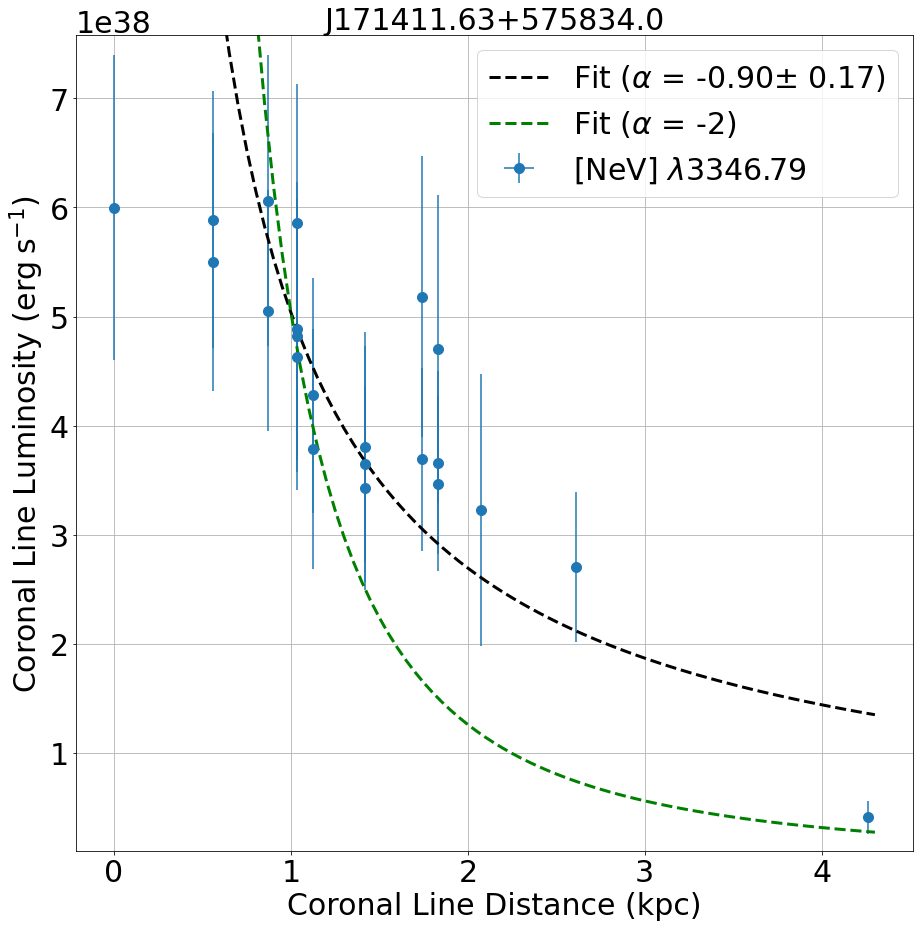

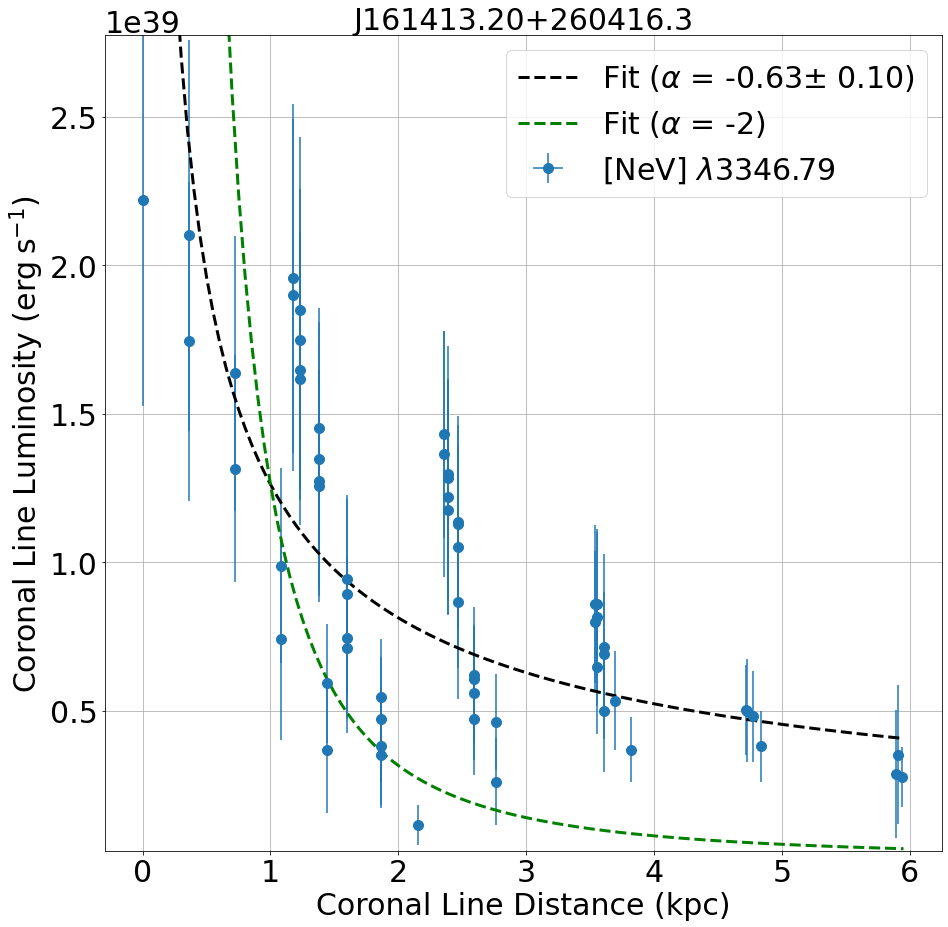

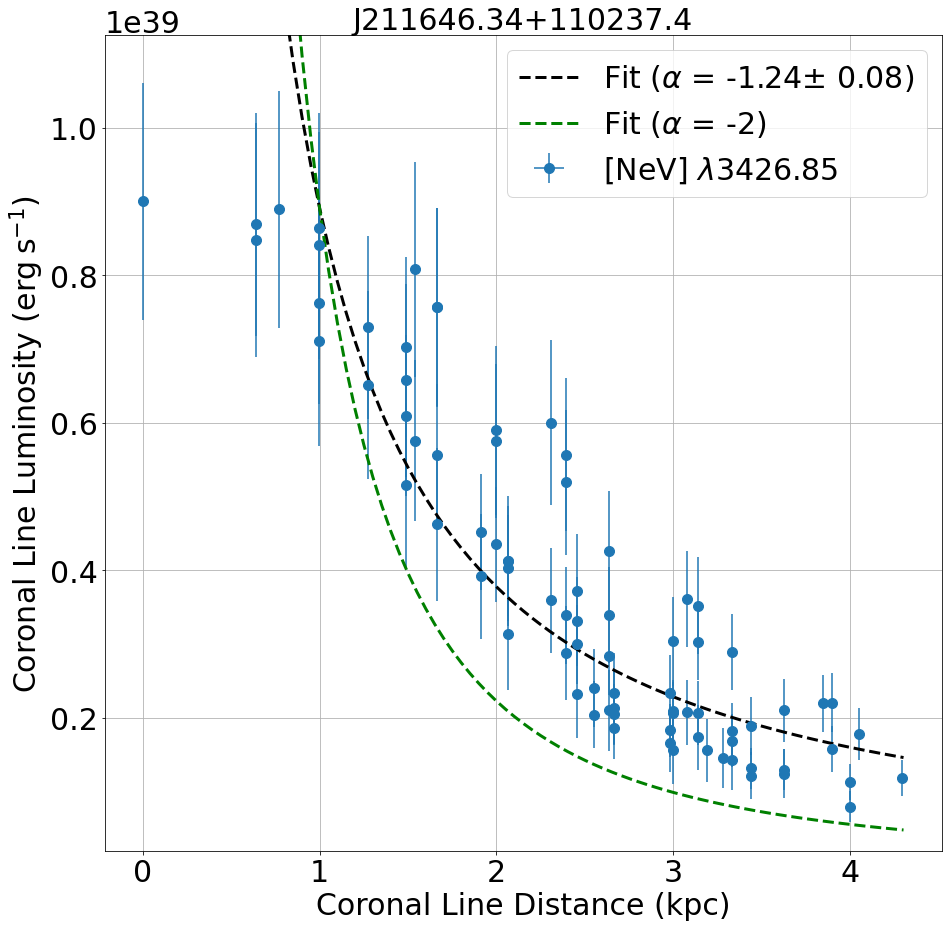

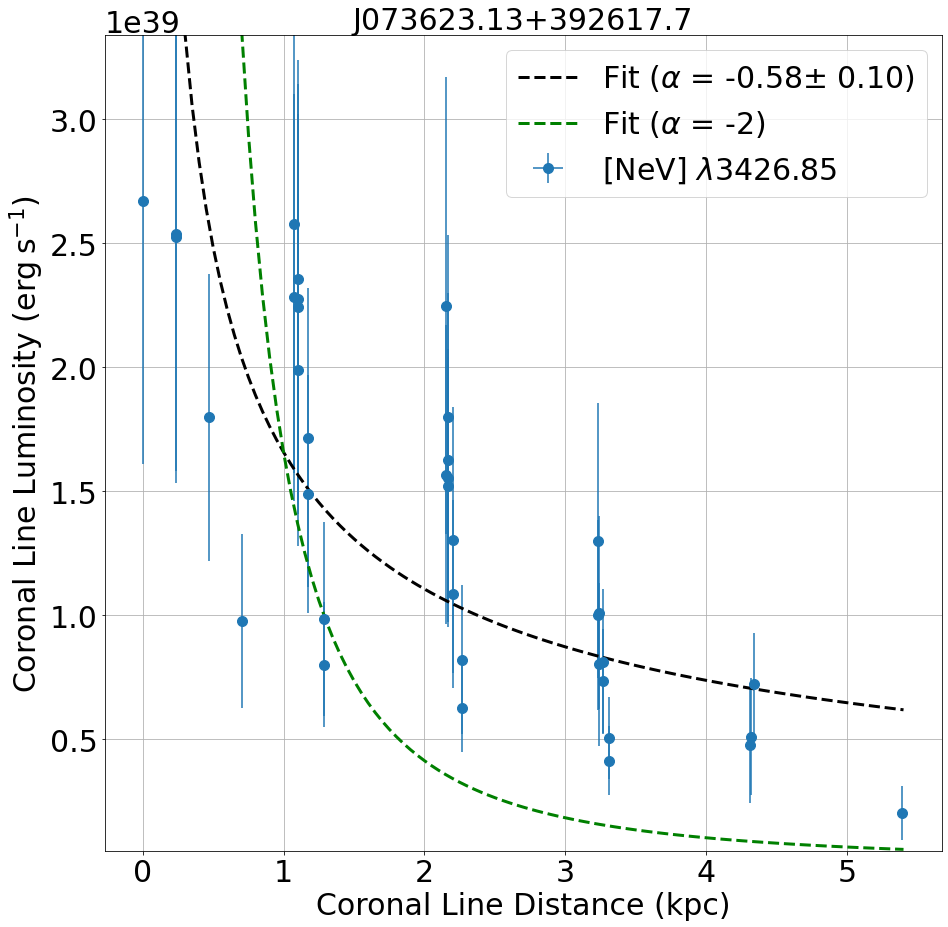

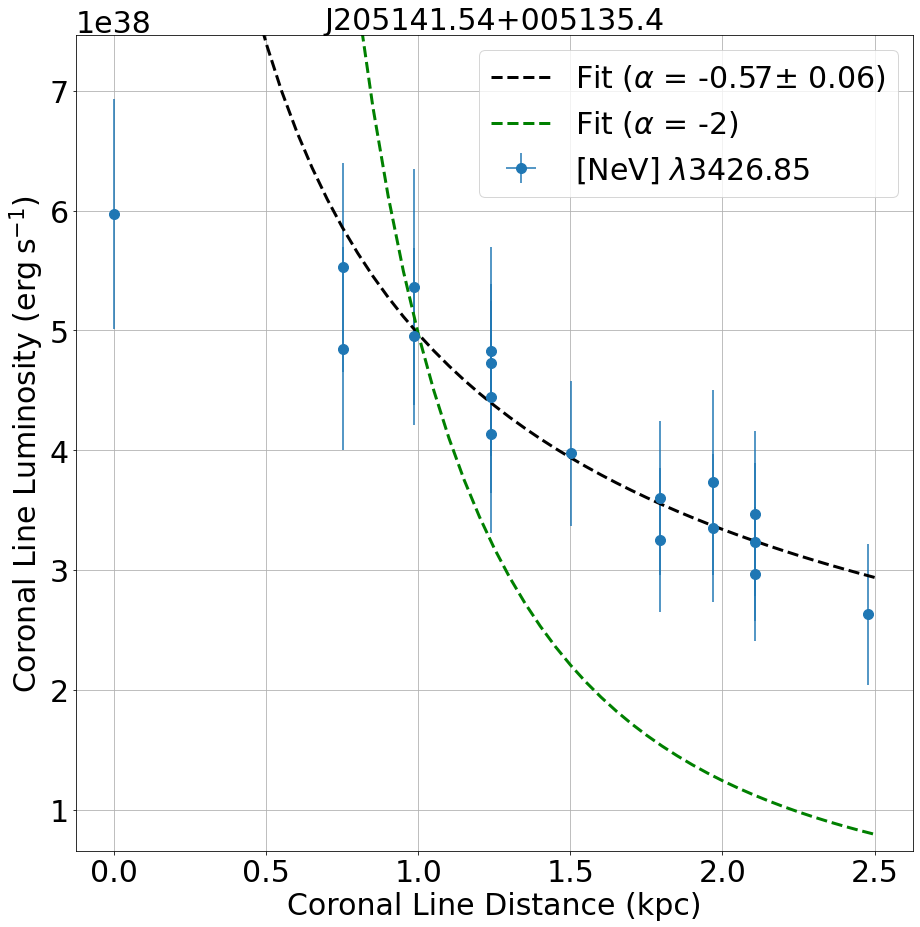

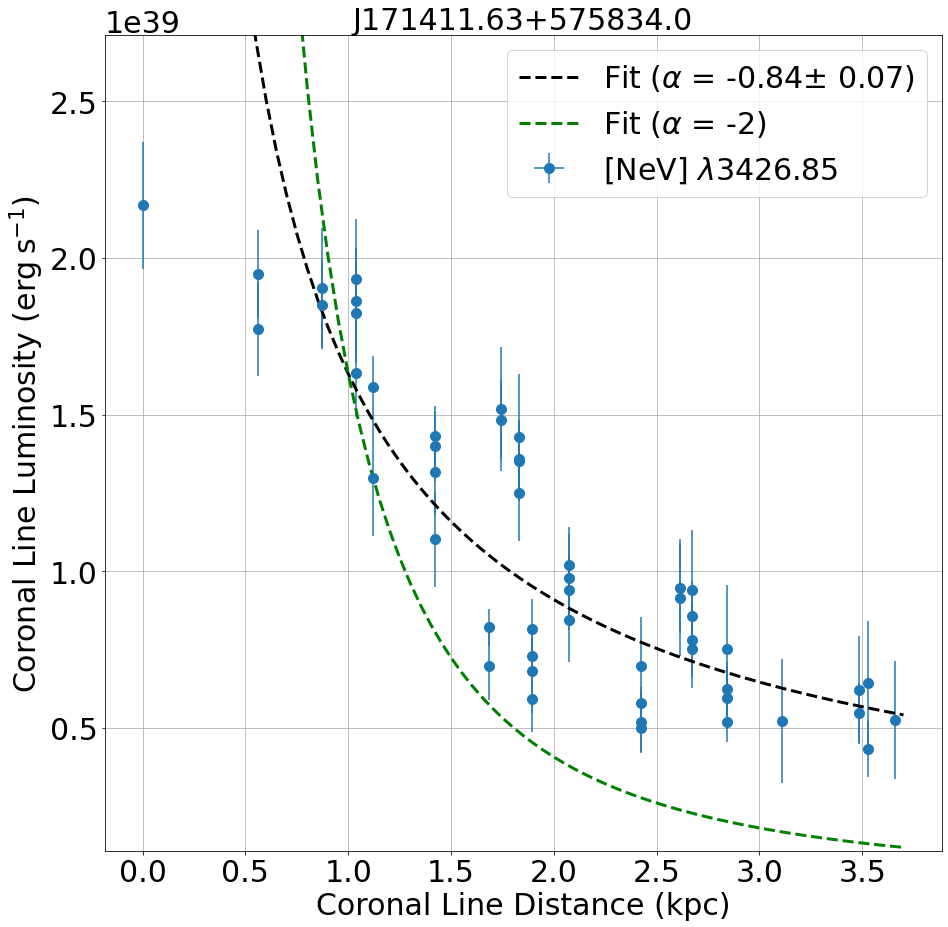

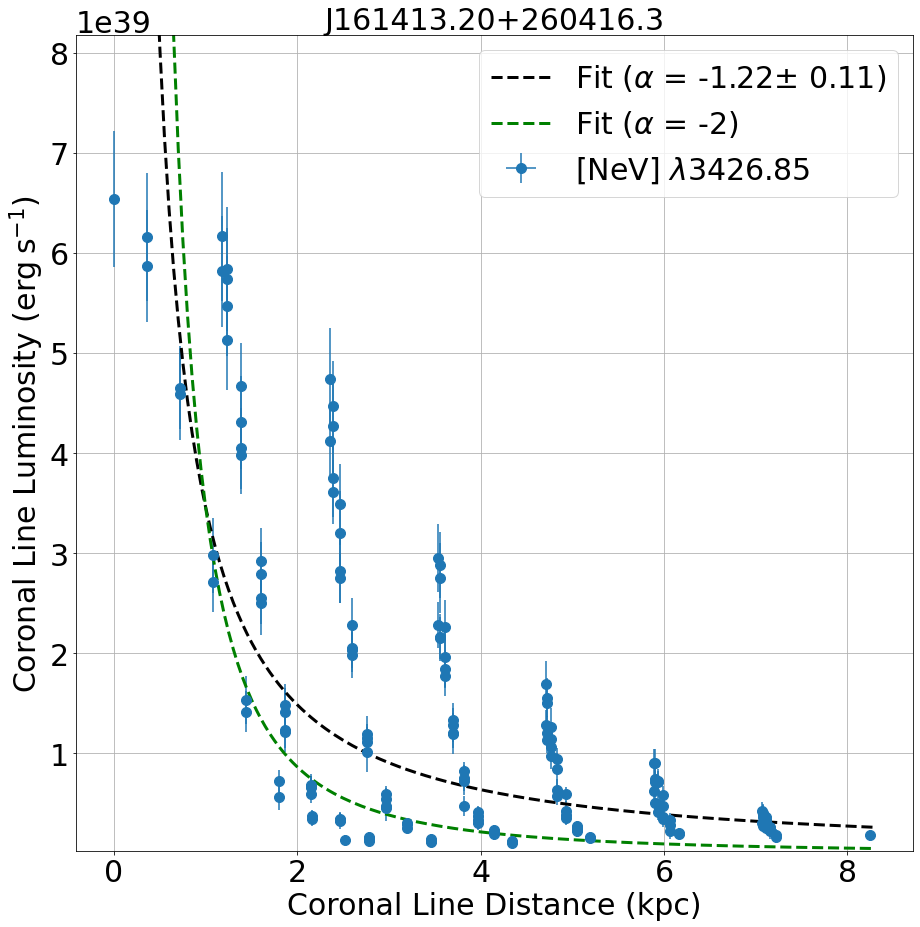

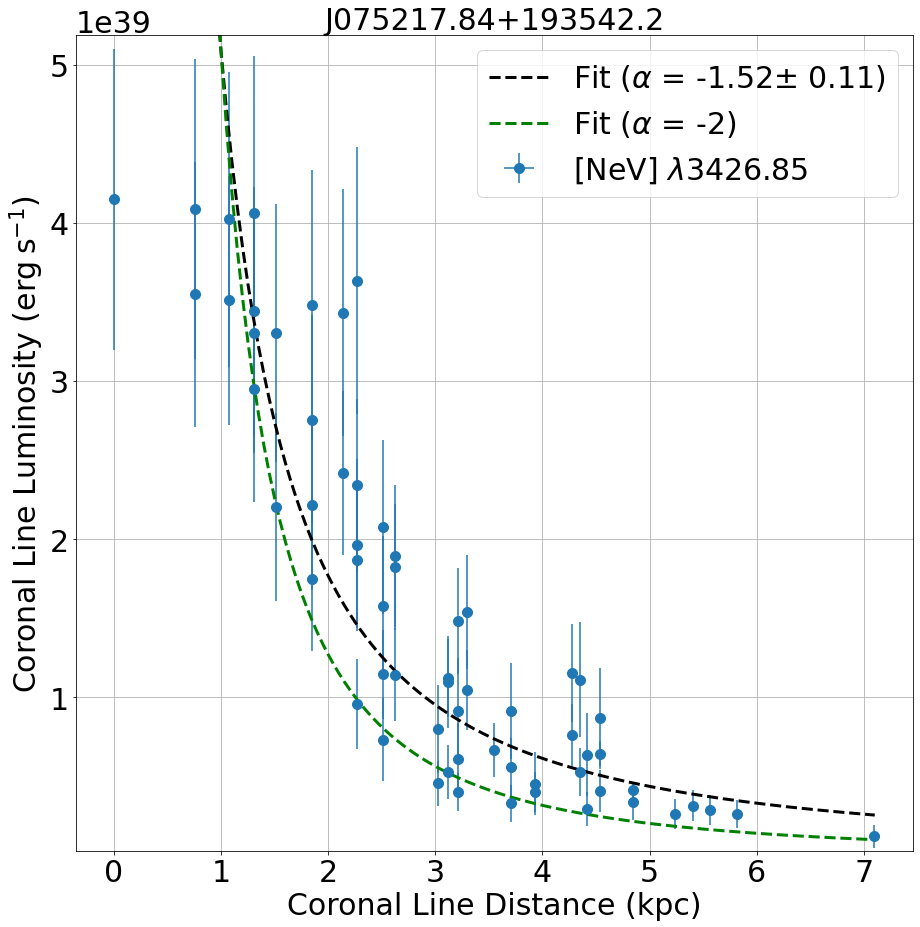

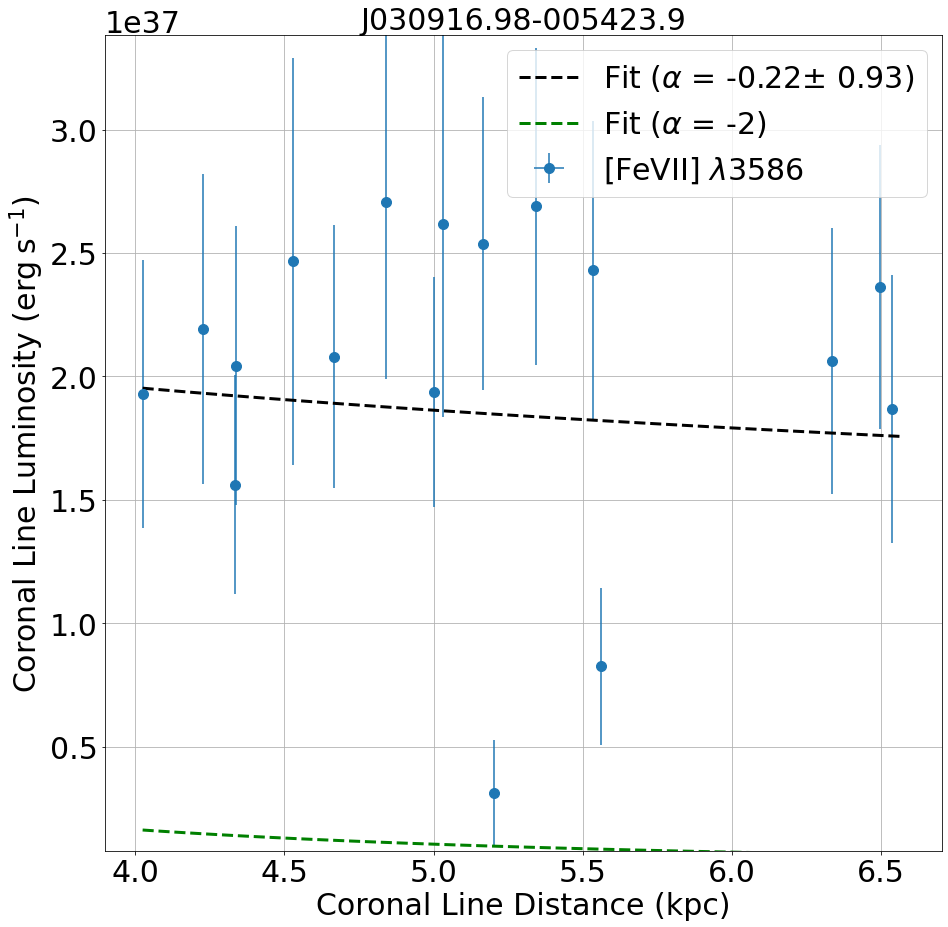

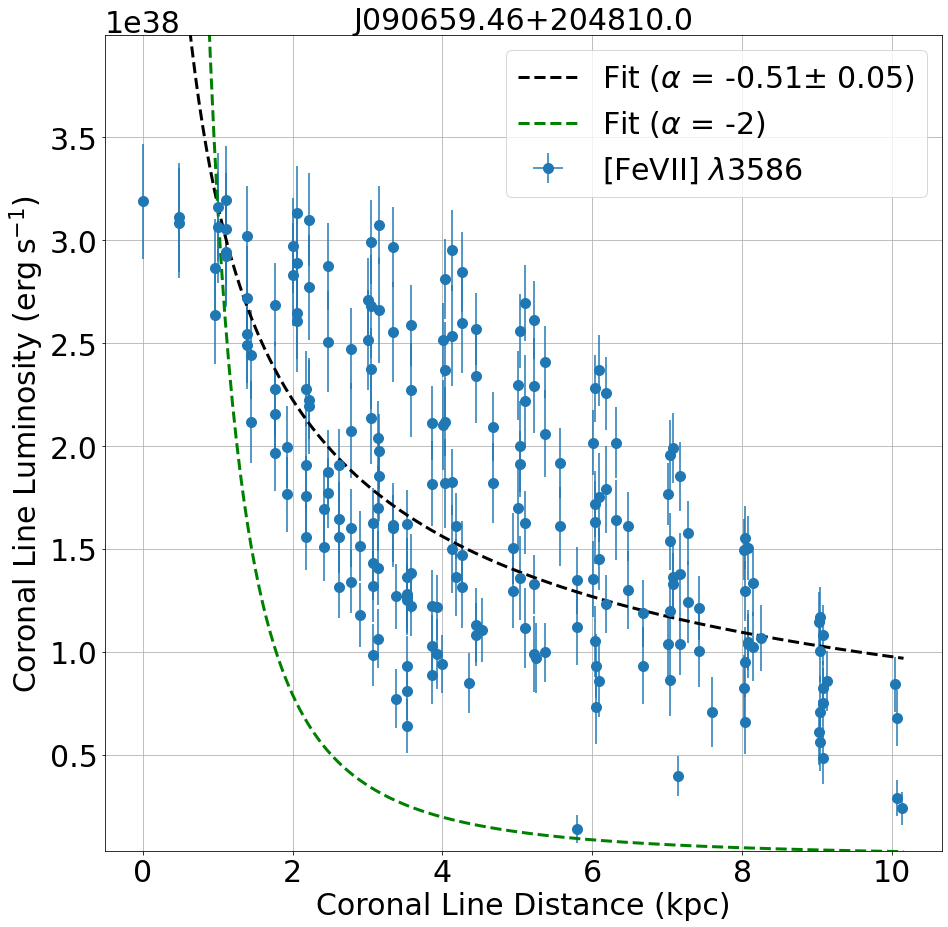

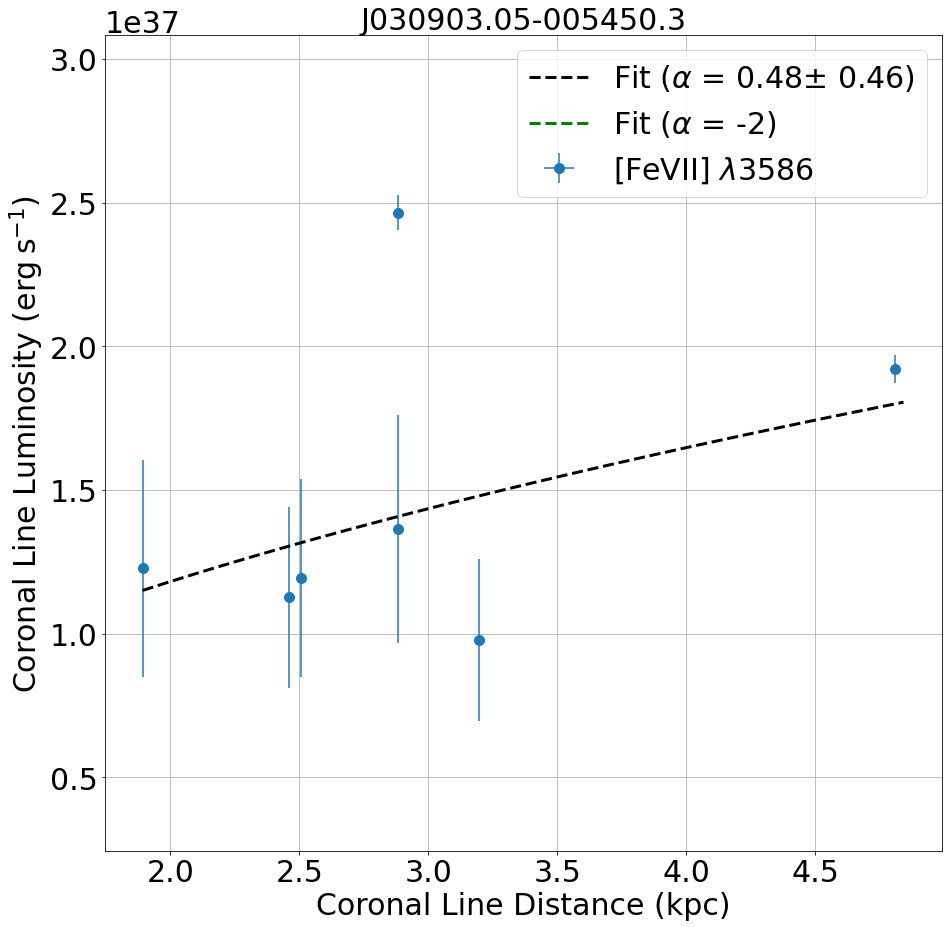

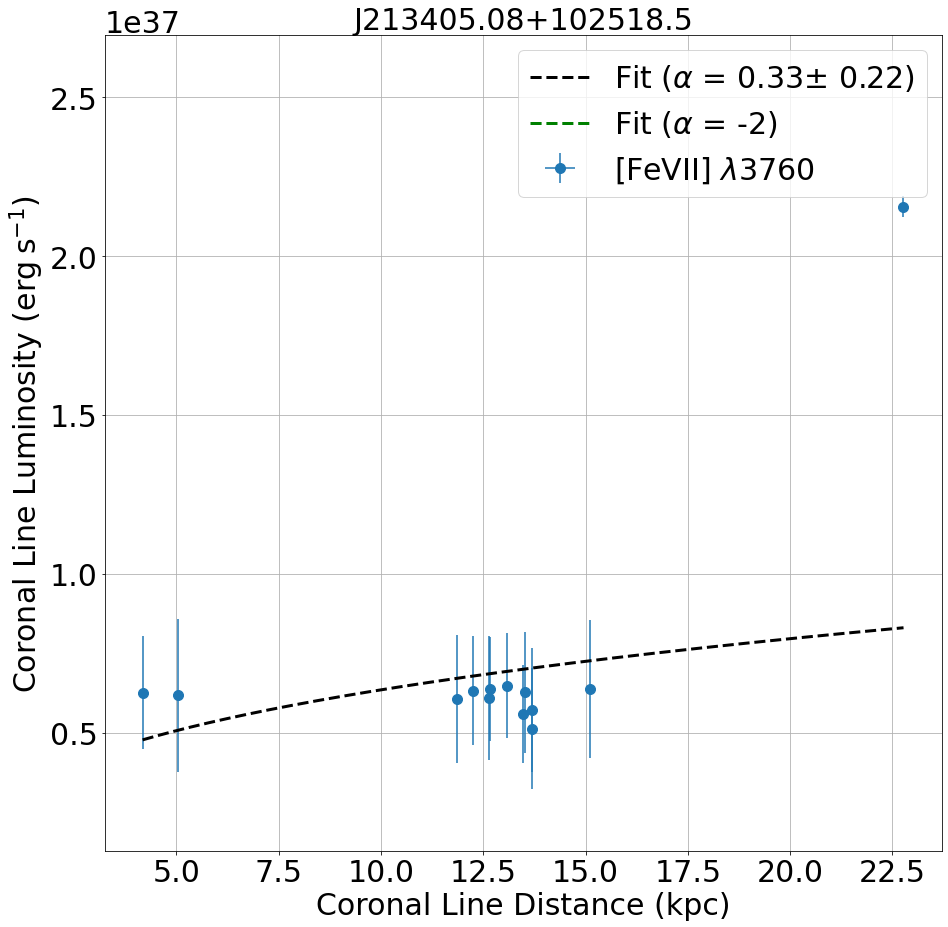

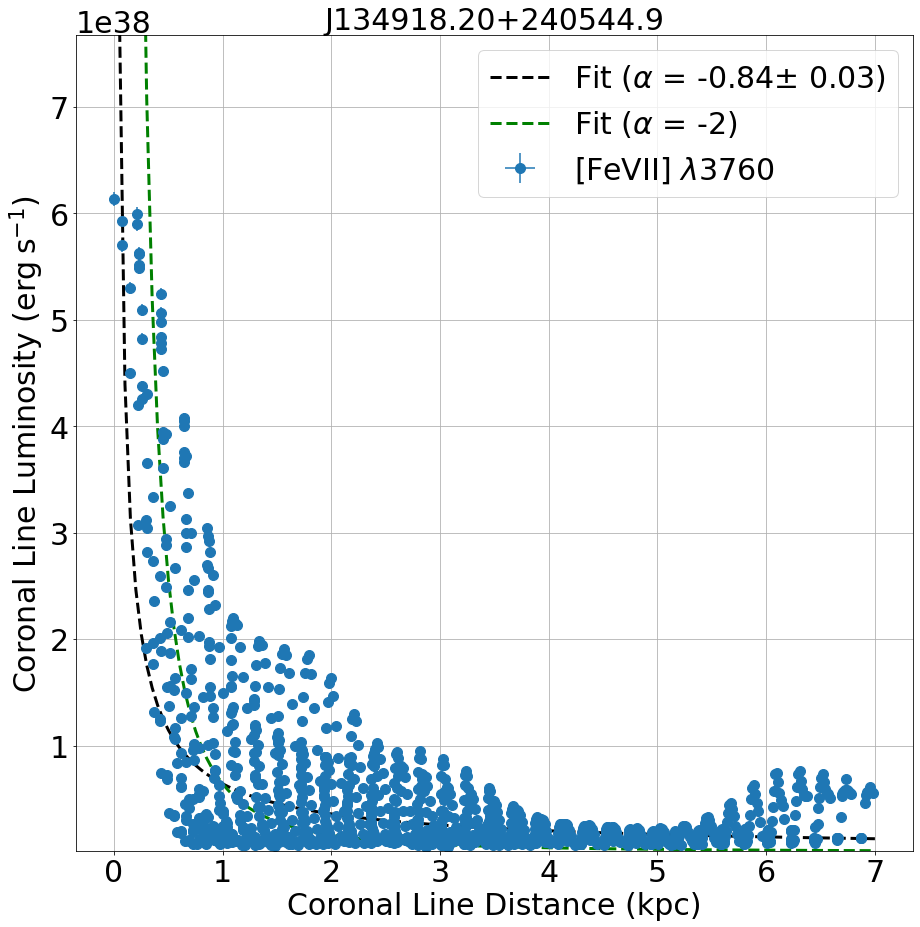

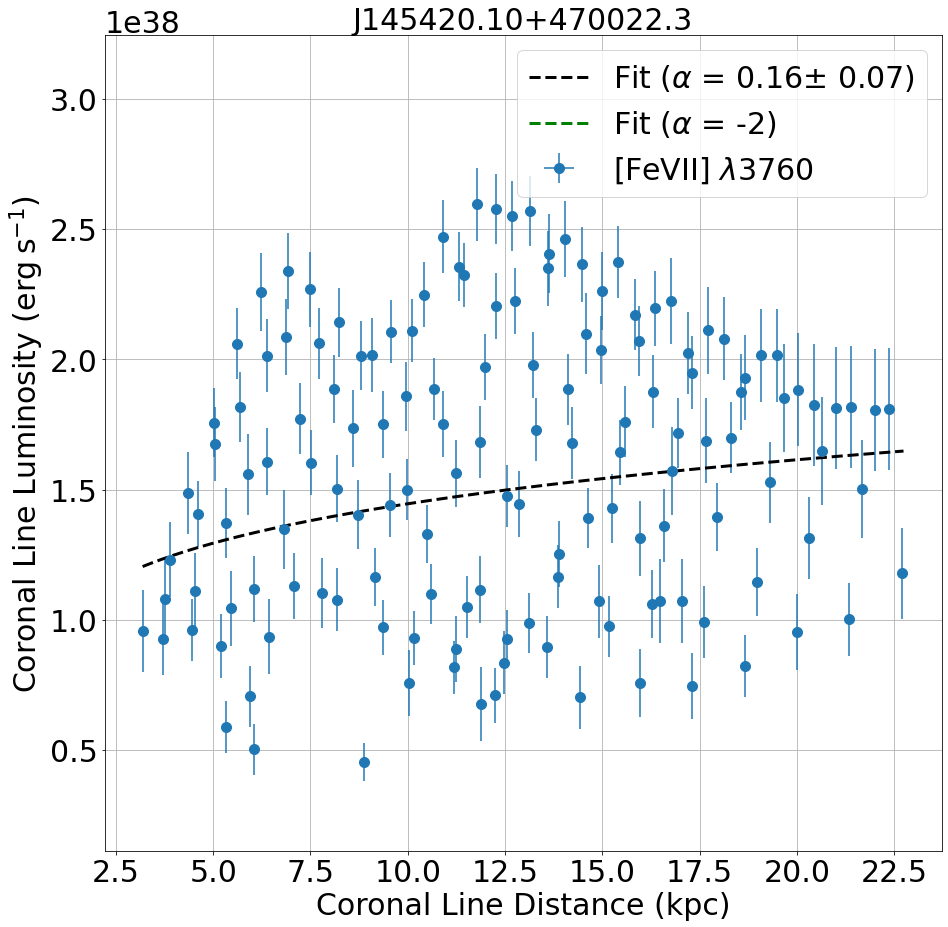

In [32]:
#temp

def cl_plot (emline, lbl):
    
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline)
    df = pd.read_csv( '/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/' %emline + emline + '_params.csv', dtype = str)
    
    for i in path:

        if i[0] == 'J':
            iau = i
            lum = np.array(df.loc[df['IAU'] == iau, ['CL Luminosity (ergs/s)']].astype(float)).flatten()
            lum_err = np.array(df.loc[df['IAU'] == iau, ['CL Luminosity Error (ergs/s)']].astype(float)).flatten() 
            dis = np.array(df.loc[df['IAU'] == iau, ['Coronal Line Distance (kpc)']].astype(float)).flatten()

            try: 
                df_tot = pd.DataFrame({'x':np.log(dis), 'y':np.log(lum)})
                model = ols('y~x', data=df_tot).fit()
            except RuntimeWarning:
                x = []
                for i in dis:
                    try:
                        x.append(np.log(i))
                    except RuntimeWarning:
                        x.append(i)      
                
                df_tot = pd.DataFrame({'x':x, 'y':np.log(lum)})
                model = ols('y~x', data=df_tot).fit()
 
            y_int = model.params[0]
            y_int_err = model.bse[0]
            slope = model.params[1]
            #slope_arr.append(slope)
            slope_err = model.bse[1]
            #slope_err_arr.append(slope_err)
            
            #print (slope, slope_err)
            
            cld_max = dis[np.argmax(dis)]
            cld_min = dis[np.argmin(dis)]
            lum_max = lum[np.argmax(lum)]
            lum_min = lum[np.argmin(lum)]
            if cld_min == 0.0:
                cld_min = 0.001

            d_range = np.arange(cld_min,cld_max + 0.05, .05)
            
            plaw = np.exp(y_int)*(np.power(d_range,slope))
            plaw_2 = np.exp(y_int)*(np.power(d_range,-2))
            
            
            fs = 30
            matplotlib.rcParams.update({'font.size': fs})
            plt.figure(figsize=(15,15))
            plt.title(iau, fontsize = fs)
            plt.errorbar(dis, lum, yerr = lum_err, xerr = 0, fmt='o', label = lbl, markersize = 10)
            plt.xlabel ('Coronal Line Distance (kpc)', fontsize = fs)
            plt.ylabel('Coronal Line Luminosity ' + r'$(\rm{erg} \> \rm{s}^{-1})$', fontsize = fs)
            plt.plot(d_range, plaw, lw=3, linestyle = '--', color = 'k', label = r'Fit ($\alpha$ = %s'%'{0:.2f}'.format(slope) + '$\pm$ %s'%'{0:.2f}'.format(slope_err) + ')')
            plt.plot(d_range, plaw_2, lw=3, linestyle = '--', color = 'g', label = r'Fit ($\alpha$ = -2)')
            plt.ylim(top=lum_max*1.25)
            plt.ylim(bottom=lum_min*0.25)
            plt.legend(fontsize = fs)
            plt.grid(True)
            plt.tick_params(labelsize=fs)
            #plt.yscale('log')
            #plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'clf_cld.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
            #plt.xscale('log')
            plt.show()
            plt.close()

    return;

cl_plot(emline = 'NeV_3346.79A', lbl = '[NeV] $\lambda$3346.79')    
cl_plot(emline = 'NeV_3426.85A', lbl = '[NeV] $\lambda$3426.85')
cl_plot(emline = 'FeVII_3586A', lbl = '[FeVII] $\lambda$3586')
cl_plot(emline = 'FeVII_3760A', lbl = '[FeVII] $\lambda$3760')
#clf(emline = 'FeVII_6086A', lbl = '[FeVII] $\lambda$6086')
#cl_plot(emline = 'FeX_6374A', lbl = '[FeX] $\lambda$6374')

In [24]:
#Chapter 07: Summed Parameters

def output_file(emline):

    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline)
    cl_path = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline
    
    data = pd.read_csv(cl_path + emline + '_params.csv', dtype = str)
    
    iau_sum_arr = []
    summed_lum_arr = []
    summed_lum_err_arr = []
    red_arr = []
    
    f = open(cl_path + emline + '_summed_params.csv', "a+")
    f.write('IAU')
    f.close()
    
    for i in path:
        flux_arr = []
        flux_err_arr = []

        
        if i[0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == iau)
            mangaid = tbdata['mangaid'][ind][0]
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            ldist = tbdata_1['LDIST_Z'][ind_2][1]
            redshift = tbdata['z'][ind][0]
            
            flux_arr.append(data.loc[data['IAU'] == iau, ['Total Flux (ergs/s cm^2/A/spaxel)']].astype(float))
            flux_err_arr.append(np.square(data.loc[data['IAU'] == iau, ['Flux Uncertainty (ergs/s cm^2/A/spaxel)']].astype(float)))
        summed_flux = np.sum(flux_arr)
        summed_flux_err = np.sqrt(np.sum(flux_err_arr))
       
        if summed_flux > 0:
            
            summed_lum_arr.append(4*math.pi*(ldist*3.086*(10**24))**2*float(summed_flux)*10**-17)
            summed_lum_err_arr.append(4*math.pi*(ldist*3.086*(10**24))**2*float(summed_flux_err)*10**-17)
            
            iau_sum_arr.append(iau)
            red_arr.append(redshift)
            
    SUMIAU = pd.DataFrame(iau_sum_arr)
    SUMLUM = pd.DataFrame(summed_lum_arr)
    SUMLUM_ERR = pd.DataFrame(summed_lum_err_arr)
    RED = pd.DataFrame(red_arr)
    
    data_1 = pd.read_csv(cl_path + emline + '_summed_params.csv')
    data_1['IAU'] = SUMIAU[0] 
    data_1['redshift'] = RED[0]
    data_1['CL Luminosity (erg/s)'] = SUMLUM
    data_1['Luminosity Uncertainty (ergs/s)'] = SUMLUM_ERR
    data_1.to_csv(cl_path + emline + '_summed_params.csv', index=False)
           
    return;
#output_file(emline = 'NeV_3346.79A')
#output_file(emline = 'NeV_3426.85A')
#output_file(emline = 'FeVII_3586A')
#output_file(emline = 'FeVII_3760A')
#output_file(emline = 'FeVII_6086A')
#output_file(emline = 'FeX_6374A')




In [74]:
#Chapter 08: SFR, Bolometric Luminosity, and CL Luminosity 

iau_arr = []
sfr_1re_arr = []
sfr_tot_arr = []
redshift_arr = []
bol_arr = []
cl_lum_arr = []
cl_lum_err_arr = []

def sfr(emline):
    path_sfr = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline)
    path_sfr = '/Users/jamesnegus/Google_Drive_CU/Research/output/%s/' %directory + '%s/' %emline + emline + '_summed_params.csv'
    sfr_file = pd.read_csv(path_sfr)
    
    for i in range (len(sfr_file)):
        iau = sfr_file.loc[i,'IAU']
        try:
            dummy = len (iau)
        except TypeError:
            continue
        ind_cl = np.where(tbdata['nsa_iauname'] == iau) #retrieving iau indice in tbdata
        mangaid_cl = tbdata['mangaid'][ind_cl][0] #getting manga-id from tbdata
        plateifu1 = tbdata['plateifu'][ind_cl][0] #getting plateifu from tbdata
        ind_1 = np.where(tbdata_1['mangaid'] == mangaid_cl)
        
        redshift = tbdata['z'][ind_cl][0]
        redshift_arr.append(redshift)
        
        #Ensuring data is VOR10 binned in the tbdata1 file. 
        if len(ind_1[0]) == 3:
            vor_10_ind = ind_1[0][1]
        if len(ind_1[0]) == 6:
            vor_10_ind = ind_1[0][2]
        if len(ind_1[0]) == 9:
            vor_10_ind = ind_1[0][3]  

        sfr_1re = tbdata_1['SFR_1RE'][vor_10_ind]
        sfr_tot = tbdata_1['SFR_TOT'][vor_10_ind]
        
        if sfr_1re == -999:
            sfr_1re = ''
     
        sfr_1re_arr.append(sfr_1re)
        sfr_tot_arr.append(sfr_tot)
        
        ind_2 = np.where(tbdata_1['mangaid'] == mangaid_cl)
        ldist = tbdata_1['LDIST_Z'][ind_2][1]
        oiii_flux_tot = tbdata_1['EMLINE_GFLUX_TOT'][ind_2][1][13]*10**-17
        oiii_lum = 4*math.pi*(ldist*3.086*(10**24))**2*oiii_flux_tot
        
#         cl_flux = sfr_file['Total Flux (ergs/s cm^2/A/spaxel)'][i]
#         cl_flux_err = sfr_file['Flux Uncertainty (ergs/s cm^2/A/spaxel)'][i]

        if len(plateifu1) == 9:
            plate = plateifu1[0:4]
            ifu = plateifu1[5:9]
        if len(plateifu1) == 10 and plateifu1[0] != '1':
            plate = plateifu1[0:4]
            ifu = plateifu1[5:10]
        if len(plateifu1) == 10 and plateifu1[0] == '1':
            plate = plateifu1[0:5]
            ifu = plateifu1[6:10]
        if len(plateifu1) == 11:
            plate = plateifu1[0:5]
            ifu = plateifu1[6:11]

        #oiii_bol = oiii_lum*3400
#         oiii_bol = (oiii_lum**0.5617)*(10**22.186)
#         bol_arr.append(oiii_bol)

        #print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '; ' + str(emline) + '; Bolometric Luminosity = ' + str(oiii_bol) + '\n')
        
        #print (iau, sfr_1re, sfr_tot)

    SFR_1RE = pd.DataFrame(sfr_1re_arr)
    SFR_TOT = pd.DataFrame(sfr_tot_arr)
    RED = pd.DataFrame(redshift_arr)
   # BOL = pd.DataFrame(bol_arr)
#     CL_LUM = pd.DataFrame(cl_lum_arr)
#     CL_LUM_ERR = pd.DataFrame(cl_lum_err_arr)
    

    file = pd.read_csv(path_sfr)
    file['Redshift'] = RED
    file['SFR_1RE (M_sun/yr)'] = SFR_1RE
    file['SFR_TOT (M_sun/yr)'] = SFR_TOT
   # file['Bolometric Luminosity (ergs/s)'] = BOL
#     file['Coronal Line Luminosity (ergs/s)'] = CL_LUM
#     file['Coronal Line Luminosity Uncertainty (ergs/s)'] = CL_LUM_ERR
    file.to_csv(path_sfr, index=False)
    return; 
#must run one at a time
#sfr(emline = 'NeV_3346.79A')
#sfr(emline = 'NeV_3426.85A')
#sfr(emline = 'FeVII_3586A')
#sfr(emline = 'FeVII_3760A')
#sfr(emline = 'FeVII_6086A')
sfr(emline = 'FeX_6374A')

In [2]:
#Chapter 09: Plotting CLF, SFR, Redshift, and Bolometric Luminosity

fs = 30

flux_tot_arr = []
sfr_tot_arr = []
x_err_tot = []
clr_arr = []
bol_arr = []
cl_lum_arr = []
cl_lum_err_arr = []

def plots(emline, marker, lbl):

    data_file = ('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline + emline + '_summed_params.csv')
    directory = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline)
    data = pd.read_csv(data_file)
    df = pd.DataFrame(data)
    
#     for i in directory:
#         if i[0] == 'J':
#             iau = i
            
    cl_flux  = df['Total Flux (ergs/s cm^2/A/spaxel)'].to_numpy()
    cl_flux_err = df['Flux Uncertainty (ergs/s cm^2/A/spaxel)'].to_numpy()
    sfr_1re = df['SFR_1RE (M_sun/yr)'].to_numpy()
    sfr_tot = df['SFR_TOT (M_sun/yr)'].to_numpy()
    red = df['Redshift'].to_numpy()
    bol = df['Bolometric Luminosity (ergs/s)'].to_numpy()
    cl_lum = df['Coronal Line Luminosity (ergs/s)'].to_numpy()
    cl_lum_err = df['Coronal Line Luminosity Uncertainty (ergs/s)'].to_numpy()
    clr = df['Coronal Line Radius (kpc)'].to_numpy()
    
    bol_arr.append(bol)
    cl_lum_arr.append(cl_lum)
    cl_lum_err_arr.append(cl_lum_err)
    flux_tot_arr.append(cl_flux)
    sfr_tot_arr.append(sfr_tot)
    x_err_tot.append(cl_flux_err)
    clr_arr.append(clr)
    
    if not os.path.exists('output/5_sigma/figures'):
        os.makedirs('output/5_sigma/figures') 
    
    def best_fit_slope_and_intercept(cl_flux, sfr_tot):
        m = (((mean(cl_flux)*mean(sfr_tot)) - mean(cl_flux*sfr_tot)) /
             ((mean(cl_flux)*mean(cl_flux)) - mean(cl_flux*cl_flux)))
        
        b = mean(sfr_tot) - m*mean(cl_flux)
        
        return m, b
    
    m, b = best_fit_slope_and_intercept(cl_flux, sfr_tot)
    
    regression_line = [(m*x)+b for x in cl_flux]
    
    #print (emline + ' SFR Total Slope = ' + str(m) + " ; Intercept = " + str(b))
    
    fs = 20
    ms = 15
    
#     corr, _ = stats.pearsonr(cl_flux, sfr_tot)
#     print('Pearsons correlation: %.3f' % corr)

#     print (regression_line)
#     plt.figure(figsize=(15,15))
#     plt.title(lbl, fontsize = fs)
#     plt.errorbar(cl_flux, sfr_1re, xerr = cl_flux_err, yerr = 0, fmt='o', label = lbl, markersize = ms)
#     plt.xlabel ('Integrated Coronal Line Flux ' + r'$\left(^{-17}\>\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$', fontsize = fs)
#     plt.ylabel('Star Formation Rate 1Re ' +  r'($\frac{M_{\odot}}{yr}$)', fontsize = fs)
#     #plt.xlabel('Coronal Line Distance (kpc)')
#     #plt.legend(fontsize = fs)
#     plt.tick_params(labelsize=fs)
#     plt.grid(True)
#     #plt.savefig('output/5_sigma/figures/%s'%emline + '_sfr_1re_clf.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#     #plt.xscale('log')
#     plt.show()
#     plt.close()
#     flux_tot_arr.append(cl_flux)
#     sfr_tot_arr.append(sfr_tot)
#     x_err_tot.append(cl_flux_err)
    
#     plt.figure(figsize=(15,15))
#     plt.title(lbl, fontsize = fs)
#     #plt.plot(cl_flux, regression_line, color = 'k')
#     plt.errorbar(cl_flux, sfr_tot, xerr = cl_flux_err, yerr = 0, fmt='o', label = lbl, markersize = ms)
#     plt.xlabel ('Integrated Coronal Line Flux ' + r'$\left(^{-17}\>\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$', fontsize = fs)
#     plt.ylabel('Star Formation Rate Total ' +  r'($\frac{M_{\odot}}{yr}$)', fontsize = fs)
#     #plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
#     #plt.legend(fontsize = fs)
#     plt.grid(True)
#     plt.tick_params(labelsize=fs)
#     plt.text(250,7, 'Pearsons Correlation: %.3f' % corr, size = 15)
#     #plt.savefig('output/5_sigma/figures/%s'%emline + '_sfr_tot_clf.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#     #plt.xscale('log')
#     plt.show()
#     plt.close()
    
#     plt.figure(figsize=(15,15))
#     plt.title(lbl)
#     plt.errorbar(cl_lum/10000, bol, xerr = cl_lum_err/10000, yerr = 0, fmt='o', label = lbl, markersize = ms)
#     plt.xlabel ('Integrated Coronal Line Luminosity ' + r'$\left(^{-13} \> \frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$', fontsize = fs)
#     plt.ylabel('Bolometric Luminosity ' +  r'$\left(\frac{\rm{ergs}}{s}\right)$', fontsize = fs)
#     #plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
#     #plt.ticklabel_format(style='sci', axis='x', scilimits=(10, 100))
#     #plt.legend(fontsize = fs)
#     plt.grid(True)
#     plt.tick_params(labelsize=fs)
#     #plt.savefig('output/5_sigma/figures/%s'%emline + '_cl_lum_bol.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#     #plt.xscale('log')
#     plt.show()
#     plt.close()
    
    
    return; 
#plots(emline = 'NeV_3346.79A', lbl = '[NeV] $\lambda$3346.79', marker = 'b^')
# plots(emline = 'NeV_3426.85A', lbl = '[NeV] $\lambda$3426.85', marker = 'r^')
# plots(emline = 'FeVII_3586A', lbl = '[FeVII] $\lambda$3586', marker = 'k^')
# plots(emline = 'FeVII_3760A', lbl = '[FeVII] $\lambda$3760', marker = 'c^')
# plots(emline = 'FeVII_6086A', lbl = '[FeVII] $\lambda$6086', marker = 'm^')
# plots(emline = 'FeX_6374A', lbl = '[FeX] $\lambda$6374', marker = 'g^')

# fs = 30
# ms = 10

# cl_lum_arr = np.nan_to_num(np.concatenate(cl_lum_arr))
# bol_arr = np.nan_to_num(np.concatenate(bol_arr))
# cl_lum_err_arr = np.nan_to_num(np.concatenate(cl_lum_err_arr))

# cl_lum_arr = cl_lum_arr[np.nonzero(cl_lum_arr)]
# bol_arr = bol_arr[np.nonzero(bol_arr)]
# cl_lum_err_arr = cl_lum_err_arr[np.nonzero(cl_lum_err_arr)]

# flux_tot_arr = np.concatenate(flux_tot_arr)
# sfr_tot_arr = np.concatenate(sfr_tot_arr)
# x_err_tot = np.concatenate(x_err_tot)
# clr_arr = np.concatenate(clr_arr)

# flux_tot_arr = flux_tot_arr[~np.isnan(flux_tot_arr)]
# sfr_tot_arr = sfr_tot_arr[~np.isnan(sfr_tot_arr)]
# x_err_tot = x_err_tot[~np.isnan(x_err_tot)]
# clr_arr = clr_arr[~np.isnan(clr_arr)]

# corr, _ = stats.pearsonr(cl_lum_arr, bol_arr)
# print('Pearsons correlation: %.3f' % corr)

# plt.figure(figsize=(15,15))
# #plt.title(lbl)
# plt.errorbar(cl_lum_arr/10000, bol_arr, xerr = cl_lum_err_arr/10000, yerr = 0, fmt='o', markersize = ms)
# #plt.xlabel ('Integrated Coronal Line Luminosity ' + r'$\left(\>\frac{\rm{ergs}}{s}\right)$', fontsize = fs)
# plt.xlabel ('Integrated Coronal Line Luminosity ' + r'$\left(10^{-13} \> \frac{\rm{ergs}}{s}\right)$', fontsize = fs)
# plt.ylabel('Bolometric Luminosity ' +  r'$\left(\frac{\rm{ergs}}{s}\right)$', fontsize = fs)
# #plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
# #plt.ticklabel_format(style='sci', axis='x', scilimits=(10, 100))
# #plt.legend(fontsize = fs)
# plt.grid(True)
# plt.text(0.001,10e45, 'Pearson Correlation: %.3f' % corr, size = 30)
# plt.tick_params(labelsize=fs)
# plt.yscale('log')
# plt.xscale('log')
# plt.savefig('output/5_sigma/figures/cl_lum_bol.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()
    
# #print ('Average CLR = ' + str(np.average(clr_arr)))

# corr, _ = stats.pearsonr(clr_arr, sfr_tot_arr)
# print('Pearsons correlation: %.3f' % corr)

# plt.figure(figsize=(20,20))
# #plt.title(fontsize = fs)
# plt.errorbar(clr_arr, sfr_tot_arr, xerr = 0, yerr = 0, fmt='o', markersize = ms)
# plt.xlabel ('Coronal Line Radius (kpc)', fontsize = fs)
# plt.ylabel('Total Star Formation Rate ' +  r'($\frac{M_{\odot}}{yr}$)', fontsize = fs)
# #plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
# #plt.legend(fontsize = fs)
# plt.grid(True)
# plt.tick_params(labelsize=fs)
# plt.text(15,0.00034, 'Pearson Correlation: %.3f' % corr, size = fs)
# #plt.xscale('log')
# plt.yscale('log')
# plt.savefig('output/5_sigma/figures/clr_sfr_tot.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# corr, _ = stats.pearsonr(flux_tot_arr, sfr_tot_arr)
# print('Pearsons correlation: %.3f' % corr)

# plt.figure(figsize=(20,20))
# #plt.title(fontsize = fs)
# plt.errorbar(flux_tot_arr, sfr_tot_arr, xerr = x_err_tot, yerr = 0, fmt='o', markersize = ms)
# plt.xlabel ('Integrated Coronal Line Flux ' + r'$\left(10^{-17}\>\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$', fontsize = fs)
# plt.ylabel('Total Star Formation Rate ' +  r'($\frac{M_{\odot}}{yr}$)', fontsize = fs)
# #plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
# #plt.legend(fontsize = fs)
# plt.grid(True)
# plt.tick_params(labelsize=fs)
# #plt.text(0.1,34, 'Pearson Correlation: %.3f' % corr, size = fs)
# plt.text(100,0.0003, 'Pearsons Correlation: %.3f' % corr, size = 25)
# plt.xscale('log')
# plt.yscale('log')
# plt.savefig('output/5_sigma/figures/clf_sfr_tot.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

J171411.63+575834.0 0


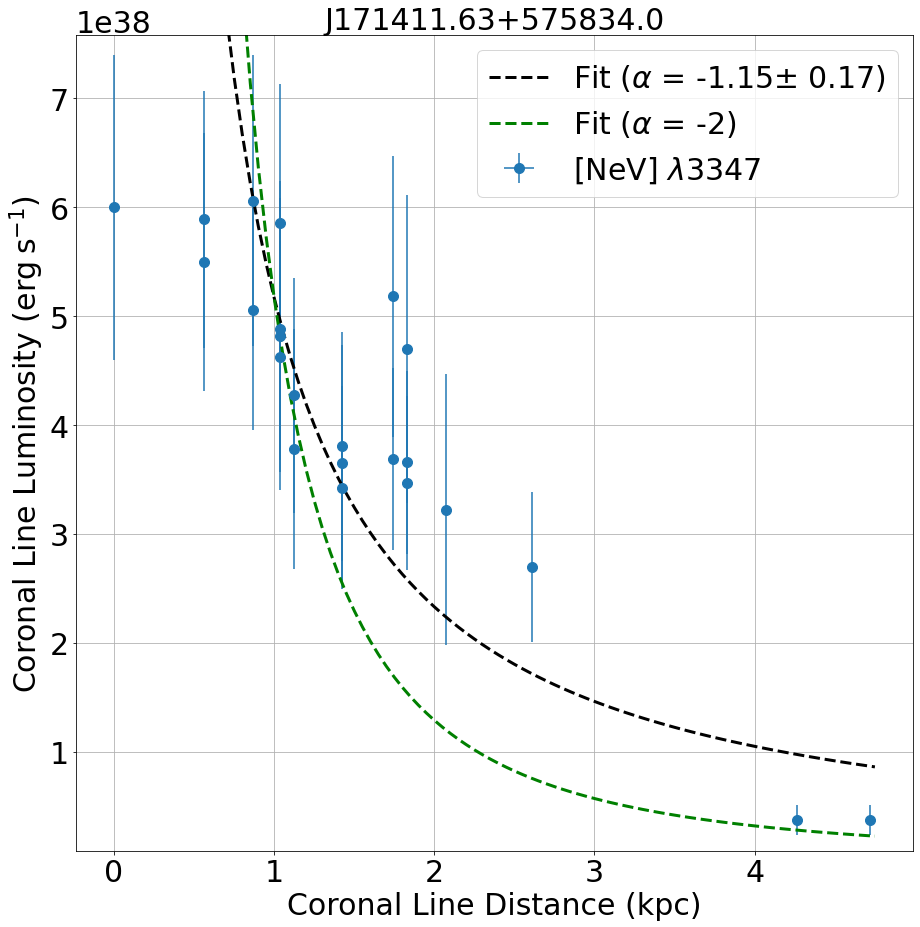

J161413.20+260416.3 1073742080


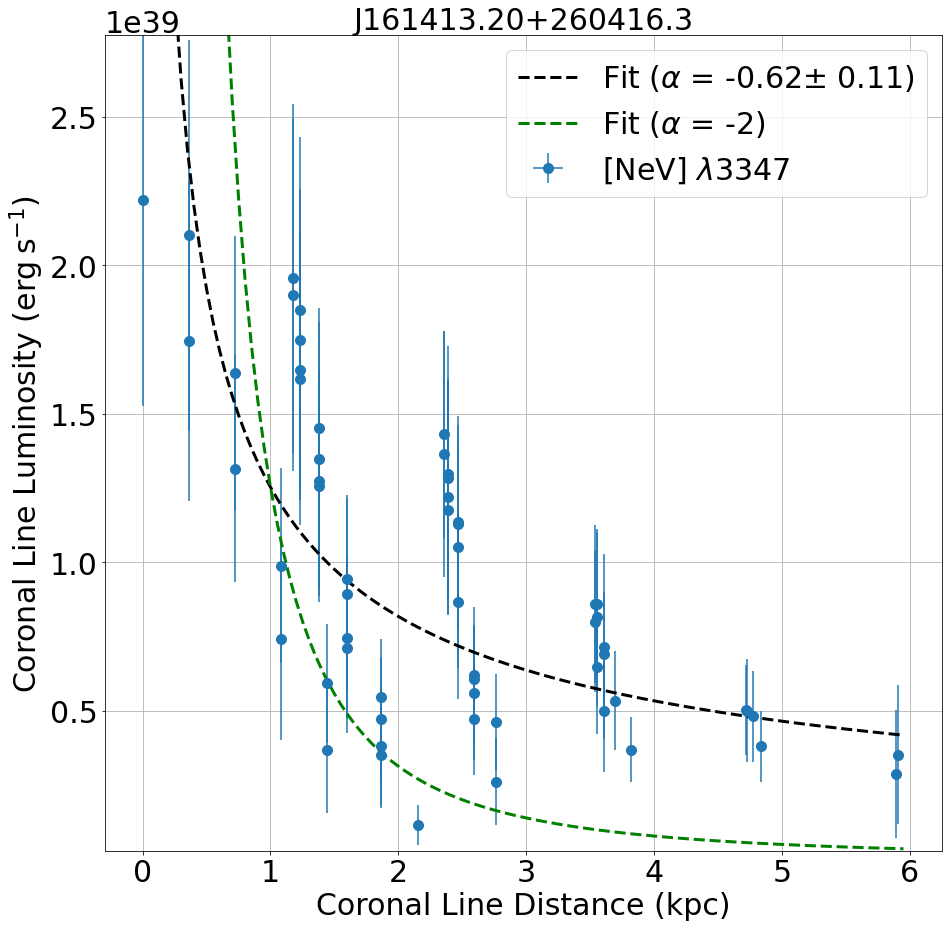

J211646.34+110237.4 64


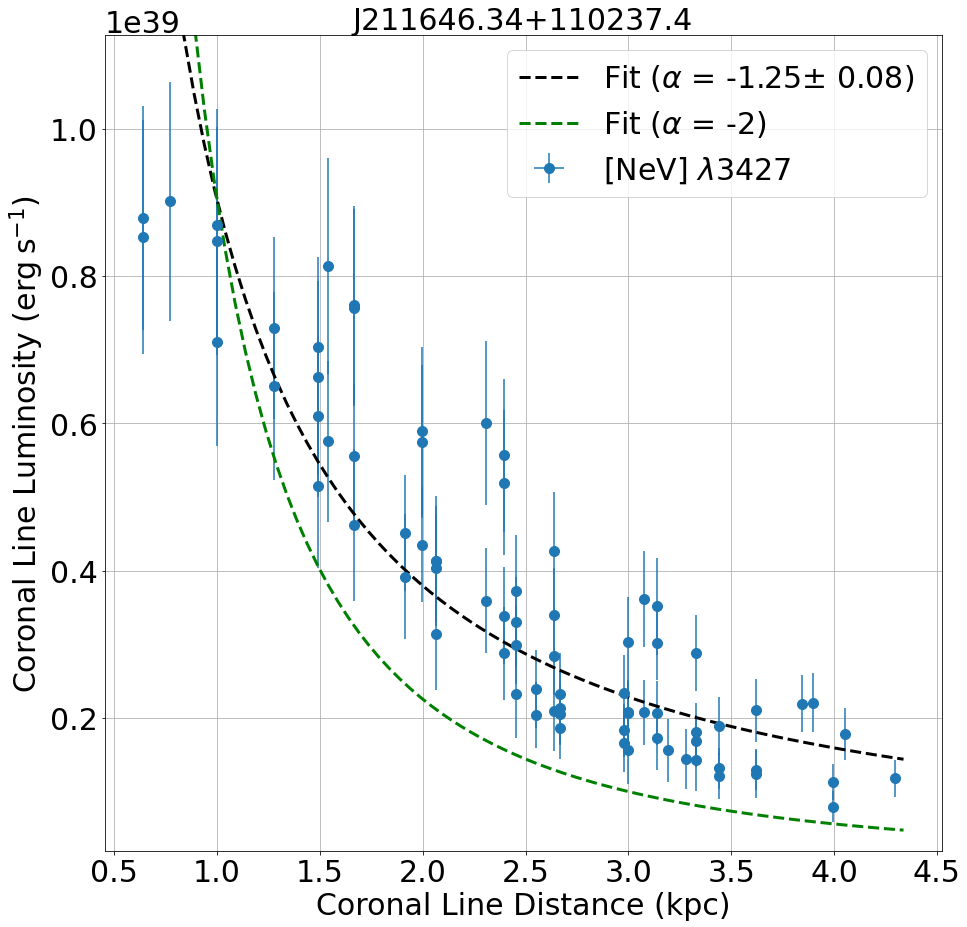

J073623.13+392617.7 1073742080


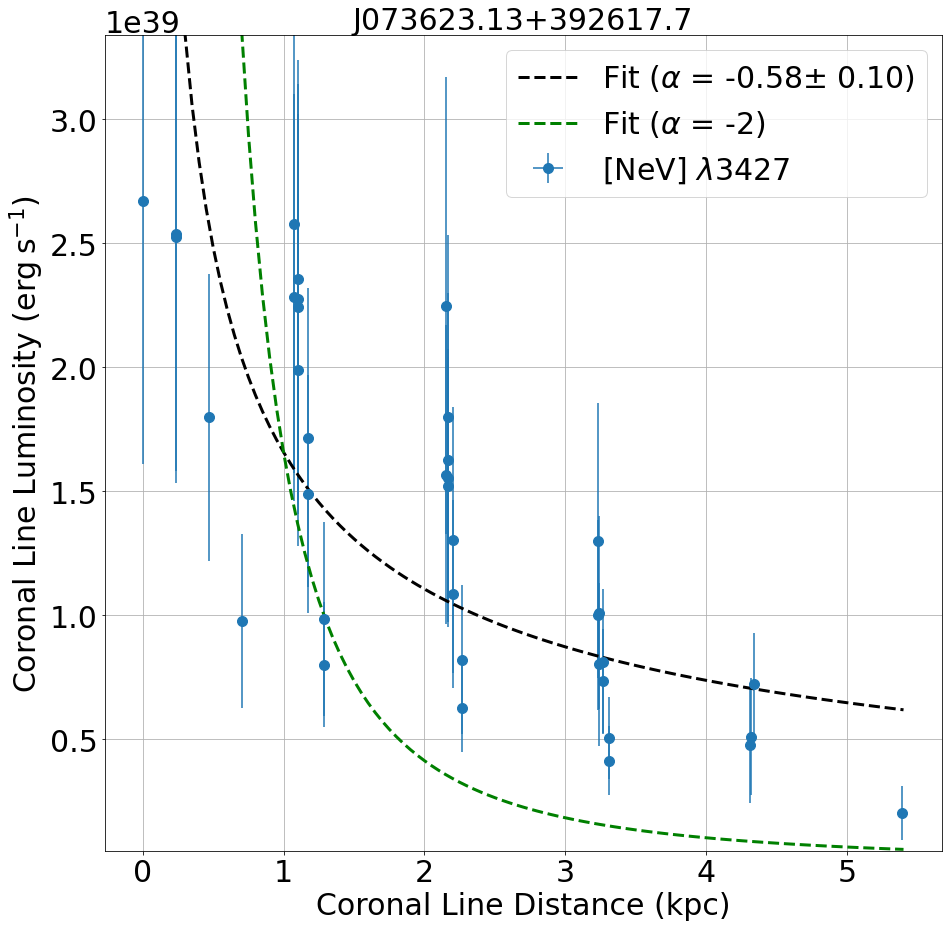

J205141.54+005135.4 0


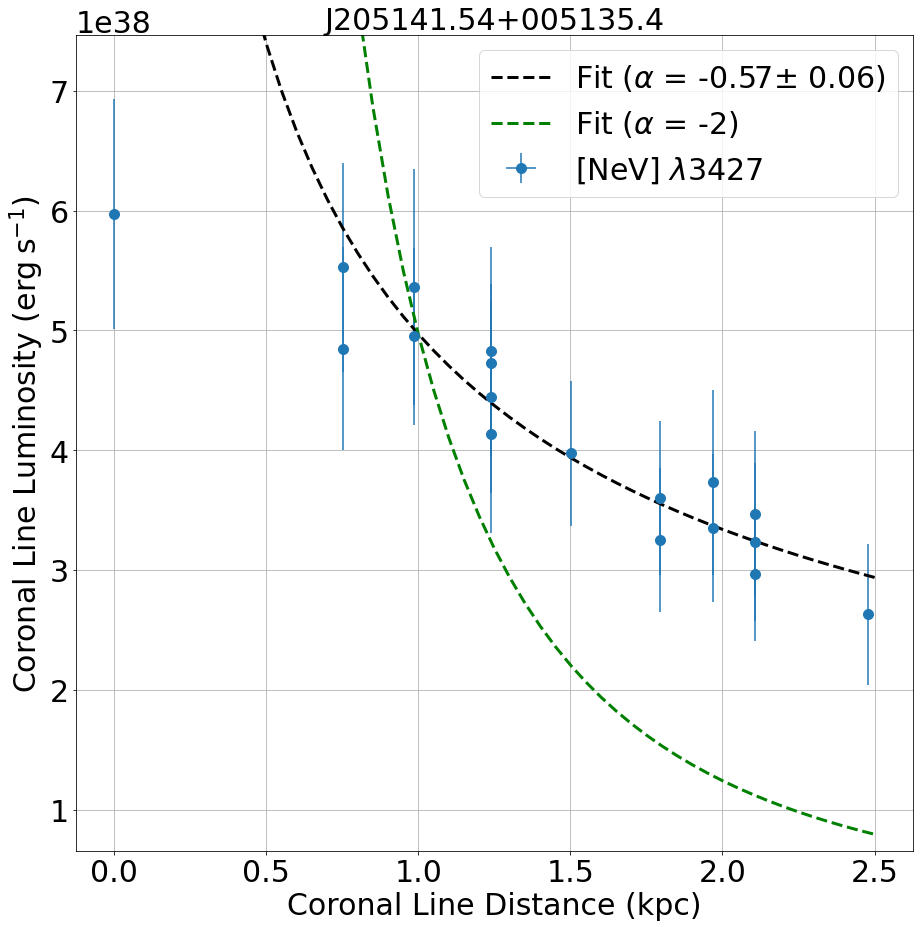

J171411.63+575834.0 0


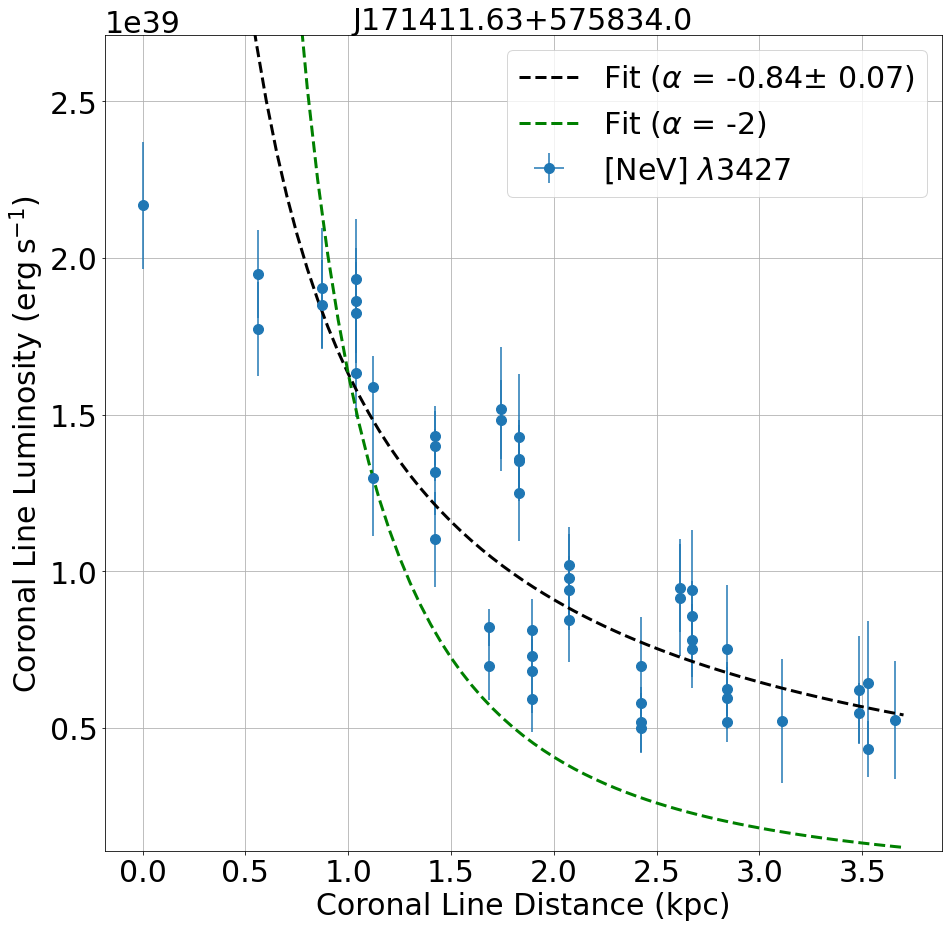

J161413.20+260416.3 1073742080


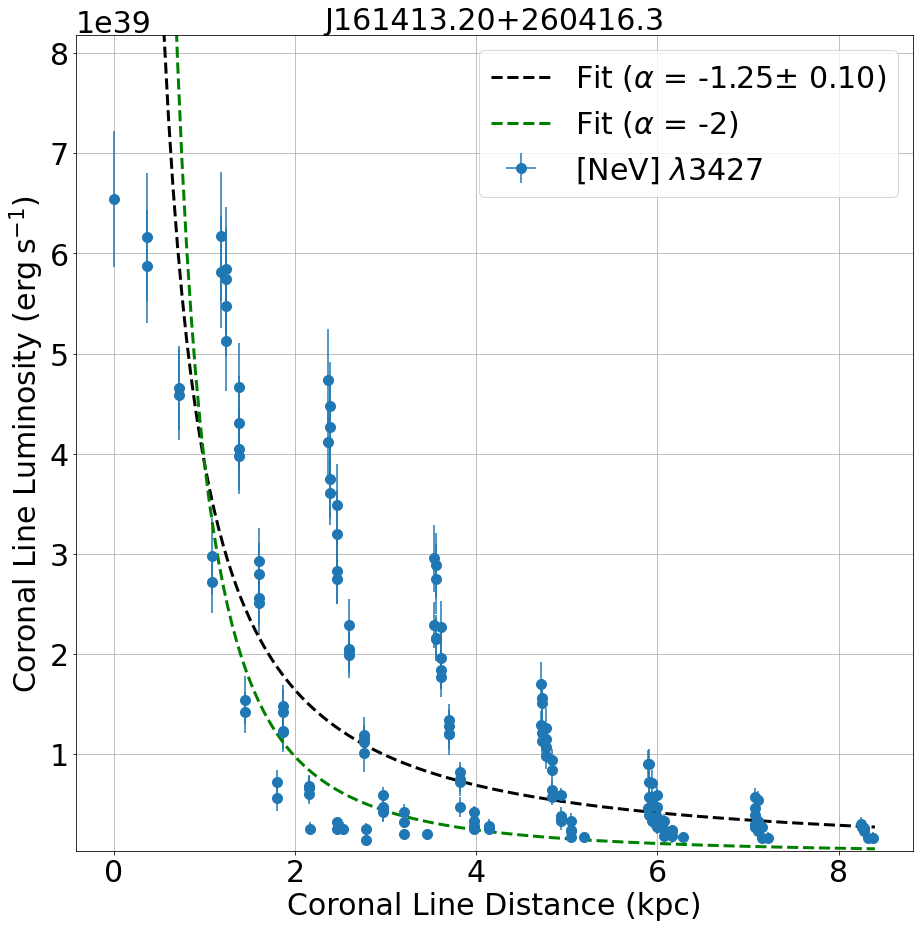

J075217.84+193542.2 1073742144


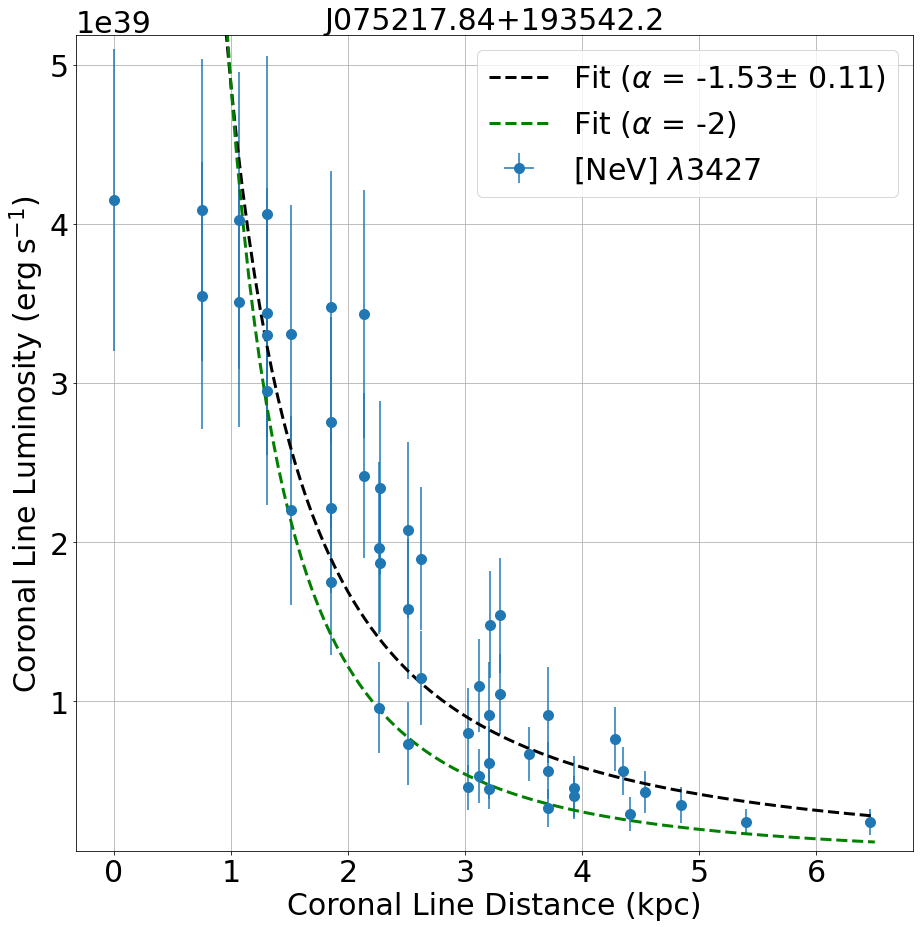

J080630.89+234237.6 0
J090659.46+204810.0 0


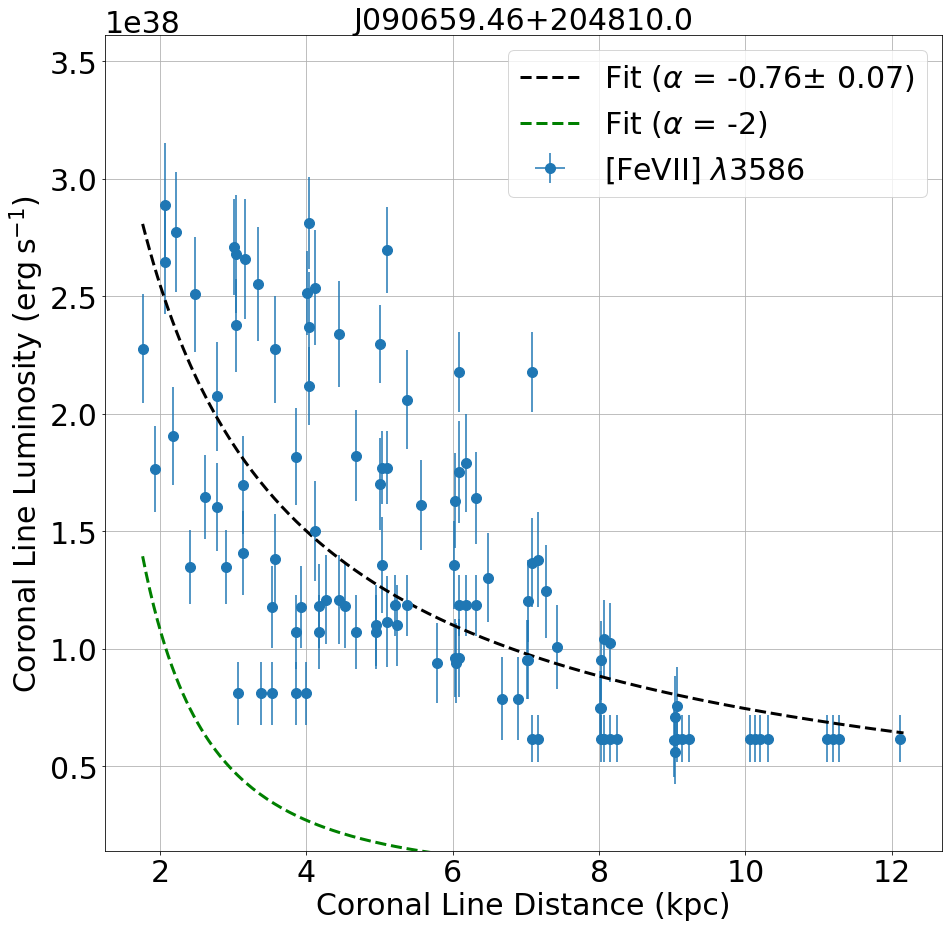

J030903.05-005450.3 0
J030859.49-004736.0 0
J213405.08+102518.5 0
J134918.20+240544.9 0


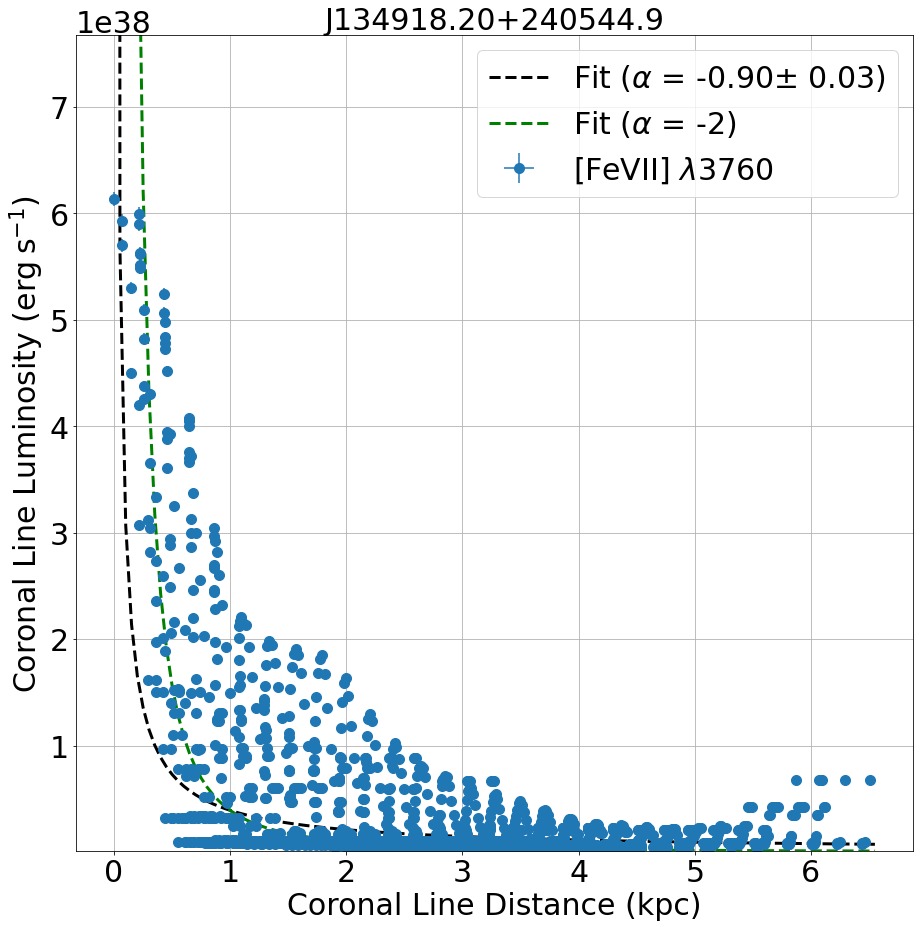

J145420.10+470022.3 0
J090138.80+274002.9 0
J103610.02+503218.2 0
J153010.77+474915.9 0
J153552.40+575409.4 0


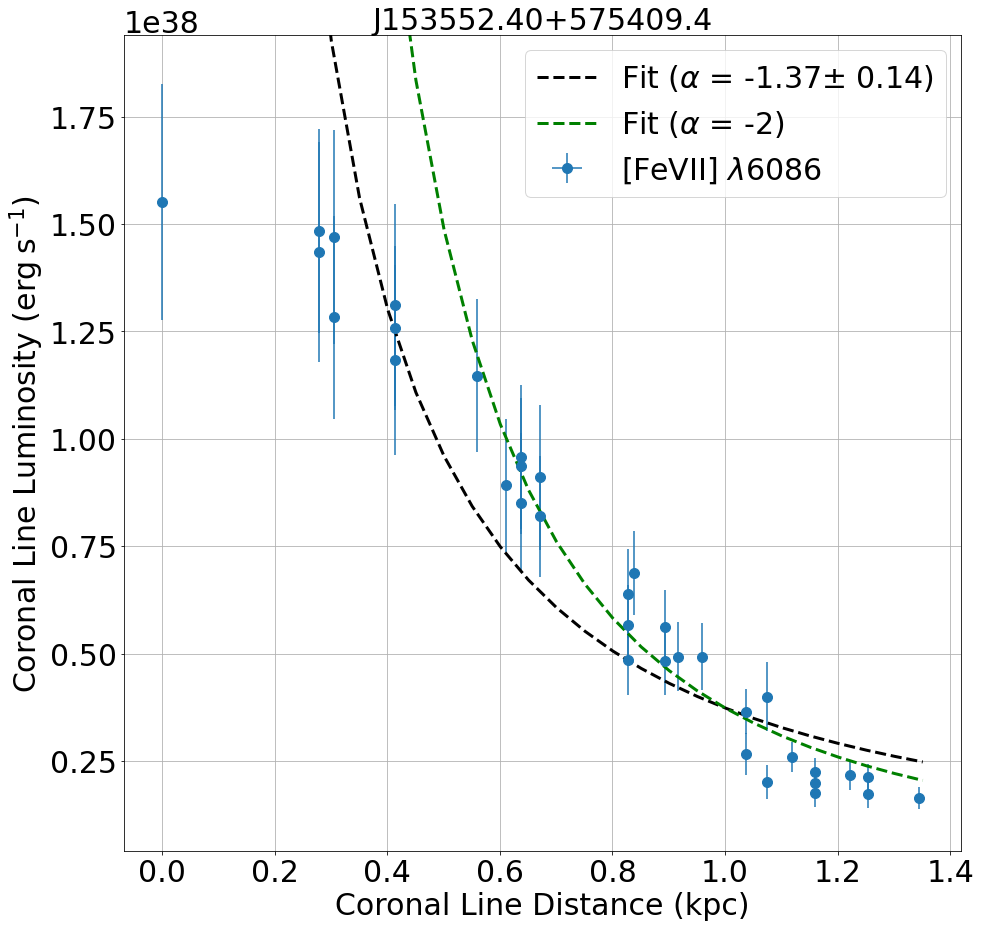

J171411.63+575834.0 0


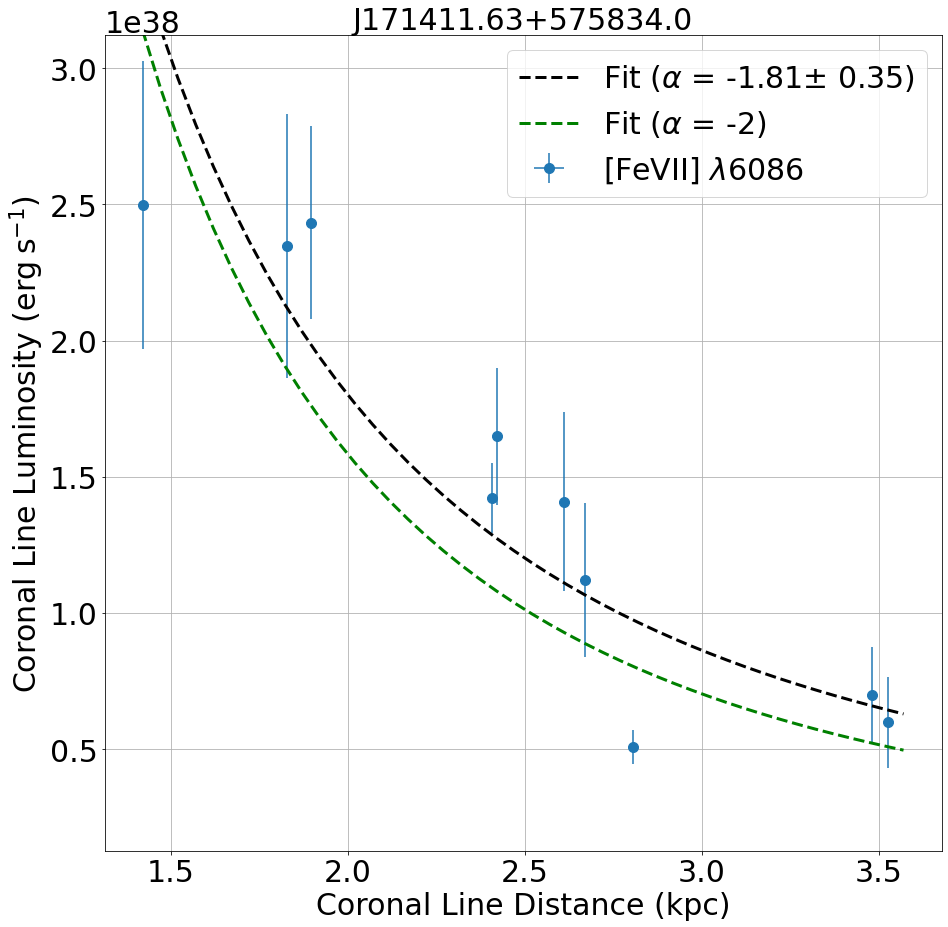

J144010.49+530600.6 0
J160037.49+240248.4 64
J080338.54+253101.1 2
J210607.89-004756.6 0
J154147.27+453321.6 64


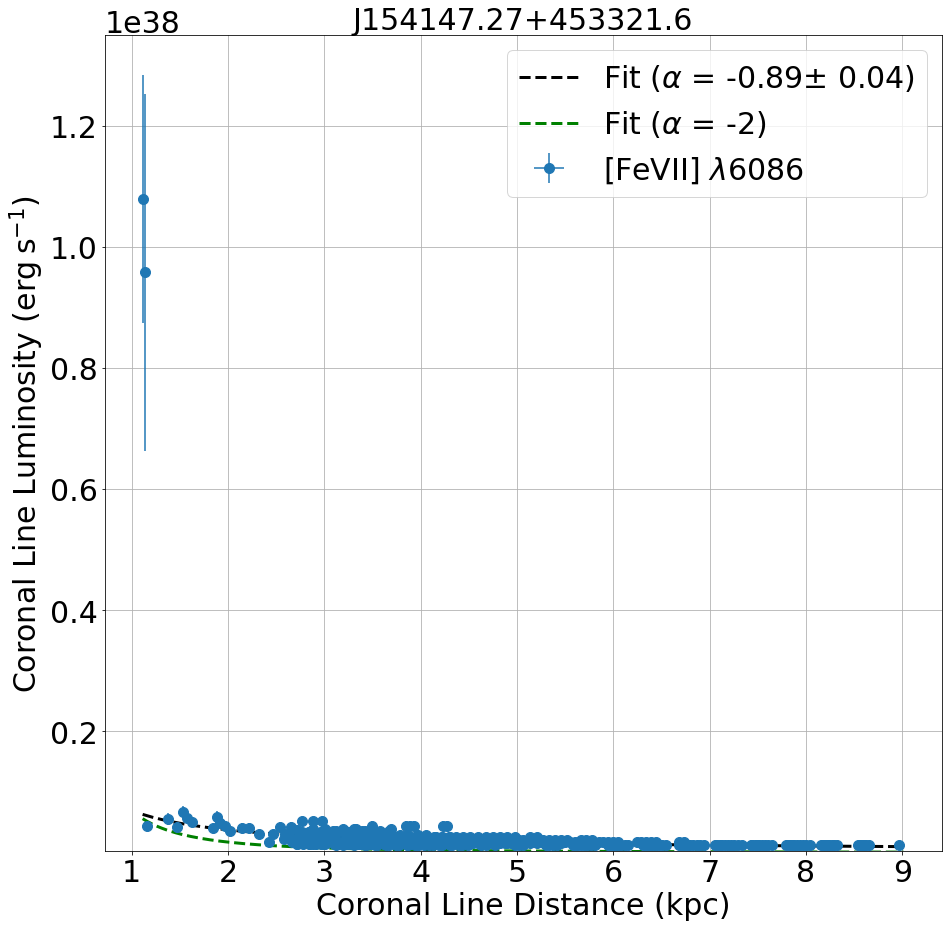

J075234.92+525048.6 0
J102855.04+395340.9 0
J171458.24+290818.5 0
J162332.74+390715.9 0
J021059.30+122144.5 64
J145123.60+512833.9 0
J031820.20-004928.7 0


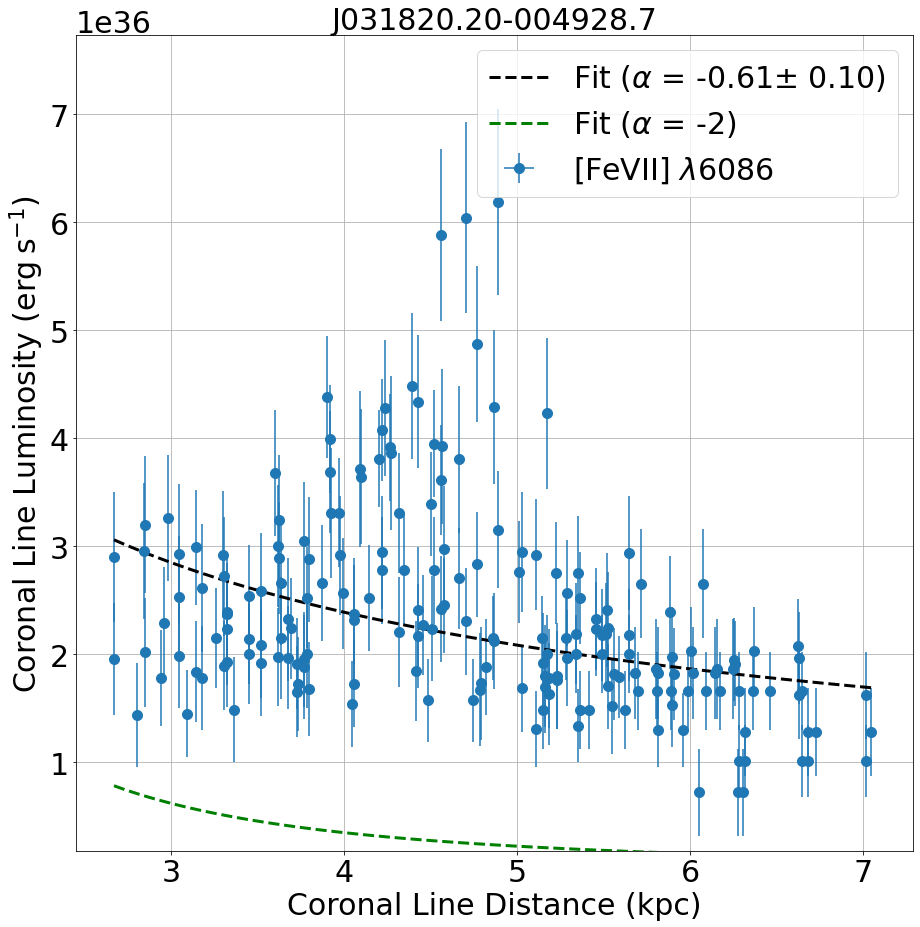

J115113.46+550659.1 0
J075454.46+535046.5 0
J092126.30+430607.8 0


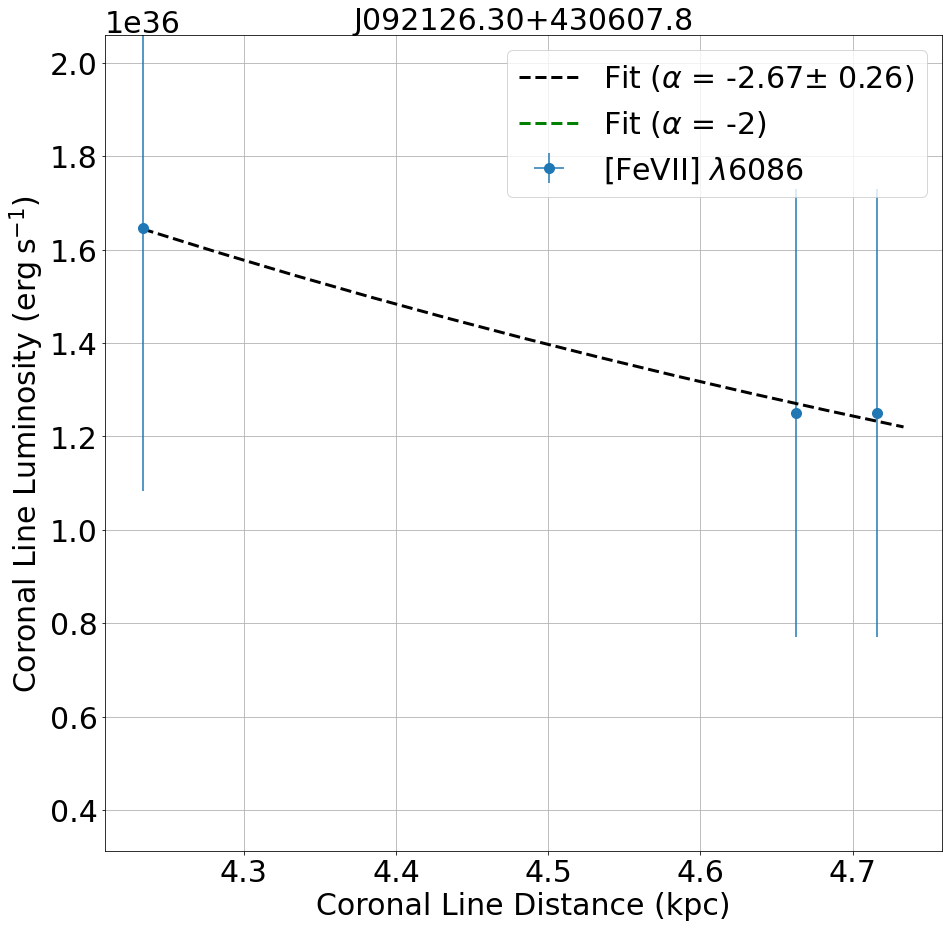

J162856.61+393634.2 0
J075645.07+353015.0 0
J131620.25+305236.7 0
J081020.37+171925.2 0


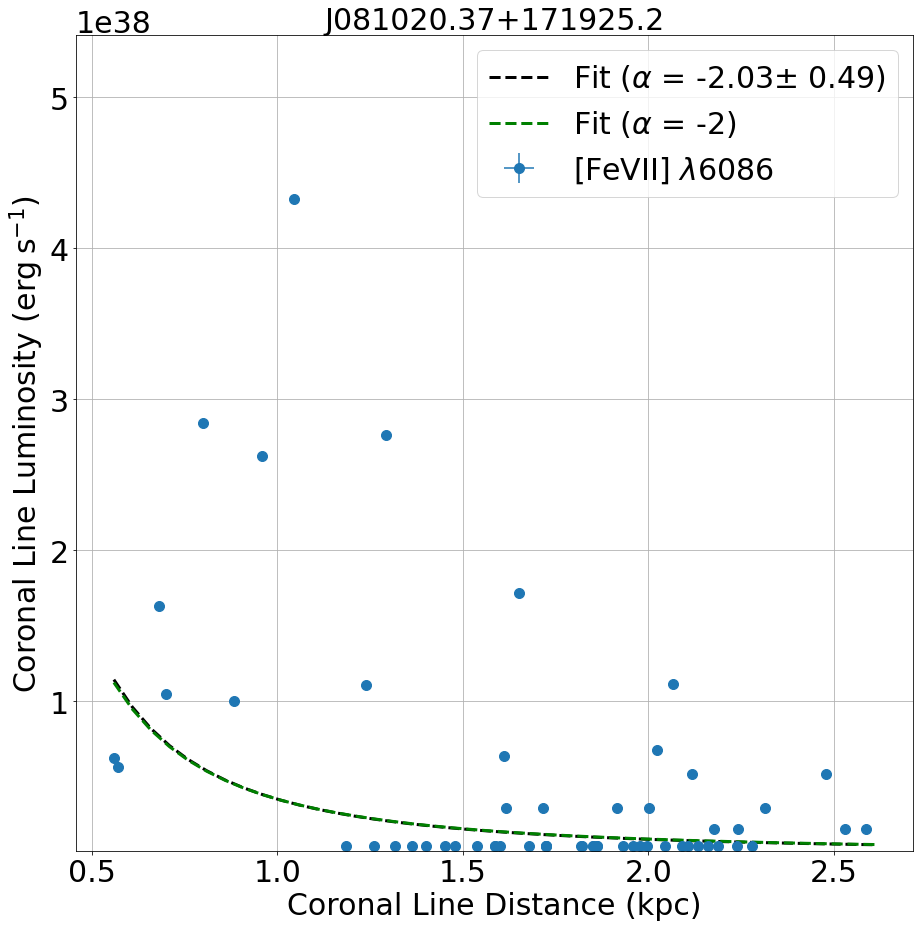

J170527.78+251215.9 0
J032208.60-005014.0 0
J003550.69+005209.5 0
J110624.79+512329.9 0
J153401.17+291347.6 0
J170900.44+345417.2 0
J110420.77+460321.9 0


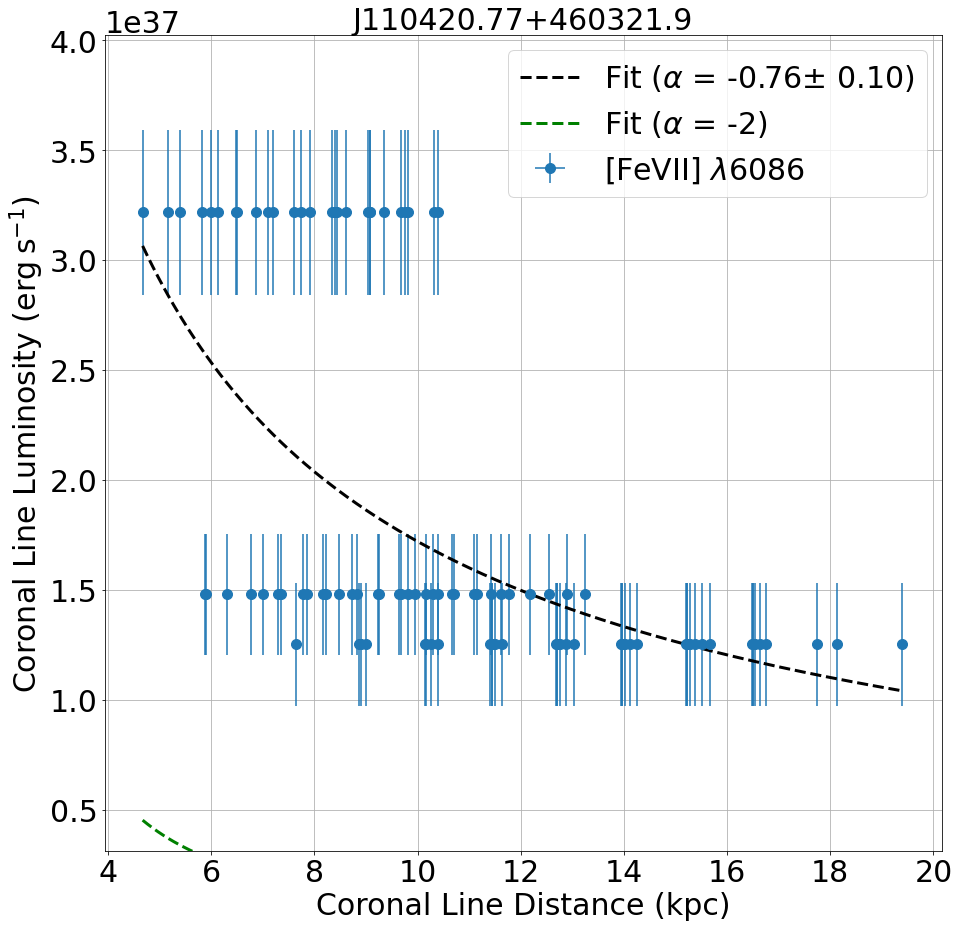

J212858.26+112159.3 0
J163124.94+394134.5 0
J033241.15-011100.9 2
J074543.49+320607.0 0
J030051.56+004826.5 1073742146


In [19]:
# Chapter 10a: Individual plotting CLF, Temperature, and Density

snr_iau = []
snr_frac_arr = []
iau_arr = []
flux_tot_arr = []
flux_tot_err_arr = []
lum_tot_arr = []
lum_tot_err_arr = []
cl_lum_mst_arr = []
cl_lum_mst_err_arr = []
oiii_bol_arr_err = []
bol_unc = []
flux_mst_arr = []
bol_mst_arr = []
bol_mst_err_arr = []
slope_arr = []
inc_arr = []
slope_err_arr = []
dummy = []
dummy_1 = []
dummy_2 = []

#cld_arr = []
# clf_arr = []
# clf_err_arr = []
# tem_arr = []
# den_arr = []
# oiii_bol_arr = []
# cl_lum_arr = []
# cl_lum_err_arr = []

def plots(emline, marker, lbl):

    directory = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline)
    
    data_file = ('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline + '%s'%emline + '_params.csv')
    data = pd.read_csv(data_file, dtype=str)
    df = pd.DataFrame(data)
    
#     temp_den_path = ('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline + '%s'%emline + '_temp_params.csv')
#     temp_den_data = pd.read_csv(temp_den_path, dtype=str)
#     df_temp_den = pd.DataFrame(temp_den_data)
    
    path_file = '/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/' + '%s/' %emline + emline + '_summed_params.csv'
    file_path = pd.read_csv(path_file)
    df2 = pd.DataFrame(file_path)
#     slope_arr = []
#     slope_err_arr = []
#     bol_mst_arr = []
#     bol_mst_err_arr = []
#     cl_lum_mst_arr = []
#     cl_lum_mst_err_arr = []
   # snr_frac_arr = []
    for j in directory:
        
        cld_arr = []
        cld_err_arr = []
        clf_arr = []
        clf_err_arr = []
        tem_arr = []
        den_arr = []
        oiii_bol_arr = []
        oiii_bol_err_arr = []
        #oiii_bol_arr_err = []
        oiii_flux = []
        oiii_flux_err = []
        cl_lum_arr = []
        cl_lum_err_arr = []
        power_law_arr = []
        oiii_lum_arr = []
        oiii_lum_unc_arr = []
        place = []
        place2 = []


        
        if j[0] == 'J':
            
            arr_arr = []

            ind = np.where(tbdata['nsa_iauname'] == str(j))
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] 
            bit = tbdata['MNGTARG1'][ind][0]
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            ldist = tbdata_1['LDIST_Z'][ind_2][1]
            ba = tbdata_1['nsa_sersic_ba'][ind_2][1]
            pa_el = tbdata_1['NSA_ELPETRO_PHI'][ind_2][1]
            bit_mask = tbdata_1['DRP3QUAL'][ind_2][1]
                        
            print (iau + ' ' + str(bit_mask))
            inc = np.arccos(ba)*(180/np.pi)
            inc_arr.append(inc)
            
#             if iau in iau_arr:
#                 print (iau)
#             iau_arr.append(iau)


            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':

                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            

            logcube = fits.open('output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
            maps = fits.open('output/fits/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            
            flux_import = logcube[1].data
            spaxel1,spaxel2,spaxel3 = flux_import.shape
            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"

            
            kpc_val = 10/spxl_size_conversion
            kpc_round = round(float(kpc_val), 2)

            # CLF and SNR 

            clf_array = np.zeros((spaxel2, spaxel3))
            clf_err_array = np.zeros((spaxel2, spaxel3))
            cl_lum_array = np.zeros((spaxel2, spaxel3))
            cl_lum_err_array = np.zeros((spaxel2, spaxel3))
            
            snr_array = np.zeros((spaxel2, spaxel3))
            bol_spx_array = np.zeros((spaxel2, spaxel3))

            arr_loc  = df.loc[df['IAU'] == j, ['Array Location']]

            arr_loc_values = arr_loc.values
            count = 0
            count_2 = 0

            psf = file_path.loc[file_path['IAU'] == iau,['psf']].squeeze()
            
#             df_2 = pd.read_csv(path_file)
#             df_2['cld_err'] = file_path['psf']/2.5 
#             df_2.to_csv(path_file, index=False)
            

            for k in arr_loc_values:
                count_2 += 1
                #k_str = str(k[0])
                x_spx_str = k[0][0:2]
                y_spx_str = k[0][2:4]
                x_int = int(x_spx_str)
                y_int = int(y_spx_str)
                clf = df.loc[(df['IAU'] == j) & (df['Array Location'] == k[0]) , 'Total Flux (ergs/s cm^2/A/spaxel)'].to_string(index=False)
                snr = df.loc[(df['IAU'] == j) & (df['Array Location'] == k[0]) , 'SNR Ratio'].to_string(index=False)
                clf_err = df.loc[(df['IAU'] == j) & (df['Array Location'] == k [0]) , 'Flux Uncertainty (ergs/s cm^2/A/spaxel)'].to_string(index=False)
                
#                 clf_1 = df.loc[(df['IAU'] == j) & (df['Array Location'] == k[0]) , 'Total Flux (ergs/s cm^2/A/spaxel)'].to_string(index=False)
                cld = df.loc[(df['IAU'] == j) & (df['Array Location'] == k[0]) , 'Coronal Line Distance (kpc)'].to_string(index=False)
                d_unc = psf/2.5
                
                #placeholder
                oiii_flux_spx = maps['EMLINE_GFLUX'].data[13,x_int,y_int]*10**-17
                

                if oiii_flux_spx == 0:
                    continue
                else:
                    oiii_flux_spx_er = np.sqrt(1/(maps['EMLINE_GFLUX_IVAR'].data[13,x_int,y_int]))*10**-17

                oiii_lum = 4*math.pi*((ldist*3.086*(10**24))**2)*oiii_flux_spx
                oiii_unc = 4*math.pi*((ldist*3.086*(10**24))**2)*oiii_flux_spx_er
                
                
                y = 0.5617
                dy = 0.0978
                z = 21.186
                dz = 4.164
                x = oiii_lum
                dx = oiii_unc
                
                oiii_bol = (oiii_lum**0.5617)*(10**21.186)
                oiii_bol_0 = oiii_lum*np.sqrt(np.square(dx/x) + np.square(dy/y) + np.square(dz/z))
#                 oiii_bol_0 = np.sqrt(((10**z)*y*(x**(y - 1))*oiii_unc)**2 + 
#                                      ((10**z)*(x**y)*(np.log(x))*dy)**2 + 
#                                      ((x**y)*(10**z)*(np.log(10))*dz)**2)
                #oiii_bol_0 = (oiii_unc**0.5617)*(10**21.186)
                #print (oiii_bol, oiii_bol_0)

                cl_lum = 4*math.pi*(ldist*3.086*(10**24))**2*float(clf)*10**-17

                cl_lum_err_0 = cl_lum*np.sqrt(np.square(float(clf_err)/float(clf)))
            
                if float(snr) > 0.4:
                    snr_array[x_int,y_int] = snr
                    count += 1

                else:
                    snr = 0
                    snr_array[x_int,y_int] = snr

                cld_arr.append(float(cld))
                cld_err_arr.append(d_unc)
                clf_arr.append(float(clf))
                clf_err_arr.append(float(clf_err))
                cl_lum_err_arr.append(cl_lum_err_0)
                oiii_flux.append(float(oiii_flux_spx))
                oiii_flux_err.append(float(oiii_flux_spx_er))
                oiii_bol_arr.append(float(oiii_bol))
                oiii_bol_err_arr.append(float(oiii_bol_0))
                oiii_lum_arr.append(oiii_lum)
                oiii_lum_unc_arr.append(oiii_unc)
                cl_lum_arr.append(float(cl_lum))
                #cl_lum_err_arr.append(float(cl_lum_err))
                
                clf_array[x_int,y_int] = clf
                clf_err_array[x_int,y_int] = clf_err
                cl_lum_array = cl_lum
                cl_lum_err_array = cl_lum_err_0
                bol_spx_array[x_int,y_int] = oiii_bol
            
            cl_lum_mst_arr.append(np.sum(cl_lum_arr))     
            cl_lum_mst_err_arr.append(np.sqrt(np.sum(np.square(cl_lum_err_arr))))
            
            
            bol_tot = np.sum(oiii_bol_arr)
            bol_mst_arr.append(bol_tot)
            
            bol_tot_err = np.sqrt(np.sum(np.square(oiii_bol_err_arr)))
            bol_mst_err_arr.append(bol_tot_err)
            
            #print (bol_tot, bol_tot_err)
            
            
            
            
    #print (cl_lum_mst_arr, cl_lum_mst_err_arr)
    
#     df_2 = pd.read_csv(path_file)
#     df_2['Total Luminosity (erg/s)'] = cl_lum_mst_arr
#     df_2['Luminosity Uncertainty (ergs/s)'] = cl_lum_mst_err_arr
#     df_2.to_csv(path_file, index=False)  
            
            #             determining the fraction of SNR spaxels amongst CL spaxels. 
            if np.sum(snr_array) > 0:
                snr_frac = count/count_2
                #if snr_frac > 0.5:
#                     print (iau + ' yes')
                dummy.append(count)
                dummy_1.append(np.sum(cl_lum_arr))
                dummy_2.append(np.sqrt(np.sum(np.square(cl_lum_err_arr))))
                #print (snr_frac)
                snr_frac_arr.append(snr_frac)
            else:
                snr_frac = 0
                #print (snr_frac)
                #snr_frac_arr.append(snr_frac)
                

#             bol_unc = np.sqrt(np.sum(np.square(oiii_lum_unc_arr)))
#             bol_err = (bol_unc**(0.5617))*(10**(21.186))
#             bol_mst_err_arr.append(bol_err)

#             oiii_squares = []    
#             for i in range (0, len (oiii_flux)):
#                 try: 
#                     square = np.divide(np.square(oiii_flux_err[i]),np.square(oiii_flux[i]))
#                     oiii_squares.append(square)
#                 except RuntimeWarning:
#                     continue

#             oiii_flux_err = np.array(oiii_flux_err)
#             oiii_flux = np.array(oiii_flux)
        
#             oiii_flux_err_new = oiii_flux_err[oiii_flux_err.nonzero()]
#             oiii_flux_new = oiii_flux[oiii_flux.nonzero()]
    
#             bol_unc = np.sum(oiii_lum_arr)*np.sqrt(np.sum(np.divide(np.square(oiii_flux_err_new),np.square(oiii_flux_new))))

#             bol_err_up = (bol_unc**(0.5617 + 0.0978))*(10**(21.186 + 4.164))
#             bol_err_down = (bol_unc**(0.5617 - 0.0978))*(10**(21.186 - 4.164))
#             #bol_err = bol_err_up - bol_err_down
#             bol_err = (bol_unc**(0.5617))*(10**(21.186))
#             bol_mst_err_arr.append(bol_err)

        

#             #flux_mst_arr = np.sum(clf_arr)
#             cl_lum_mst_arr.append(np.sum(cl_lum_arr))     
#             #flux_unc = np.sqrt(np.sum(np.square(clf_err_arr)))
#             #cl_lum_err = np.sum(cl_lum_arr) * np.sqrt(np.square(flux_unc/flux_mst_arr))
#             cl_lum_err = np.sqrt(np.sum(np.square(cl_lum_err_arr)))
#             cl_lum_mst_err_arr.append(cl_lum_err)
            
            
#             print (bol_mst_arr)
            
#             BOL = pd.DataFrame(bol_mst_arr)
#             path_sfr_0 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/' + '%s/' %emline + emline + '_summed_params.csv'
#             file_0 = pd.read_csv(path_sfr_0)
#             file_0['Bolometric Luminosity (ergs/s)'] = BOL
#             file_0.to_csv(path_sfr_0, index=False)
            
           

        
    #                 lum_tot_arr.append(np.sum(cl_lum_array))
    #                 lum_tot_err_arr.append(np.sum(cl_lum_err_array))

    #                 if iau not in snr_iau:
    #                     snr_iau.append(iau)
               
            
        
            
#             print (iau + ' ' + emline + ' ' + str(np.sum(oiii_bol_arr)))

#     print (iau + ' ' + str(bol_mst_arr))
#     df_2 = pd.read_csv(path_file)
#     df_2['SNF'] = bol_mst_arr
#     df_2.to_csv(path_file, index=False)

#     print (iau + ' ' + str(bol_mst_arr))
#     df_2 = pd.read_csv(path_file)
#     df_2['Bolometric Luminosity (ergs/s)'] = bol_mst_arr
#     df_2['Coronal Line Luminosity (ergs/s)'] = cl_lum_mst_arr
#     df_2['Coronal Line Luminosity Uncertainty (ergs/s)'] = cl_lum_mst_err_arr
#     df_2.to_csv(path_file, index=False)
            

            #Temperature and Density

            temp_array = np.zeros((spaxel2, spaxel3))
            den_array = np.zeros((spaxel2, spaxel3))    
            arr_temp_den  = df_temp_den.loc[df_temp_den['IAU'] == j, ['Array Location']]
            arr_val = arr_temp_den.values

            for l in arr_val:
                x_spx_str = l[0][0:2]
                y_spx_str = l[0][2:4]
                x_int = int(x_spx_str)
                y_int = int(y_spx_str)
                temp = df_temp_den.loc[(df_temp_den['IAU'] == j) & (df_temp_den['Array Location'] == l[0]) , 'Temperature (K)'].to_string(index=False)
                den = df_temp_den.loc[(df_temp_den['IAU'] == j) & (df_temp_den['Array Location'] == l[0]) , 'Density (cm^-3)'].to_string(index=False)
                temp_array[x_int,y_int] = temp 
                den_array[x_int,y_int] = den
                
                tem_arr.append(temp)
                den_arr.append(den)

    
#             if not os.path.exists('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/'):
#                  os.makedirs('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/') 
            if iau == 'J160037.49+240248.4' or iau == 'J080338.54+253101.1' or iau == 'J115113.46+550659.1':
                slope = 0
                slope_err = 0
                slope_arr.append(slope)
                slope_err_arr.append(slope_err)
                #print (slope, slope_err)
                continue
    
            try: 
                df_tot = pd.DataFrame({'x':np.log(cld_arr), 'y':np.log(cl_lum_arr)})
                model = ols('y~x', data=df_tot).fit()
            except RuntimeWarning:
                x = []
                for i in cld_arr:
                    try:
                        x.append(np.log(i))
                    except RuntimeWarning:
                        x.append(i)
                        
                
                df_tot = pd.DataFrame({'x':x, 'y':np.log(cl_lum_arr)})
                model = ols('y~x', data=df_tot).fit()
                        

            y_int = model.params[0]
            y_int_err = model.bse[0]
            slope = model.params[1]
            slope_arr.append(slope)
            slope_err = model.bse[1]
            slope_err_arr.append(slope_err)
            
            #print (slope, slope_err)
            
            cld_max = cld_arr[np.argmax(cld_arr)]
            cld_min = cld_arr[np.argmin(cld_arr)]
            lum_max = cl_lum_arr[np.argmax(cl_lum_arr)]
            lum_min = cl_lum_arr[np.argmin(cl_lum_arr)]
            if cld_min == 0.0:
                cld_min = 0.001

            d_range = np.arange(cld_min,cld_max + 0.05, .05)
            
            plaw = np.exp(y_int)*(np.power(d_range,slope))
            plaw_2 = np.exp(y_int)*(np.power(d_range,-2))
            
            if slope < -0.57:
                
            
                fs = 30
                matplotlib.rcParams.update({'font.size': fs})
                plt.figure(figsize=(15,15))
                plt.title(iau, fontsize = fs)
                plt.errorbar(cld_arr, cl_lum_arr, yerr = cl_lum_err_arr, xerr = 0, fmt='o', label = lbl, markersize = 10)
                plt.xlabel ('Coronal Line Distance (kpc)', fontsize = fs)
                plt.ylabel('Coronal Line Luminosity ' + r'$(\rm{erg} \> \rm{s}^{-1})$', fontsize = fs)
                plt.plot(d_range, plaw, lw=3, linestyle = '--', color = 'k', label = r'Fit ($\alpha$ = %s'%'{0:.2f}'.format(slope) + '$\pm$ %s'%'{0:.2f}'.format(slope_err) + ')')
                plt.plot(d_range, plaw_2, lw=3, linestyle = '--', color = 'g', label = r'Fit ($\alpha$ = -2)')
                plt.ylim(top=lum_max*1.25)
                plt.ylim(bottom=lum_min*0.25)
                plt.legend(fontsize = fs)
                plt.grid(True)
                plt.tick_params(labelsize=fs)
                #plt.yscale('log')
                #plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'clf_cld.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
                #plt.xscale('log')
                plt.show()
                plt.close()
#     print (bol_mst_err_arr) 
#     print (cl_lum_mst_arr)
#     df_2 = pd.read_csv(path_file)
#     df_2['Total Luminosity (erg/s)'] = cl_lum_mst_arr
#     df_2['Luminosity Uncertainty (ergs/s)'] = cl_lum_mst_err_arr
#     df_2.to_csv(path_file, index=False)  
    
    
#     print (snr_frac_arr)
#     df_2 = pd.read_csv(path_file)
#     df_2['snf'] = snr_frac_arr
#     df_2.to_csv(path_file, index=False)  

#     df_2 = pd.read_csv(path_file)
#     df_2['alpha'] = slope_arr
#     df_2['alpha_err'] = slope_err_arr
#     df_2.to_csv(path_file, index=False)  

#             fs = 30
#             fig, ax = plt.subplots(figsize=(15,15))
#             img = ax.imshow(clf_array, cmap='magma', origin = 'lower')
#            # ax.set_title(iau, fontsize = fs)
#     #             ax.set_xlabel('kpc', fontsize=fs)
#     #             ax.set_ylabel('kpc', fontsize=fs)
#             ax.tick_params(labelsize = fs)
#             cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#             cb.ax.set_ylabel(ylabel = lbl + ' Flux ' + r'$\left(10^{-17}\>\rm{erg}\>\rm{s}^{-1} \> \rm{cm}^{-2}\> \AA^{-1}\right)$',size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             bar = AnchoredSizeBar(ax.transData, size=kpc_val, label="10 kpc", loc=3, frameon=False, 
#                                     fontproperties = fm.FontProperties(size=35, family='sans-serif'), pad=1.6,sep=4, color = 'w')
#             ax.add_artist(bar)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             plt.savefig('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/' + j + '_cl_flux.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             #plt.show()
#             plt.close()

#             fs = 30
#             fig, ax = plt.subplots(figsize=(15,15))
#             img = ax.imshow(snr_array, cmap='magma', origin = 'lower', vmin = 0.4)
#          #   ax.set_title(iau, fontsize = fs)
# #             ax.set_xlabel('kpc', fontsize=fs)
# #             ax.set_ylabel('kpc', fontsize=fs)
#             ax.tick_params(labelsize = fs)
#             cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#             cb.ax.set_ylabel(ylabel = r'$\frac{[\rm{SII}]\> \lambda 6717 + [\rm{SII}] \> \lambda6731}{\rm{H}\alpha}$',size=40)
#             cb.ax.tick_params(labelsize=fs)
#             bar = AnchoredSizeBar(ax.transData, size=kpc_val, label="10 kpc", loc=3, frameon=False, 
#                                     fontproperties = fm.FontProperties(size=35, family='sans-serif'), pad=1.6,sep=4, color = 'w')
#             ax.add_artist(bar)
        
#             ax.set_xticks([])
#             ax.set_yticks([])
#             plt.savefig('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/' + j + 'snr.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             #plt.show()
#             plt.close()
            
            
#             den_array = np.nan_to_num(den_array)
#             if np.sum(den_array) > 0:
                
#                 den_arr = np.asarray(den_arr)
#                 #print (np.average(test))
                
#                 den_arr = np.array(den_arr).astype(np.float)
                
#                 den_mean = np.nanmean(den_arr)
                
#                 #DEN = pd.DataFrame(den_mean)
                
#                 file = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + emline + '_summed_params.csv')
#                 file['Average Density'] = ''
#                 file.loc[file['IAU'] == iau, ['Average Density']] = den_mean
#                 file.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + emline + '_summed_params.csv', index=False)
                
                #print (iau + ' ' + emline + '; Average Density = ' + str(den_mean))
                
#                 fig, ax = plt.subplots(figsize=(15,15))
#                 img = ax.imshow(den_array, cmap='magma', origin = 'lower')
#                 #ax.set_title(iau, fontsize = fs)
#     #             ax.set_xlabel('kpc', fontsize=fs)
#     #             ax.set_ylabel('kpc', fontsize=fs)
#                 ax.tick_params(labelsize = fs)
#                 cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#                 cb.ax.set_ylabel(ylabel = 'Electron Density ' + r'($\rm{cm}^{-3}$)',size=fs)
#                 cb.ax.tick_params(labelsize=fs)
#                 bar = AnchoredSizeBar(ax.transData, size=kpc_val, label="10 kpc", loc=4, frameon=False, 
#                                         fontproperties = fm.FontProperties(size=35, family='sans-serif'), pad=1.6,sep=4, color = 'w')
#                 ax.add_artist(bar)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/' + j + '_density.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#                 #plt.show()
#                 plt.close()

                
            
#             temp_array = np.nan_to_num(temp_array)
#             if np.sum(temp_array) > 0:
                
# #                 tem_arr = np.asarray(tem_arr)
# #                 #print (np.average(test))
                
# #                 tem_arr = np.array(tem_arr).astype(np.float)
                
# #                 tem_mean = np.nanmean(tem_arr)
                
# #                 #TEM = pd.DataFrame(tem_mean)

# #                 file = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + emline + '_summed_params.csv')
# #                 file['Average Temperature'] = ''
# #                 file.loc[file['IAU'] == iau, ['Average Temperature']] = tem_mean
# #                 file.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + emline + '_summed_params.csv', index=False)
                
# #               #  print (iau + ' ' + emline + '; Average Temperature = ' + str(tem_mean) + '\n')
#                 fig, ax = plt.subplots(figsize=(15,15))
#                 img = ax.imshow(temp_array, cmap='magma', origin = 'lower')
#                 #ax.set_title(iau, fontsize = fs)
#     #             ax.set_xlabel('kpc', fontsize=fs)
#     #             ax.set_ylabel('kpc', fontsize=fs)
#                 ax.tick_params(labelsize = fs)
#                 cb = plt.colorbar(img, fraction=0.046, pad=0.04, orientation="vertical")
#                 cb.ax.set_ylabel(ylabel = 'Temperature (K)',size=fs)
#                 cb.ax.tick_params(labelsize=fs)
#                 bar = AnchoredSizeBar(ax.transData, size=kpc_val, label="10 kpc", loc=4, frameon=False, 
#                                         fontproperties = fm.FontProperties(size=35, family='sans-serif'), pad=1.6,sep=4, color = 'w')
#                 ax.add_artist(bar)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig('output/5_sigma/%s/'%emline + '%s/'%j + 'maps/' + j + '_temp.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#                 #plt.show()
#                 plt.close()
    
    return; 

plots(emline = 'NeV_3346.79A', lbl = '[NeV] $\lambda$3347', marker = 'b^')
plots(emline = 'NeV_3426.85A', lbl = '[NeV] $\lambda$3427', marker = 'r^')
plots(emline = 'FeVII_3586A', lbl = '[FeVII] $\lambda$3586', marker = 'k^')
plots(emline = 'FeVII_3760A', lbl = '[FeVII] $\lambda$3760', marker = 'c^')
plots(emline = 'FeVII_6086A', lbl = '[FeVII] $\lambda$6086', marker = 'm^')
plots(emline = 'FeX_6374A', lbl = '[FeX] $\lambda$6374', marker = 'g^')



In [85]:
#Chapter 10b: Sample-wide plotting CLF, Temperature, and Density

# corr, _ = stats.pearsonr(slope_arr,  cl_lum_mst_arr)
# print('Pearsons correlation: %.3f' % corr)
# # print (np.average(slope_arr))

# fs = 30
# plt.figure(figsize=(15,15))
# plt.errorbar(slope_arr, cl_lum_mst_arr, yerr = cl_lum_mst_err_arr, xerr = slope_err_arr, fmt='o', markersize = 10)
# plt.ylabel ('Coronal Line Luminosity ' + r'($\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# plt.xlabel ('Slope', fontsize = fs)
# #plt.text(475,3e36, 'Pearson Correlation: %.3f' % corr, size = 30)
# #plt.yscale('log')
# #plt.xscale('log')
# plt.tick_params(labelsize=fs)
# plt.grid(True)
# #plt.tight_layout()
# #plt.savefig('output/5_sigma/figures/lum_slope.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# fs = 30
# plt.figure(figsize=(15,15))
# plt.errorbar(inc_arr, slope_arr, yerr = slope_err_arr, xerr = 0, fmt='o', markersize = 10)
# plt.ylabel ('Slope', fontsize = fs)
# plt.xlabel('Inclination', fontsize = fs)
# #plt.text(475,3e36, 'Pearson Correlation: %.3f' % corr, size = 30)
# #plt.yscale('log')
# #plt.xscale('log')
# plt.tick_params(labelsize=fs)
# plt.grid(True)
# #plt.tight_layout()
# plt.savefig('output/5_sigma/figures/slope_inclination.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# fs = 30
# plt.figure(figsize=(15,15))
# plt.errorbar(dummy, dummy_1, yerr = dummy_2, xerr = 0, fmt='o', markersize = 10)
# plt.ylabel ('Coronal Line Luminosity ' + r'($\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# plt.xlabel('SNR Spaxels in CLR', fontsize = fs)
# plt.text(475,3e36, 'Pearson Correlation: %.3f' % corr, size = 30)
# plt.yscale('log')
# #plt.xscale('log')
# plt.tick_params(labelsize=fs)
# plt.grid(True)
# #plt.tight_layout()
# plt.savefig('output/5_sigma/figures/snr_spaxels.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# fs = 30
# plt.figure(figsize=(15,15))
# plt.errorbar(slope_arr, cl_lum_mst_arr, yerr = cl_lum_mst_err_arr, xerr = slope_err_arr, fmt='o', markersize = 10)
# plt.ylabel ('Coronal Line Luminosity ' + r'($\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# plt.xlabel('Slope', fontsize = fs)
# #plt.text(2.5e36,1e46, 'Pearson Correlation: %.3f' % corr, size = 30)
# plt.yscale('log')
# #plt.xscale('log')
# plt.tick_params(labelsize=fs)
# plt.grid(True)
# #plt.tight_layout()
# #plt.savefig('output/5_sigma/figures/cl_lum_bol.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# print (len(cl_lum_mst_arr), len(bol_mst_arr))
# fs = 30
# plt.figure(figsize=(15,15))
# plt.errorbar(cl_lum_mst_arr, bol_mst_arr, xerr = cl_lum_mst_err_arr, yerr = bol_mst_err_arr, fmt='o', markersize = 10)
# plt.xlabel ('Coronal Line Luminosity ' + r'($\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# plt.ylabel('Bolometric Luminosity ' +  r'($\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# plt.tick_params(labelsize=fs)
# plt.grid(True)
# #plt.text(2.5e36,1e46, 'Pearson Correlation: %.3f' % corr, size = 30)
# plt.yscale('log')
# plt.xscale('log')
# #plt.savefig('output/5_sigma/figures/cl_lum_bol.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# f = open('master_lum.csv', 'a')
# f.write('CL Luminosity' + ',' + 'CL Luminosity Error' + ',' + 'Distance')
# f.close()

# # cl_lum_arr = np.array(cl_lum_arr)
# # cld_arr = np.array(cld_arr)
# # cl_lum_err_arr = np.array(cl_lum_err_arr)

# LUM = pd.DataFrame(cl_lum_arr)
# LUM_ERR = pd.DataFrame(cl_lum_err_arr)
# DIS = pd.DataFrame(cld_arr)

# # # FLUX = pd.DataFrame(clf_arr)
# # # FLUX_ERR = pd.DataFrame(clf_err_arr)
# # DIS = pd.DataFrame(cld_arr)

# df = pd.read_csv('master_lum.csv', dtype = float)
# df['CL Luminosity'] = LUM[0]
# df['CL Luminosity Error'] = LUM_ERR[0]
# df['Distance'] = DIS[0]
# df.to_csv('master_lum.csv', index=False)

# df_tot = pd.DataFrame({'x':np.log(cld_arr), 'y':np.log(cl_lum_arr)})
# model = ols('y~x', data=df_tot).fit()
# model.summary()

#plaw = np.exp(85.4192)*(np.power(cld_arr,-0.6592))
# plaw_2 = np.exp(85.4192)*(np.power(cld_arr,-2))


# fs = 30
# matplotlib.rcParams.update({'font.size': fs})
# plt.figure(figsize=(15,15))
# #plt.title(lbl + ' ' + iau, fontsize = fs)
# plt.errorbar(cld_arr, cl_lum_arr, yerr = 0, xerr = 0, fmt='o', markersize = 7.5)
# plt.plot(cld_arr, plaw, lw=3, label = 'Fit', linestyle = '--', color = 'k')
# # plt.plot(cld_arr, plaw_2, lw=3, label = 'Fit', linestyle = '-.', color = 'g')
# plt.xlabel ('Coronal Line Distance (kpc)', fontsize = fs)
# plt.ylabel('Coronal Line Luminosity ' + r'$(\rm{erg} \> \rm{s}^{-1})$', fontsize = fs)
# #plt.legend(fontsize = fs)
# plt.grid(True)
# plt.tick_params(labelsize=fs)
# # plt.yscale('log')
# #plt.savefig('output/5_sigma/%s/'%emline + '%s/'%iau + 'clf_cld.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# # plt.xscale('log')
# plt.show()
# plt.close()

# #print(str(snr_iau) + ' Array Quantity = ' + str(len(snr_iau)))
# #print (str(snr_frac_arr) + ' Average = ' + str(np.average(snr_frac_arr)))
# corr, _ = stats.pearsonr(snr_frac_arr, cl_lum_mst_arr)
#print('Pearsons correlation: %.3f' % corr)
# print (len(cl_lum_mst_arr))

# corr, _ = stats.pearsonr(snr_frac_arr, dummy_1)
# print('Pearsons correlation: %.3f' % corr)

# print (len(snr_frac_arr), len(dummy_2))
# fs = 30
# plt.figure(figsize=(15,15))
# #plt.title(lbl + ' ' + iau, fontsize = fs)
# plt.errorbar(snr_frac_arr, dummy_1, yerr = dummy_2, xerr = 0, fmt='o', markersize = 10)
# plt.xlabel ('SNR Fraction', fontsize = fs)
# plt.ylabel('Coronal Line Luminosity (' + r'$\rm{erg} \> \rm{s}^{-1}$)', fontsize = fs)
# #plt.legend(fontsize = fs)
# plt.grid(True)
# plt.text(0.07,4e36, 'Pearson Correlation: %.2f' % corr, size = 30)
# plt.tick_params(labelsize=fs)
# plt.yscale('log')
# plt.savefig('output/5_sigma/figures/snr_lum.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

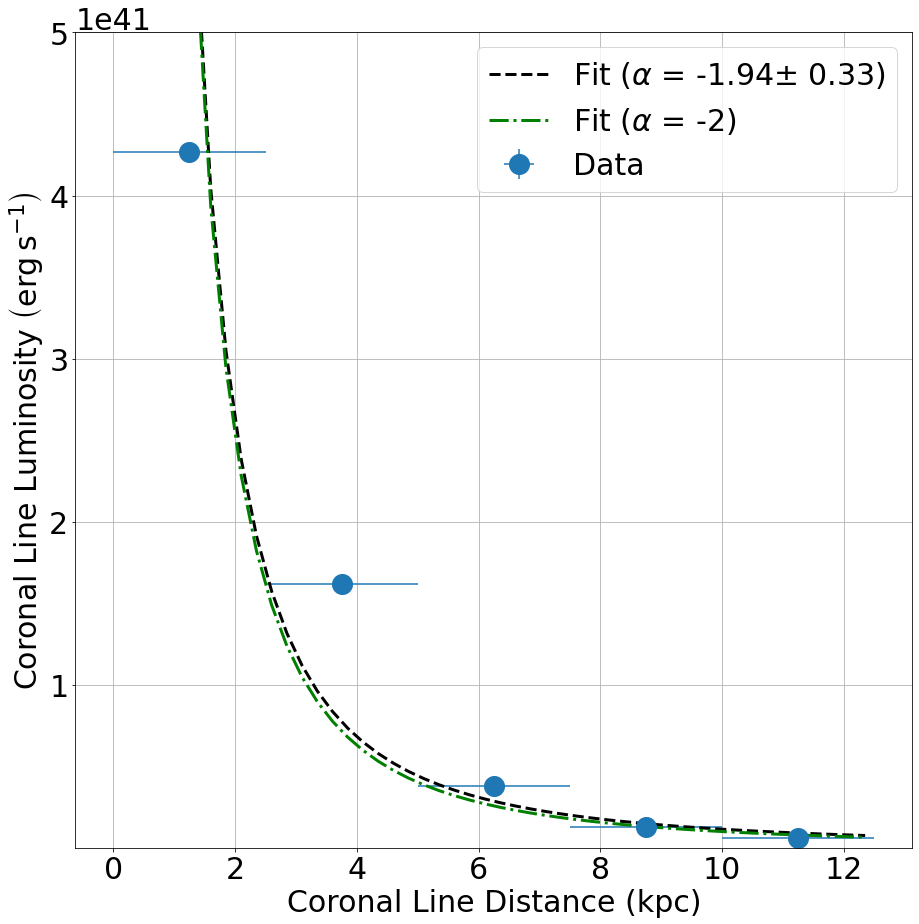

In [75]:
#Chapter 11: Histogram of Master Flux

data_file = ('master_lum.csv')
file = pd.read_csv(data_file, dtype=float)
df = pd.DataFrame(file)

two_five = df.loc[(df['Distance'] > 0) & (df['Distance'] < 2.5), 'CL Luminosity'].sum()
five = df.loc[(df['Distance'] > 2.5) & (df['Distance'] < 5), 'CL Luminosity'].sum()
seven_five = df.loc[(df['Distance'] > 5) & (df['Distance'] < 7.5), 'CL Luminosity'].sum()
ten = df.loc[(df['Distance'] > 7.5) & (df['Distance'] < 10), 'CL Luminosity'].sum()
twelve_five = df.loc[(df['Distance'] > 10) & (df['Distance'] < 12.5), 'CL Luminosity'].sum()
fifteen = df.loc[(df['Distance'] > 12.5) & (df['Distance'] < 15), 'CL Luminosity'].sum()
seventeen_five = df.loc[(df['Distance'] > 15) & (df['Distance'] < 17.5), 'CL Luminosity'].sum()
twenty = df.loc[(df['Distance'] > 17.5) & (df['Distance'] < 20), 'CL Luminosity'].sum()
twenty_two_five = df.loc[(df['Distance'] > 20) & (df['Distance'] < 22.5), 'CL Luminosity'].sum()
twenty_five = df.loc[(df['Distance'] > 22.5) & (df['Distance'] < 25), 'CL Luminosity'].sum()
twenty_seven_five = df.loc[(df['Distance'] > 25) & (df['Distance'] < 27.5), 'CL Luminosity'].sum()

two_five_er = df.loc[(df['Distance'] > 0) & (df['Distance'] < 2.5), 'CL Luminosity Error']
five_er = df.loc[(df['Distance'] > 2.5) & (df['Distance'] < 5), 'CL Luminosity Error']
seven_five_er = df.loc[(df['Distance'] > 5) & (df['Distance'] < 7.5), 'CL Luminosity Error']
ten_er = df.loc[(df['Distance'] > 7.5) & (df['Distance'] < 10), 'CL Luminosity Error']
twelve_five_er = df.loc[(df['Distance'] > 10) & (df['Distance'] < 12.5), 'CL Luminosity Error']
fifteen_er = df.loc[(df['Distance'] > 12.5) & (df['Distance'] < 15), 'CL Luminosity Error']
seventeen_five_er = df.loc[(df['Distance'] > 15) & (df['Distance'] < 17.5), 'CL Luminosity Error']
twenty_er = df.loc[(df['Distance'] > 17.5) & (df['Distance'] < 20), 'CL Luminosity Error']
twenty_two_five_er = df.loc[(df['Distance'] > 20) & (df['Distance'] < 22.5), 'CL Luminosity Error']
twenty_five_er = df.loc[(df['Distance'] > 22.5) & (df['Distance'] < 25), 'CL Luminosity Error']
twenty_seven_five_er = df.loc[(df['Distance'] > 25) & (df['Distance'] < 27.5), 'CL Luminosity Error']

x_0 = []
for i in two_five_er:
    x_0.append(i**2)
two_five_er_1 = np.sqrt(np.sum(x_0))

x_1 = []
for i in five_er:
    x_1.append(i**2)
five_er_1 = np.sqrt(np.sum(x_1))

x_2 = []
for i in seven_five_er:
    x_2.append(i**2)
seven_five_er_1 = np.sqrt(np.sum(x_2))

x_3 = []
for i in ten_er:
    x_3.append(i**2)
ten_er_1 = np.sqrt(np.sum(x_3))

x_4 = []
for i in twelve_five_er:
    x_4.append(i**2)
twelve_five_er_1 = np.sqrt(np.sum(x_4))

x_5 = []
for i in fifteen_er:
    x_5.append(i**2)
fifteen_er_1 = np.sqrt(np.sum(x_5))

x_6 = []
for i in seventeen_five_er:
    x_6.append(i**2)
seventeen_five_er_1 = np.sqrt(np.sum(x_6))

x_7 = []
for i in twenty_er:
    x_7.append(i**2)
twenty_er_1 = np.sqrt(np.sum(x_7))

x_8 = []
for i in twenty_two_five_er:
    x_8.append(i**2)
twenty_two_five_er_1 = np.sqrt(np.sum(x_8))

x_9 = []
for i in twenty_five_er:
    x_9.append(i**2)
twenty_five_er_1 = np.sqrt(np.sum(x_9))

x_10 = []
for i in twenty_seven_five_er:
    x_10.append(i**2)
twenty_seven_five_er_1 = np.sqrt(np.sum(x_10))

cl_lum_arr = np.array([two_five, five, seven_five, ten, twelve_five, fifteen, 
                       seventeen_five, twenty, twenty_two_five, twenty_five, twenty_seven_five])
cl_lum_arr_er = np.array([two_five_er_1, five_er_1, seven_five_er_1, ten_er_1, twelve_five_er_1, fifteen_er_1,
                          seventeen_five_er_1, twenty_er_1, twenty_two_five_er_1, twenty_five_er_1, twenty_seven_five_er_1])
dx = ['0 - 2.5', '2.5 - 5', '5 - 7.5', '7.5 - 10', '10 - 12.5', '12.5 - 15', '15 - 17.5', '17.5 - 20', '20 - 22.5', '22.5 - 25','25 - 27.5']
dx_1 = np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25,27.5])
dx_2 = [1.25, 3.75,6.25,8.75, 11.25]

#import statsmodels.api as sm

df = pd.DataFrame({'x':np.log(dx_2), 'y':np.log(cl_lum_arr[0:5])})
model = ols('y~x', data=df).fit()
            
y_int = model.params[0]
y_int_err = model.bse[0]
slope = model.params[1]
slope_err = model.bse[1]

d_range = np.arange(0.1,12.55, .25)

plaw = np.exp(y_int)*(np.power(d_range,slope))
plaw_2 = np.exp(y_int)*(np.power(d_range,-2))
#print ((np.sum(cl_lum_arr[0:5]))/(np.sum(cl_lum_arr)))

fs = 30
matplotlib.rcParams.update({'font.size': fs})
plt.figure(figsize=(15,15))
#plt.title(lbl + ' ' + iau, fontsize = fs)
plt.plot(d_range, plaw, lw=3, label = r'Fit ($\alpha$ = %s'%'{0:.2f}'.format(slope) + '$\pm$ %s'%'{0:.2f}'.format(slope_err) + ')', linestyle = '--', color = 'k')
plt.errorbar(dx_2, cl_lum_arr[0:5], yerr = cl_lum_arr_er[0:5],xerr = 1.25, fmt='o', markersize = 20, label = "Data")
plt.plot(d_range, plaw_2, lw=3, label = r'Fit ($\alpha$ = -2)', linestyle = '-.', color = 'g')
plt.xlabel ('Coronal Line Distance (kpc)', fontsize = fs)
plt.ylabel('Coronal Line Luminosity ' + r'$\left(\rm{erg} \> \rm{s}^{-1}\right)$', fontsize = fs)
plt.ylim(top=0.05e43)
plt.ylim(bottom=0.00001e43)
plt.legend(fontsize = fs)
plt.grid(True)
plt.tick_params(labelsize=fs)
# plt.yscale('log')
plt.savefig('output/5_sigma/figures/mster.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.xscale('log')
plt.show()
plt.close()


In [35]:
#chapter 12: Galaxy Zoo Designation

gz2 = fits.open('zoo2MainSpecz.fits')
gz2_data = gz2[1].data

gz1 = fits.open('GalaxyZoo1_DR_table2.fits')
gz1_data = gz1[1].data

gz_manga = fits.open('MaNGA_gz-v1_0_1.fits')
gz_manga_data = gz_manga[1].data

morph = []



# os.remove('gz_data.csv')

# file = open('gz_data.csv', 'a')
# file.write('test')
# file.close()
# print ('test')
# test = pd.read_csv('gz_data.csv')
# test['test'] = pd.DataFrame('test1')
# test.to_csv('gz_data.csv', index = True)

ell_arr = []
spi_arr = []
bar_arr = []
odd_arr = []
merg_arr = []
iau_arr = []


def output_file(emline):
    data_file = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/' + '%s/' %emline + emline + '_summed_params.csv'
    data = pd.read_csv(data_file, dtype=str)
    df = pd.DataFrame(data)
    mor = []
    for i in range (0, len(df['IAU'])):
        iau = df['IAU'][i]
        iau_arr.append(iau)
        try:
            ra = iau[1:3] + ':' + iau[3:5] + ':' + iau[5:7] 
            dec = iau[10:13] + ':' + iau[13:15] + ':' + iau[15:17] 
        except TypeError:
            continue
        val = 'dummy'
        print ('IAU = ' + iau + ' ' + emline)
        ind_mng = np.where(gz_manga_data['IAUNAME'] == iau)
#         if np.sum(ind_mng) > 0:
            
# #                 print ('\n')
# #                 print ('MaNGA VAC' + '\n')
# #                 print (gz_manga_data[ind_mng])
# #                 print ('\n')
#             ell = gz_manga_data['t01_smooth_or_features_a01_smooth_weight_fraction'][ind_mng]
#             spi = gz_manga_data['t01_smooth_or_features_a02_features_or_disk_weight_fraction'][ind_mng]
#             bar = gz_manga_data['t03_bar_a06_bar_weight_fraction'][ind_mng]
#             no_bar = gz_manga_data['t03_bar_a07_no_bar_weight_fraction'][ind_mng]
#             odd = gz_manga_data['t06_odd_a14_yes_weight_fraction'][ind_mng]
#             no_odd = gz_manga_data['t06_odd_a15_no_weight_fraction'][ind_mng]
#             if ell[0] > 0.5:
#                 print ('Elliptical')
#                 val = 'Elliptical'
#                 if iau not in ell_arr:
#                     ell_arr.append(iau)
#                     mor.append('Elliptical')
                    
#             if spi > 0.5:
#                 print ('Spiral')
#                 if iau not in spi_arr:
#                     spi_arr.append(iau)
#                     mor.append('Spiral')
#                     val = 'Spiral'
#             if bar > 0.5:
#                 print ('Bar')
#                 if iau not in bar_arr:
#                     bar_arr.append(iau)
#             if odd > 0.5:
#                 print ('Odd')
#                 if iau not in odd_arr:
#                     odd_arr.append(iau)
#         else:
 
        hold_gz2 = []        
        for l in gz2_data:
            gz2_ra = l['rastring'][0:8]
            gz2_dec = l['decstring'][0:9]
            gz2_ra_dec = gz2_ra + gz2_dec
            if gz2_ra_dec == ra + dec:
#                 print ('\n')
#                 print ('Galaxy Zoo 2' + '\n')
#                 print (l)
#                 print ('\n')
                hold_gz2.append(l)

                ell = l['t01_smooth_or_features_a01_smooth_weighted_fraction']
                spi = l['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
                bar = l['t03_bar_a06_bar_weighted_fraction']
                no_bar = l['t03_bar_a07_no_bar_weighted_fraction']
                odd = l['t06_odd_a14_yes_weighted_fraction']
                no_odd = l['t06_odd_a15_no_weighted_fraction']
                merg = l['t08_odd_feature_a24_merger_weighted_fraction']

                if ell > 0.5:
                    print ('Elliptical')
                    mor.append('Elliptical')
                    val = 'Elliptical'
                    if iau not in ell_arr:
                        ell_arr.append(iau)

                if spi > 0.5:
                    print ('Spiral')
                    if iau not in spi_arr:
                        spi_arr.append(iau)
                        mor.append('Spiral')
                        val = 'Spiral'
                if bar > 0.5:
                    print ('Bar')
                    if iau not in bar_arr:
                        bar_arr.append(iau)
                if odd > 0.5:
                    print ('Odd')
                    if iau not in odd_arr:
                        odd_arr.append(iau)
                if merg > 0.5:
                    print ('Merger' + '\n')
                    if iau not in merg_arr:
                        merg_arr.append(iau)

        if len(hold_gz2) == 0:
            for k in gz1_data:
                gz1_ra = k['RA'][0:8]
                gz1_dec = k['DEC'][0:9]
                gz1_ra_dec = gz1_ra + gz1_dec
                if gz1_ra_dec == ra + dec:
#                     print ('\n')
#                     print ("Galaxy Zoo 1" + '\n')
#                     print (k)
#                     print ('\n')
                    ell = k['Elliptical']
                    spi = k['Spiral']
                    merg = k['P_MG']

                    if ell > 0.5:
                        print ('Elliptical')
                        mor.append('Elliptical')
                        val = 'Elliptical'
                        if iau not in ell_arr:
                            ell_arr.append(iau)

                    if spi > 0.5:
                        print ('Spiral')
                        if iau not in spi_arr:
                            spi_arr.append(iau)
                            mor.append('Spiral')
                            val = 'Spiral'
                    if merg > 0.5:
                        print ('Merger' + '\n')
                        if iau not in merg_arr:
                            merg_arr.append(iau)                      
    if val != "Spiral" and val != 'Elliptical':
        mor.append('-')
  
    df_2 = pd.read_csv(data_file)
    df_2['Morphology'] = mor
    df_2.to_csv(data_file, index=False)        

    return;
# output_file(emline = 'NeV_3346.79A')
# output_file(emline = 'NeV_3426.85A')
#output_file(emline = 'FeVII_3586A')
#output_file(emline = 'FeVII_3760A')
#output_file(emline = 'FeVII_6086A')
output_file(emline = 'FeX_6374A')

# for i in iau_arr:
#     if iau_arr.count(i) > 1:
#         print (i)

#print (iau_arr)

# print ('\n' + 'Elliptical = ' + str(ell_arr) + ' Array Quantity = ' + str(len(ell_arr)))
# print ('Spiral = ' + str(spi_arr) + ' Array Quantity = ' + str(len(spi_arr)))
# print ('Bar = ' + str(bar_arr) + ' Array Quantity = ' + str(len(bar_arr)))
# print ('Odd = ' + str(odd_arr) + ' Array Quantity = ' + str(len(odd_arr)))
# print ('Merger = ' + str(merg_arr) + ' Array Quantity = ' + str(len(merg_arr)))
# ell_counter = 0
# spi_counter = 0
# for i in morph:
#     if i == 'Elliptical':
#         ell_counter += 1
#     if i == 'Spiral':
#         spi_counter += 1
        
#print ('CL Ellipticals = ' + str(ell_counter) + '/' + str(ell_counter + spi_counter) + ' = ' + str(ell_counter/(ell_counter + spi_counter)))
#print ('CL Spirals = ' + str(spi_counter)+ '/' + str(ell_counter + spi_counter) + ' = ' + str(spi_counter/(ell_counter + spi_counter)))

# #Data to plot
# labels = 'Coronal Line Ellipticals', 'Coronal Line Spirals'
# sizes = [72, 43]
# colors = ['lightcoral', 'lightskyblue']
# plt.figure(figsize=(25,15))
# plt.pie(sizes, labels=labels, colors=colors,
# autopct='%1.1f%%', shadow=False, startangle=140)
# plt.axis('equal')
# plt.show()

IAU = J212858.26+112159.3 FeX_6374A
IAU = J163124.94+394134.5 FeX_6374A
Elliptical
IAU = J033241.15-011100.9 FeX_6374A
Spiral
IAU = J074543.49+320607.0 FeX_6374A
IAU = J030051.56+004826.5 FeX_6374A


ValueError: Length of values does not match length of index

In [21]:
#Chapter 13: CLD part 2

frac_arr = []
inner_arr = []

def el(em):
    print (em)
    data_file = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/' + '%s/' %em + em + '_params.csv')
    data = pd.read_csv(data_file, dtype=str)
    df = pd.DataFrame(data)
    iau_arr = []
    arr_arr = []
    for i in range (0, len(df['IAU']) - 1):
        iau = df['IAU'][i]
        if i > 0 and iau == df['IAU'][i - 1]:
            continue
        else:
            iau_arr.append(iau)
    for j in range (0, len(iau_arr)):
        
        ind = np.where(tbdata['nsa_iauname'] == iau_arr[j])
        manga_id = tbdata['plateifu'][ind][0] 
        redshift = tbdata['z'][ind][0]
        distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
        spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
        spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"
        
        if len(manga_id) == 9:
            plate = manga_id[0:4]
            ifu = manga_id[5:10]
        if len(manga_id) == 10 and manga_id[0] != '1':
            plate = manga_id[0:4]
            ifu = manga_id[5:10]
        if len(manga_id) == 10 and manga_id[0] == '1':
            plate = manga_id[0:5]
            ifu = manga_id[6:10]
        if len(manga_id) == 11:
            plate = manga_id[0:5]
            ifu = manga_id[6:11]
        #print (plate, ifu)
#         newpath = r'/Users/jamesnegus/Desktop/data/fits/'
#         if not os.path.exists(newpath):
#             os.makedirs(newpath)
#         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
#                       'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
#                       +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
#                       +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz fits/')
#         os.system('gunzip fits/' + 'manga-'+str(plate)+'-'+str(ifu)
#                   +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz')
        logcube = fits.open('output/fits/%s/' %em + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
        flux_import = logcube[1].data
        spaxel1,spaxel2,spaxel3 = flux_import.shape
        
        #os.remove('fits/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
        
#         file = pd.read_csv('/Users/jamesnegus/Desktop/data/%s'%em + '_summed_params.csv')
#         file['Array Size'] = spaxel2
#         file.to_csv('/Users/jamesnegus/Desktop/data/%s'%em + '_summed_params.csv', index=False)
        
        arr = df.loc[(df['IAU'] == iau_arr[j]), 'Array Location']
        z = 0
        for j in arr:
            x = j[0:2]
            y = j[2:4]
            center = spaxel2/2 #assuming each x and y coordinate correspond to center of a spaxel. 
            x_dist = np.abs(int(x) - center)
            y_dist = np.abs(int(y) - center)
            abs_distance = np.sqrt(x_dist**2 + y_dist**2)
            clr_distance = abs_distance*spxl_size_conversion
            
            if clr_distance < 2.5*spxl_size_conversion:
                #print (clr_distance)
                z+=1
        if z > 0:
            print (z, len(arr))
            
        frac = z/len(arr)
        
        frac_arr.append(frac)

            
    return;
el (em = 'NeV_3346.79A')
el(em = 'NeV_3426.85A')
el(em = 'FeVII_3586A')
el(em = 'FeVII_3760A')
el(em = 'FeVII_6086A')
el(em = 'FeX_6374A')

#chmod 600 file

print (np.average(frac_arr))
#print (frac_arr)

NeV_3346.79A
19 23
21 60
NeV_3426.85A
18 78
18 37
17 18
21 51
21 153
19 49
FeVII_3586A
21 250
FeVII_3760A
21 1644
FeVII_6086A
15 35
2 10
10 441
16 701
5 406
7 494
11 416
14 524
FeX_6374A
2 23
0.09239233236761203


In [64]:
#Chapter 14: Importing SDSS Images

def img (emline):
    clf_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline)
    clf_path_0 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline
    
    z = 0
    for i in clf_path:
        if i[z][0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == str(iau))
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] 
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/' + 
                      str(plate)+'/'+str(ifu)+'/qa/manga-%s' %plate + '-' +
                      '%s' %ifu +'-LOGCUBE-VOR10-MILESHC-MILESHC-el-fitqa-maps.png output/5_sigma/%s/' %emline + '%s/' %str(iau) + 'maps/')

            # Opens a image in RGB mode 
            try:
                im = Image.open(clf_path_0 + str(iau) + '/maps/'+ 'manga-%s' %plate + '-' + '%s' %ifu + '-LOGCUBE-VOR10-MILESHC-MILESHC-el-fitqa-maps.png') 
            except FileNotFoundError:
                #print ('No SDSS Image')
                pass
            width, height = im.size 

            # Setting the points for cropped image 
            left = 28
            top = height / 10.6
            right = 200
            bottom = 3 * height / 8.3

            im1 = im.crop((left, top, right, bottom)) 
            im2 = im1.resize((400, 400)) 

            # Shows the image in image viewer 
            im2.save(clf_path_0 + str(iau) + '/maps/'+ 'manga-%s' %plate + '-' + '%s' %ifu + '-LOGCUBE-VOR10-MILESHC-MILESHC-el-fitqa-maps.png', 'PNG')

    z += 1   

    return;
#must run one at a time
#img(emline = 'NeV_3346.79A')    
# img(emline = 'NeV_3426.85A')
# img(emline = 'FeVII_3586A')
# img(emline = 'FeVII_3760A')
#img(emline = 'FeVII_6086A')
# img(emline = 'FeX_6374A')



In [70]:
#Chapter 15: Julie's Catalog

wise_arr = []
bat_arr = []
radio_arr = []
broad_arr = []

def output_file (emline):
    clf_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline)
    clf_path_0 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline
    julie = fits.open('MaNGA_MPL8.fits')
    julie_data = julie[1].data
    
    print (julie_data)
    z = 0
    
    for i in clf_path:
        if i[z][0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == str(iau))
            plateifu1 = tbdata['plateifu'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] 

            ind_1 = np.where(julie_data['PLATEIFU'] == plateifu1)
            if julie_data['WISE_AGN'][ind_1] == 1:
                if iau not in wise_arr:
                    wise_arr.append(iau)
            if julie_data['BAT_AGN'][ind_1] == 1:
                if iau not in bat_arr:
                    bat_arr.append(iau)
            if julie_data['RADIO_AGN'][ind_1] == 1:
                if iau not in radio_arr:
                    radio_arr.append(iau)
            if julie_data['BROAD_AGN'][ind_1] == 1:
                if iau not in broad_arr:
                    broad_arr.append(iau)

    return;

output_file(emline = 'NeV_3346.79A')
output_file(emline = 'NeV_3426.85A')
output_file(emline = 'FeVII_3586A')
output_file(emline = 'FeVII_3760A')
output_file(emline = 'FeVII_6086A')
output_file(emline = 'FeX_6374A')

print ('WISE AGN = ' + str(wise_arr))
print ('BAT AGN = ' + str(bat_arr))
print ('RADIO AGN = ' + str(radio_arr))
print ('BROAD AGN = ' + str(broad_arr))

WISE AGN = ['J171411.63+575834.0', 'J161413.20+260416.3', 'J211646.34+110237.4', 'J073623.13+392617.7', 'J205141.54+005135.4', 'J075217.84+193542.2', 'J153552.40+575409.4']
BAT AGN = ['J161413.20+260416.3', 'J075217.84+193542.2', 'J153552.40+575409.4']
RADIO AGN = ['J154147.27+453321.6', 'J075454.46+535046.5', 'J110624.79+512329.9']
BROAD AGN = ['J171411.63+575834.0', 'J161413.20+260416.3', 'J211646.34+110237.4', 'J073623.13+392617.7', 'J205141.54+005135.4', 'J153552.40+575409.4']


In [23]:
julie = fits.open('MaNGA_MPL8.fits')
julie_data = julie[1].data
#print (julie[1].header)

for i in range (0, len(julie_data['LOG_LBOL_BROAD'])):
    if julie_data['LOG_LBOL_BROAD'][i] != -99:
        print (julie_data['LOG_LBOL_BROAD'][i])
        print (julie_data['LOG_LBOL_BROAD_ERR'][i])

#print (julie[1].header)

44.839363
5.7355204
44.87868
5.7402306
45.957146
5.871061
44.58098
5.7046757
44.777576
5.7281275
45.569572
5.823685
45.322422
5.7936826
45.27187
5.7875657
45.530254
5.818901
44.850594
5.7368655
45.372974
5.799806
44.71017
5.7200747
45.305573
5.7916427
45.035957
5.759114
45.507786
5.8161693
44.72702
5.722087
45.395443
5.80253
44.89553
5.7422504
45.378593
5.800487
44.97417
5.751687
45.204468
5.7794213
45.485317
5.8134384
45.148296
5.7726436
45.17076
5.7753534
46.030167
5.8800306
44.929234
5.7462926
45.01349
5.756412
45.01349
5.756412
45.19885
5.7787433
44.412468
5.6846614
45.17076
5.7753534
45.15391
5.7733207
45.002254
5.7550616
44.71017
5.7200747
45.041573
5.759789
45.002254
5.7550616
45.445995
5.8086634
45.316807
5.7930026
45.137062
5.771289
45.32804
5.7943625
45.299957
5.790963
45.687527
5.838062
45.04719
5.760465
45.131443
5.770612
45.25502
5.7855287
45.142677
5.771966
45.468464
5.811392
45.249405
5.7848496
45.434765
5.8072996
45.204468
5.7794213
45.035957
5.759114
45.243786
5.784170

In [22]:
#Chapter 16: Creating LaTeX Table 
fs = 30
def isNaN(string):
    return string != string
# clr_arr = []
master = []
def tex(emline, emname):

    data_file = ('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline + emline + '_summed_params.csv')
    directory = os.listdir('/Users/jamesnegus/Google_Drive_CU/Research/output/5_sigma/%s/'%emline)
    data = pd.read_csv(data_file)
    df = pd.DataFrame(data)
    
    iau_arr = []
    flux_tot_arr = []
    x_err_tot = []
    red_arr = []
    sfr_1re_arr = []
    sfr_tot_arr = []
    bol_arr = []
    bol_err_arr = []
    cl_lum_arr = []
    cl_lum_err_arr = []
    clr_arr = []
    den_arr = []
    tem_arr = []
    morph_arr = []
    psf_arr = []
    alpha_arr = []
    alpha_err_arr = []
    snf_arr = []
    cld_err_arr = []


    iau = df['IAU'].to_numpy()
#     cl_flux  = df['Total Flux (ergs/s cm^2/A/spaxel)'].to_numpy()
#     cl_flux_err = df['Flux Uncertainty (ergs/s cm^2/A/spaxel)'].to_numpy()
    red = df['Redshift'].to_numpy()
    sfr_1re = df['SFR_1RE (M_sun/yr)'].to_numpy()
    sfr_tot = df['SFR_TOT (M_sun/yr)'].to_numpy()
    bol = df['Bolometric Luminosity (ergs/s)'].to_numpy()
    bol_err = df['bol_err'].to_numpy()
    cl_lum = df['Total Luminosity (erg/s)'].to_numpy()
    cl_lum_err = df['Luminosity Uncertainty (ergs/s)'].to_numpy()
    clr = df['CLD (kpc)'].to_numpy()
#     den = df['Average Density'].to_numpy()
#     tem = df['Average Temperature'].to_numpy()
    morph = df['Morphology'].to_numpy()
    psf = df['psf'].to_numpy()
    alpha = df['alpha'].to_numpy()
    alpha_err = df['alpha_err'].to_numpy()
    snf = df['snf'].to_numpy()
    cld_err = df['cld_err'].to_numpy()
    
    

    iau_arr.append(iau)
#     flux_tot_arr.append(cl_flux)
#     x_err_tot.append(cl_flux_err)
    red_arr.append(red)
    sfr_1re_arr.append(sfr_1re)
    sfr_tot_arr.append(sfr_tot)
    bol_arr.append(bol)
    bol_err_arr.append(bol_err)
    cl_lum_arr.append(cl_lum)
    cl_lum_err_arr.append(cl_lum_err)
    clr_arr.append(clr)
#     den_arr.append(den)
#     tem_arr.append(tem)
    morph_arr.append(morph)
    psf_arr.append(psf)
    alpha_arr.append(alpha)
    alpha_err_arr.append(alpha_err)
    snf_arr.append(snf)
    cld_err_arr.append(cld_err)
    
    
    for i in range (0, len(red_arr[0])):
        if isNaN(iau_arr[0][i]):
            pass
        else:
            try:
                x = str(round_sig(snf_arr[0][i],2))
            except RuntimeWarning:
                x = '-'
            
            try:
                if str(morph_arr[0][i]) == 'Spiral':
                    morph_arr[0][i] = 'S'
                    
                if str(morph_arr[0][i]) == 'Elliptical':
                    morph_arr[0][i] = 'E'
                    
                if str(iau_arr[0][i]) == 'J090659.46+204810.0' or str(iau_arr[0][i]) == 'J103610.02+503218.2':
                    morph_arr[0][i] = 'S(m)'
                                                                                                                   
                if str(iau_arr[0][i]) ==  'J145420.10+470022.3':
                    morph_arr[0][i] = 'E(m)' 
                
                if str(iau_arr[0][i]) ==  'J110624.79+512329.9':
                    alpha_arr[0][i] = 0
                    
                if str(iau_arr[0][i]) ==  'J163124.94+394134.5':
                    alpha_arr[0][i] = 0
                    
                if str(iau_arr[0][i]) ==  'J030051.56+004826.5':
                    alpha_arr[0][i] = 0
                    
                

                master.append (str(iau_arr[0][i]) + ' & ' + str(round_sig(red_arr[0][i],1)) + ' & ' + str(morph_arr[0][i]) + ' & ' + str(emname) 
                       + ' & ' + str("{:.1e}".format(bol_arr[0][i]))  + '$\pm$' + str("{:.1e}".format(bol_err_arr[0][i])) + ' & ' 
                       + str("{:.1e}".format(cl_lum_arr[0][i])) + '$\pm$' + str("{:.1e}".format(cl_lum_err_arr[0][i])) + ' & ' + str(round_sig(clr_arr[0][i],1))
                       + '$\pm$' + str(round_sig(psf_arr[0][i],1)) +  ' & ' +  x + r' \\')
#                 print (str(iau_arr[0][i]) + ' & ' + str(round_sig(red_arr[0][i],2)) + ' & ' + str(morph_arr[0][i]) + ' & ' + str(emname) 
#                        + ' & ' + str("{:.2e}".format(bol_arr[0][i]))  + '\pm' + str("{:.2e}".format(bol_err_arr[0][i])) + ' & ' 
#                        + str("{:.2e}".format(cl_lum_arr[0][i])) + '\pm' + str("{:.2e}".format(cl_lum_err_arr[0][i])) + ' & ' + str(round_sig(clr_arr[0][i],3))
#                        + '\pm' + str(round_sig(clr_arr[0][i],3)) +  ' & ' + str(round_sig(alpha_arr[0][i],3)) + '\pm' + str(round_sig(alpha_err_arr[0][i],3)) + r' \\')
            except RuntimeWarning:
                master.append (str(iau_arr[0][i]) + ' & ' + str(round_sig(red_arr[0][i],1)) + ' & ' + str(morph_arr[0][i]) + ' & ' + str(emname) 
                       + ' & ' + str("{:.1e}".format(bol_arr[0][i]))  + '$\pm$' + str("{:.1e}".format(bol_err_arr[0][i])) + ' & ' 
                       + str("{:.1e}".format(cl_lum_arr[0][i])) + '$\pm$' + str("{:.1e}".format(cl_lum_err_arr[0][i])) + ' & ' + str(round_sig(clr_arr[0][i],1))
                       + '$\pm$' + str(round_sig(psf_arr[0][i],1)) +  ' & ' + x + r' \\')
#                 print (str(iau_arr[0][i]) + ' & ' + str(round_sig(red_arr[0][i],2)) + ' & ' + str(morph_arr[0][i]) + ' & ' + str(emname) 
#                        + ' & ' + str("{:.2e}".format(bol_arr[0][i]))  + '\pm' + str("{:.2e}".format(bol_err_arr[0][i])) + ' & ' 
#                        + str("{:.2e}".format(cl_lum_arr[0][i])) + '\pm' + str("{:.2e}".format(cl_lum_err_arr[0][i])) + ' & ' + str(round_sig(clr_arr[0][i],3))
#                        + '\pm' + str(round_sig(clr_arr[0][i],3)) +  ' & ' + str(alpha_arr[0][i]) + r' \\')
    return; 

tex(emline = 'NeV_3346.79A', emname = '[NeV] $\lambda$3347')
tex(emline = 'NeV_3426.85A', emname = '[NeV] $\lambda$3427')
tex(emline = 'FeVII_3586A', emname = '[FeVII] $\lambda$3586')
tex(emline = 'FeVII_3760A', emname = '[FeVII] $\lambda$3760')
tex(emline = 'FeVII_6086A', emname = '[FeVII] $\lambda$6086')
tex(emline = 'FeX_6374A', emname = '[FeX] $\lambda$6374')

import string

sorted = np.sort(master)
new_sorted = ''.join(sorted)
print (new_sorted)
# test = np.concatenate(clr_arr)
# print (test[np.argmin(test)])
# print (test[np.argmax(test)])
# print (12/np.std(test))
# print (np.average(test))

J003550.69+005209.5 & 0.04 & S & [FeVII] $\lambda$6086 & 3.5e+44$\pm$7.3e+41 & 9.0e+38$\pm$5.6e+36 & 6.0$\pm$0.9 & 0.89 \\J021059.30+122144.5 & 0.04 & S & [FeVII] $\lambda$6086 & 8.2e+43$\pm$6.2e+41 & 1.4e+39$\pm$3.0e+36 & 7.0$\pm$1.0 & 1.0 \\J030051.56+004826.5 & 0.04 & S & [FeX] $\lambda$6374 & 4.6e+42$\pm$4.8e+41 & 2.4e+39$\pm$1.1e+36 & 7.0$\pm$1.0 & 1.0 \\J030859.49-004736.0 & 0.04 & E & [FeVII] $\lambda$3586 & 1.2e+44$\pm$6.0e+41 & 1.9e+39$\pm$2.5e+37 & 6.0$\pm$1.0 & 0.57 \\J030903.05-005450.3 & 0.04 & E & [FeVII] $\lambda$3586 & 7.0e+42$\pm$5.3e+41 & 4.9e+38$\pm$1.9e+37 & 4.0$\pm$1.0 & 0.58 \\J031820.20-004928.7 & 0.04 & S & [FeVII] $\lambda$6086 & 1.0e+44$\pm$8.4e+41 & 4.7e+38$\pm$6.9e+36 & 7.0$\pm$0.9 & 0.29 \\J032208.60-005014.0 & 0.04 & S & [FeVII] $\lambda$6086 & 9.0e+44$\pm$1.2e+42 & 5.2e+39$\pm$1.4e+37 & 10.0$\pm$0.9 & 0.63 \\J033241.15-011100.9 & 0.03 & S & [FeX] $\lambda$6374 & 9.2e+42$\pm$4.1e+41 & 7.2e+37$\pm$2.8e+36 & 5.0$\pm$0.8 & 0.26 \\J073623.13+392617.7 & 0.1 & -

scipy.log10 is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log10 instead
scipy.floor is deprecated and will be removed in SciPy 2.0.0, use numpy.floor instead


In [65]:
# Chapter 17: Latex Figures

def fig(emline):

    directory = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline)
    for i in directory:
        
        if i[0] == 'J':
            iau = i
            
            dir2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/maps'%i)
            print (r'\begin{figure}[htp]' + '\n' + '\centering') 
            for j in dir2:

                if j[-14:54] == 'fitqa':
                    shutil.copy('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%i + 'maps/%s'%j, 
                                '/Users/jamesnegus/Google Drive/Academic/CU/Research/Comps_2/Paper/tex/' + 'z_%s'%iau[0:7] + '_maps_appendix.png')
                if j[-14:55] == 'fitqa':
                    shutil.copy('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%i + 'maps/%s'%j, 
                                '/Users/jamesnegus/Google Drive/Academic/CU/Research/Comps_2/Paper/tex/' + 'z_%s'%iau[0:7] + '_maps_appendix.png')
                if j[-14:56] == 'fitqa':
                    shutil.copy('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%i + 'maps/%s'%j, 
                                '/Users/jamesnegus/Google Drive/Academic/CU/Research/Comps_2/Paper/tex/' + 'z_%s'%iau[0:7] + '_maps_appendix.png')
                if j[-11:27] == 'cl_flux': 
                    shutil.copy('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%i + 'maps/%s'%j, 
                                '/Users/jamesnegus/Google Drive/Academic/CU/Research/Comps_2/Paper/tex/' + 'z_%s'%iau[0:7] + '_cl_flux_appendix.png')
                if j[-18:29] == 'oiii_5008':
                    shutil.copy('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%i + 'maps/%s'%j, 
                                '/Users/jamesnegus/Google Drive/Academic/CU/Research/Comps_2/Paper/tex/' + 'z_%s'%iau[0:7] + '_5008_appendix.png')
                    
            print (r'\includegraphics[width=.225\textwidth]{z_%s'%iau[0:7] + '_maps_appendix.png' + '} \hfill')   
            print (r'\includegraphics[width=.275\textwidth]{z_%s'%iau[0:7] + '_cl_flux_appendix.png' + '} \hfill')
            print (r'\includegraphics[width=.275\textwidth]{z_%s'%iau[0:7] + '_5008_appendix.png' + '} \hfill')
            print (r'\caption {%s.}'%iau + '\n' + '\end{figure}')
#     return; 

# fig(emline = 'NeV_3346.79A')
# fig(emline = 'NeV_3426.85A')
# fig(emline = 'FeVII_3586A')
# fig(emline = 'FeVII_3760A')
# fig(emline = 'FeVII_6086A')
# fig(emline = 'FeX_6374A')

In [46]:
#Chapter 18: Removing Duplicate Files from Separate Directories

# directory = '5_sigma_galaxy_skewness'
# directory_1 = '5_sigma_galaxy_2'

# def duplicate_removal(emline):
#     path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
#     path_1 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory_1 + '%s/' %emline)
#     for i in path_1:
#         path_2 = '/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory_1 + '%s/' %emline + '%s/' %i
#         for j in path:
#             if i == j:
#                 shutil.rmtree(path_2)
                
    return;
# duplicate_removal(emline = 'FeVII_3586A')
# duplicate_removal(emline = 'FeVII_3760A')
# duplicate_removal(emline = 'FeVII_6086A')
# duplicate_removal(emline = 'FeX_6374A')
# duplicate_removal(emline = 'NeV_3346.79A')

In [3]:
#Chapter 19: Retrieval of MPL-8 Fits Files From MaNGA servers

drpall = fits.open('drpall-v2_5_3.fits')
tbdata = drpall[1].data 

def fits_retrieval(emline):
    directory = '/Users/jamesnegus/Desktop/data/%s'%em + 'params.csv'
   # path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory + '%s/' %emline)
#     path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline + 'logcube/')
    z = 0
    for i in path:
        if path[z][0] == 'J':
            ind = np.where(tbdata['nsa_iauname'] == path[z])
            manga_id = tbdata['plateifu'][ind][0] 
            if len(manga_id) == 9:
                plate = manga_id[0:4]
                ifu = manga_id[5:10]
            if len(manga_id) == 10 and manga_id[0] != '1':
                plate = manga_id[0:4]
                ifu = manga_id[5:10]
            if len(manga_id) == 10 and manga_id[0] == '1':
                plate = manga_id[0:5]
                ifu = manga_id[6:10]
            if len(manga_id) == 11:
                plate = manga_id[0:5]
                ifu = manga_id[6:11]
                
#         if path[z][0] == 'm':
#             if len(path[z]) == 50:
#                     plate = path[z][6:10]
#                     ifu = path[z][11:15]

#             if len(path[z]) == 51 and path[z][6] != '1':
#                 plate = path[z][6:10]
#                 ifu = path[z][11:16]

#             if len(path[z]) == 51 and path[z][6] == '1':
#                 plate = path[z][6:11]
#                 ifu = path[z][12:16]

#             if len(path[z]) == 52:
#                 plate = path[z][6:11]
#                 ifu = path[z][12:17]
            newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits2/%s/'%emline + 'logcube'
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz output/fits2/%s/' %emline + 'logcube/')
            os.system('gunzip output/fits2/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz')

            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-MAPS-VOR10-MILESHC-MILESHC.fits.gz output/fits2/%s/' %emline + 'maps/')
            os.system('gunzip output/fits2/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz')
        z += 1

    return;
# fits_retrieval(em = 'NeV_3346.79A')
# fits_retrieval(em = 'NeV_3426.85A')
#fits_retrieval(em = 'FeVII_3586A')
# fits_retrieval(em = 'FeVII_3760A')
# fits_retrieval(em = 'FeVII_6086A')
# fits_retrieval(em = 'FeX_6374A')


# for plate in chain(range(7443, 7444, 1), range(7495, 7496, 1), range(7815,7816, 1), 
#                    range(7957,7994, 1), range(8077,8098, 1), range(8131,8159, 1), 
#                    range(8239, 8275, 1), range(8309, 8487, 1),range(8547, 8658, 1), 
#                    range(8711, 8729, 1), range(8931, 9096, 1), range(9181, 9197, 1), 
#                    range(9485, 9515, 1), range(9862, 9895, 1), range(10001, 10002, 1), 
#                    range(10141, 10148, 1), range(10213, 10222, 1), range(10492, 10520, 1)):
# #                         range(9673, 9679, 1),    
        
# for ifu in chain(range(1901,1903, 1), range(3701, 3705, 1), range(6101, 6105, 1), 
#                  range(9101, 9103, 1), range(12701, 12706, 1)):

# for fitsName in glob.glob('output/*.fits'):
#     counter += 1
#     print ('\n' + 'Galaxy Counter: ' + str(counter)) 
#     os.remove(fitsName)    

In [ ]:
# Chapter 20: Retrieval of MPL-9 Fits Files From MaNGA servers

for plate in chain(range(7443, 7445, 1), range(7495, 7496, 1), range(7815,7816, 1), 
                   range(7957,7994, 1), range(8077,8098, 1), range(8131,8159, 1), 
                   range(8239, 8275, 1), range(8309, 8489, 1),range(8546, 8658, 1), 
                   range(8710, 8729, 1), range(8931, 9096, 1), range(9181, 9197, 1), 
                   range(9484, 9515, 1), range(9673, 9679, 1), range(9862, 9895, 1), 
                   range(10001, 10002, 1), range(10141, 10148, 1), range(10213, 10222, 1), 
                   range(10492, 10521, 1), range(10837, 10846, 1), range(11004, 11026, 1), 
                   range(11742, 11988, 1), range(12187, 12188, 1)):
#                         range(9673, 9679, 1),    
        
    for ifu in chain(range(1901,1903, 1), range(3701, 3705, 1), range(6101, 6105, 1), 
                 range(9101, 9103, 1), range(12701, 12706, 1)):
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-9/VOR10-MILESHC-MASTARHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE-VOR10-MILESHC-MASTARHC.fits.gz MPL-9/logcube/')
            os.system('gunzip MPL-9/logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MASTARHC.fits.gz')

            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-9/VOR10-MILESHC-MASTARHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-MAPS-VOR10-MILESHC-MASTARHC.fits.gz MPL-9/maps/')
            os.system('gunzip MPL-9/maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MASTARHC.fits.gz')

In [32]:
#Chapter 21: DRP Files

def fits_retrieval(emline):
    directory = os.listdir('output/fits/%s/' %emline + 'logcube/10_31_hold')
    z = 0
    for i in directory:
        if directory[z][0] == 'm':

            str_len = len(directory[z])
    #             ind = np.where(tbdata['nsa_iauname'] == path[z])
    #             manga_id = tbdata['plateifu'][ind][0] 
            if str_len == 50:
                plate = directory[z][6:10]
                ifu = directory[z][11:15]
            if str_len == 51 and directory[z][11] != '1':
                plate = directory[z][6:11]
                ifu = directory[z][12:16]
            if str_len == 51 and directory[z][11] == '1':
                plate = directory[z][6:10]
                ifu = directory[z][11:16]
            if str_len == 52:
                plate = directory[z][6:11]
                ifu = directory[z][12:17]

            print (plate, ifu)
                
#             newpath = r'/Users/jamesnegus/Google_Drive_CU/Research/output/fits2/%s/'%emline + 'logcube'
#             if not os.path.exists(newpath):
#                 os.makedirs(newpath)
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/redux/MPL-8/%s/stack/'%plate
                      +'manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE.fits.gz output/fits/%s/' %emline + 'logcube/')
            os.system('gunzip output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE.fits.gz')
            
        z += 1

    return;
# fits_retrieval(emline = 'NeV_3346.79A')
# fits_retrieval(emline = 'NeV_3426.85A')
# fits_retrieval(emline = 'FeVII_3586A')
# fits_retrieval(emline = 'FeVII_3760A')
# fits_retrieval(emline = 'FeVII_6086A')
# fits_retrieval(emline = 'FeX_6374A')

In [78]:
#Chapter 22 Creating CSV of CL plate-ifus

def plateifu(emline_name):
    path = os.listdir('output/fits/%s/' %emline_name + 'temp/')
    logcube = []
    for i in path:
        if i[0] == 'm':
            logcube.append(i)
    lg = pd.DataFrame(logcube)
    lg.to_csv('output/fits/%s/logcube.csv' %emline_name, index = False)

    return;
    
# plateifu(emline_name = 'NeV_3346.79A')    
# plateifu(emline_name = 'NeV_3426.85A')
# plateifu(emline_name = 'FeVII_3586A')
# plateifu(emline_name = 'FeVII_3760A')
# plateifu(emline_name = 'FeVII_6086A')
# plateifu(emline_name = 'FeX_6374A')